# Lab Assignment Seven: Sequential Network Architectures
Name: Marc Pham, Alonso Gurrola

Dataset: [Data](https://archive.ics.uci.edu/dataset/380/youtube+spam+collection)

## 1. Preparation

In [1]:
# Data processing and handling
import pandas as pd
import numpy as np
import os
from PIL import Image
from skimage import color, feature, filters
import cv2
import time
from scipy import ndimage as ndi, stats

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Model, Sequential, clone_model
from tensorflow.keras.layers import (Dense, Activation, Input, RandomFlip, RandomRotation, RandomZoom, RandomTranslation,
                                     Embedding, Concatenate, Flatten, Reshape, Dropout, Conv2D, MaxPooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import FBetaScore, Precision, Recall
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l1
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model, FeatureSpace

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Input, Concatenate
from tensorflow.keras.layers import Subtract
from tensorflow.keras.utils import plot_model

# Skimage features
from skimage.feature import daisy

# Scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score

tf.random.set_seed(221)
# import warnings
# warnings.filterwarnings('ignore')

### 1.1: Loading and Tokenizing the Images

The YouTube Spam Collection dataset consists of 1,956 comments gathered from five YouTube videos. Each comment is labeled as either spam (1) or non-spam (0).

In [3]:
data_path = "youtube_spam_collection/"
os.chdir(data_path)

dfs = []
for category in sorted(os.listdir()):
    temp = pd.read_csv(category)
    dfs.append(temp)

os.chdir("../")

dataset_orig = pd.concat(dfs)[['CONTENT', 'CLASS']].reset_index(drop=True)
dataset_orig.rename(columns={"CONTENT":"Content", "CLASS":"Class"}, inplace=True)
dataset_orig.head()

Content  Class
0  Huh, anyway check out this you[tube] channel: ...      1
1  Hey guys check out my new channel and our firs...      1
2             just for test I have to say murdev.com      1
3   me shaking my sexy ass on my channel enjoy ^_^ ﻿      1
4            watch?v=vtaRGgvGtWQ   Check this out .﻿      1

To tokenize the dataset, we chose to retain only the 2,000 most frequent words in the vocabulary, since keeping all 5,000 words led to the models overfitting to the training data. While some low-frequency words may be irrelevant or considered "noise" from spam, many of them are valid English words that should be accounted for. Distinguishing between useful and irrelevant words based solely on frequency is challenging.

We also decided to pad the sequences to a length of 227, as this is the length of the longest sequence in our dataset, and it is manageable in terms of memory and computational efficiency.

In [31]:
text_data = dataset_orig['Content'].to_list()

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(text_data)
tokenized_data = tokenizer.texts_to_sequences(text_data)

max_length = np.max([len(message) for message in tokenized_data])
word_index = tokenizer.word_index
print(f'{len(word_index)} unique tokens; Highest sequence length of {max_length}.')

X = pad_sequences(tokenized_data, maxlen=max_length)
print(f"Shape of Data: {X.shape}")
X

4951 unique tokens; Highest sequence length of 224.
Shape of Data: (1956, 224)


array([[   0,    0,    0, ...,  591,   31, 1858],
       [   0,    0,    0, ...,    5,   24,   27],
       [   0,    0,    0, ...,  383, 1861,   17],
       ...,
       [   0,    0,    0, ...,    0,    0,  223],
       [   0,    0,    0, ...,   90,   49,   29],
       [   0,    0,    0, ...,   14,    4,   68]], dtype=int32)

### 1.2: Evaluation Metrics

For our model, we chose accuracy as our evaluation metric for two main reasons: (1) the distribution of spam and non-spam comments in the dataset is relatively balanced (48.6% non-spam and 51.4% spam), and (2) prioritizing precision or recall is not essential for our specific use case. When detecting spam comments on YouTube videos, low precision means we would incorrectly flag many legitimate comments as spam, while low recall means we would miss many spam comments. On Youtube, spam comments are not significantly harmful, but they ruin many comment sections with incredibly annoying spam. What is equally annoying for the viewers is the Youtube algorithm wrongly flagging and censoring their comments. Given that false positives and false negatives are equally undesireable, we believe that using accuracy is the right metric to measure the model's overall performance.

In [20]:
labels = dataset_orig['Class'].to_numpy()


In [6]:
Labels = pd.DataFrame()
Labels['Labels'] = ['Non-Spam', 'Spam']
Labels['Number of Label'] = [i for i in range(0,2)]
num_jpgs = np.unique(dataset_orig['Class'], return_counts=True)[1]
Labels['Number of Occurrences'] = num_jpgs
labels_percentage = Labels['Number of Occurrences'] * 100 / len(dataset_orig)
Labels['Percentage of Occurrences'] = labels_percentage.apply(lambda x: "{:.2f}%".format(x))
print(f"Total Number of Occurrences: {len(dataset_orig)}")
Labels

Total Number of Occurrences: 1956


Labels  Number of Label  Number of Occurrences Percentage of Occurrences
0  Non-Spam                0                    951                    48.62%
1      Spam                1                   1005                    51.38%

### 1.3: Train-Test Split

We decided to pursue a 5-fold cross validation, so we can test out model our batches of 400 comments each. We opted against stratifying our dataset since our dataset is relatively balanced between spam and non-spam comments. In the YouTube system, comments are reviewed for spam in batches before being made public. Although the exact number of comments held back in each batch is not publicly disclosed, we estimated that batches typically consist of a few hundred comments. A reasonable detection system likely detects spam as the comments are posted.
Given that some Youtube videos receive over 10,000 comments, a reasonable batch size would range from 400 to 1,000 comments per batch. To align this with our process, we used 5 folds in our cross-validation, so around 400 comments (out of the 1,956 comments) will be used for testing.

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=9)

## 2. Modeling

In [29]:
def plot_metrics(history):
    plt.figure(figsize=(20,10), dpi=200)

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.legend(loc='best')
    plt.title('Fold Validation Accuracy over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend(loc='best')
    plt.title('Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('epochs')

    plt.tight_layout()
    plt.show()

def test_model(data_set, labels, kf, base_model, NUM_CLASSES, save_file, bs=32, lr=0.001, ep=100):
    accuracies = []
    
    num = 1
    for train_i, test_i in kf.split(data_set, labels):
        print(f"Graph {num}:")
        X_train, X_val = data_set[train_i], data_set[test_i]
        y_train, y_val = labels[train_i], labels[test_i]
    
        m = clone_model(base_model)
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
        m.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'],
                 run_eagerly=True) # Potential solution for the cusom metric (mainly the lack of numpy())?
    
        history = m.fit(X_train, y_train, epochs=ep, batch_size=bs, validation_data=(X_val, y_val), verbose=0)
        plot_metrics(history)

        y_pred = m.predict(X_val)
        # To make the final pred a 2D array, initialize it as the first predicted y.
        if num == 1:
            pred = y_pred
        else:
            pred = np.append(pred, y_pred, axis=0)
        
        accuracies.append(history.history['val_accuracy'][-1])
        print(f'Fold validation accuracy: {accuracies[-1]}')
        num+=1

    np.savetxt(save_file, pred, delimiter=',')
    print(f"Average Accuracy: {np.mean(accuracies)}")
    return pred, accuracies

In [33]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../glove.6B/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])


Found 400000 word vectors.
Embedding Shape: (4952, 100) 
 Total words found: 3440 
 Percentage: 69.46688206785137
CPU times: user 3.73 s, sys: 158 ms, total: 3.89 s
Wall time: 3.96 s


### 2.1: CNN and Modified CNN

Graph 1:


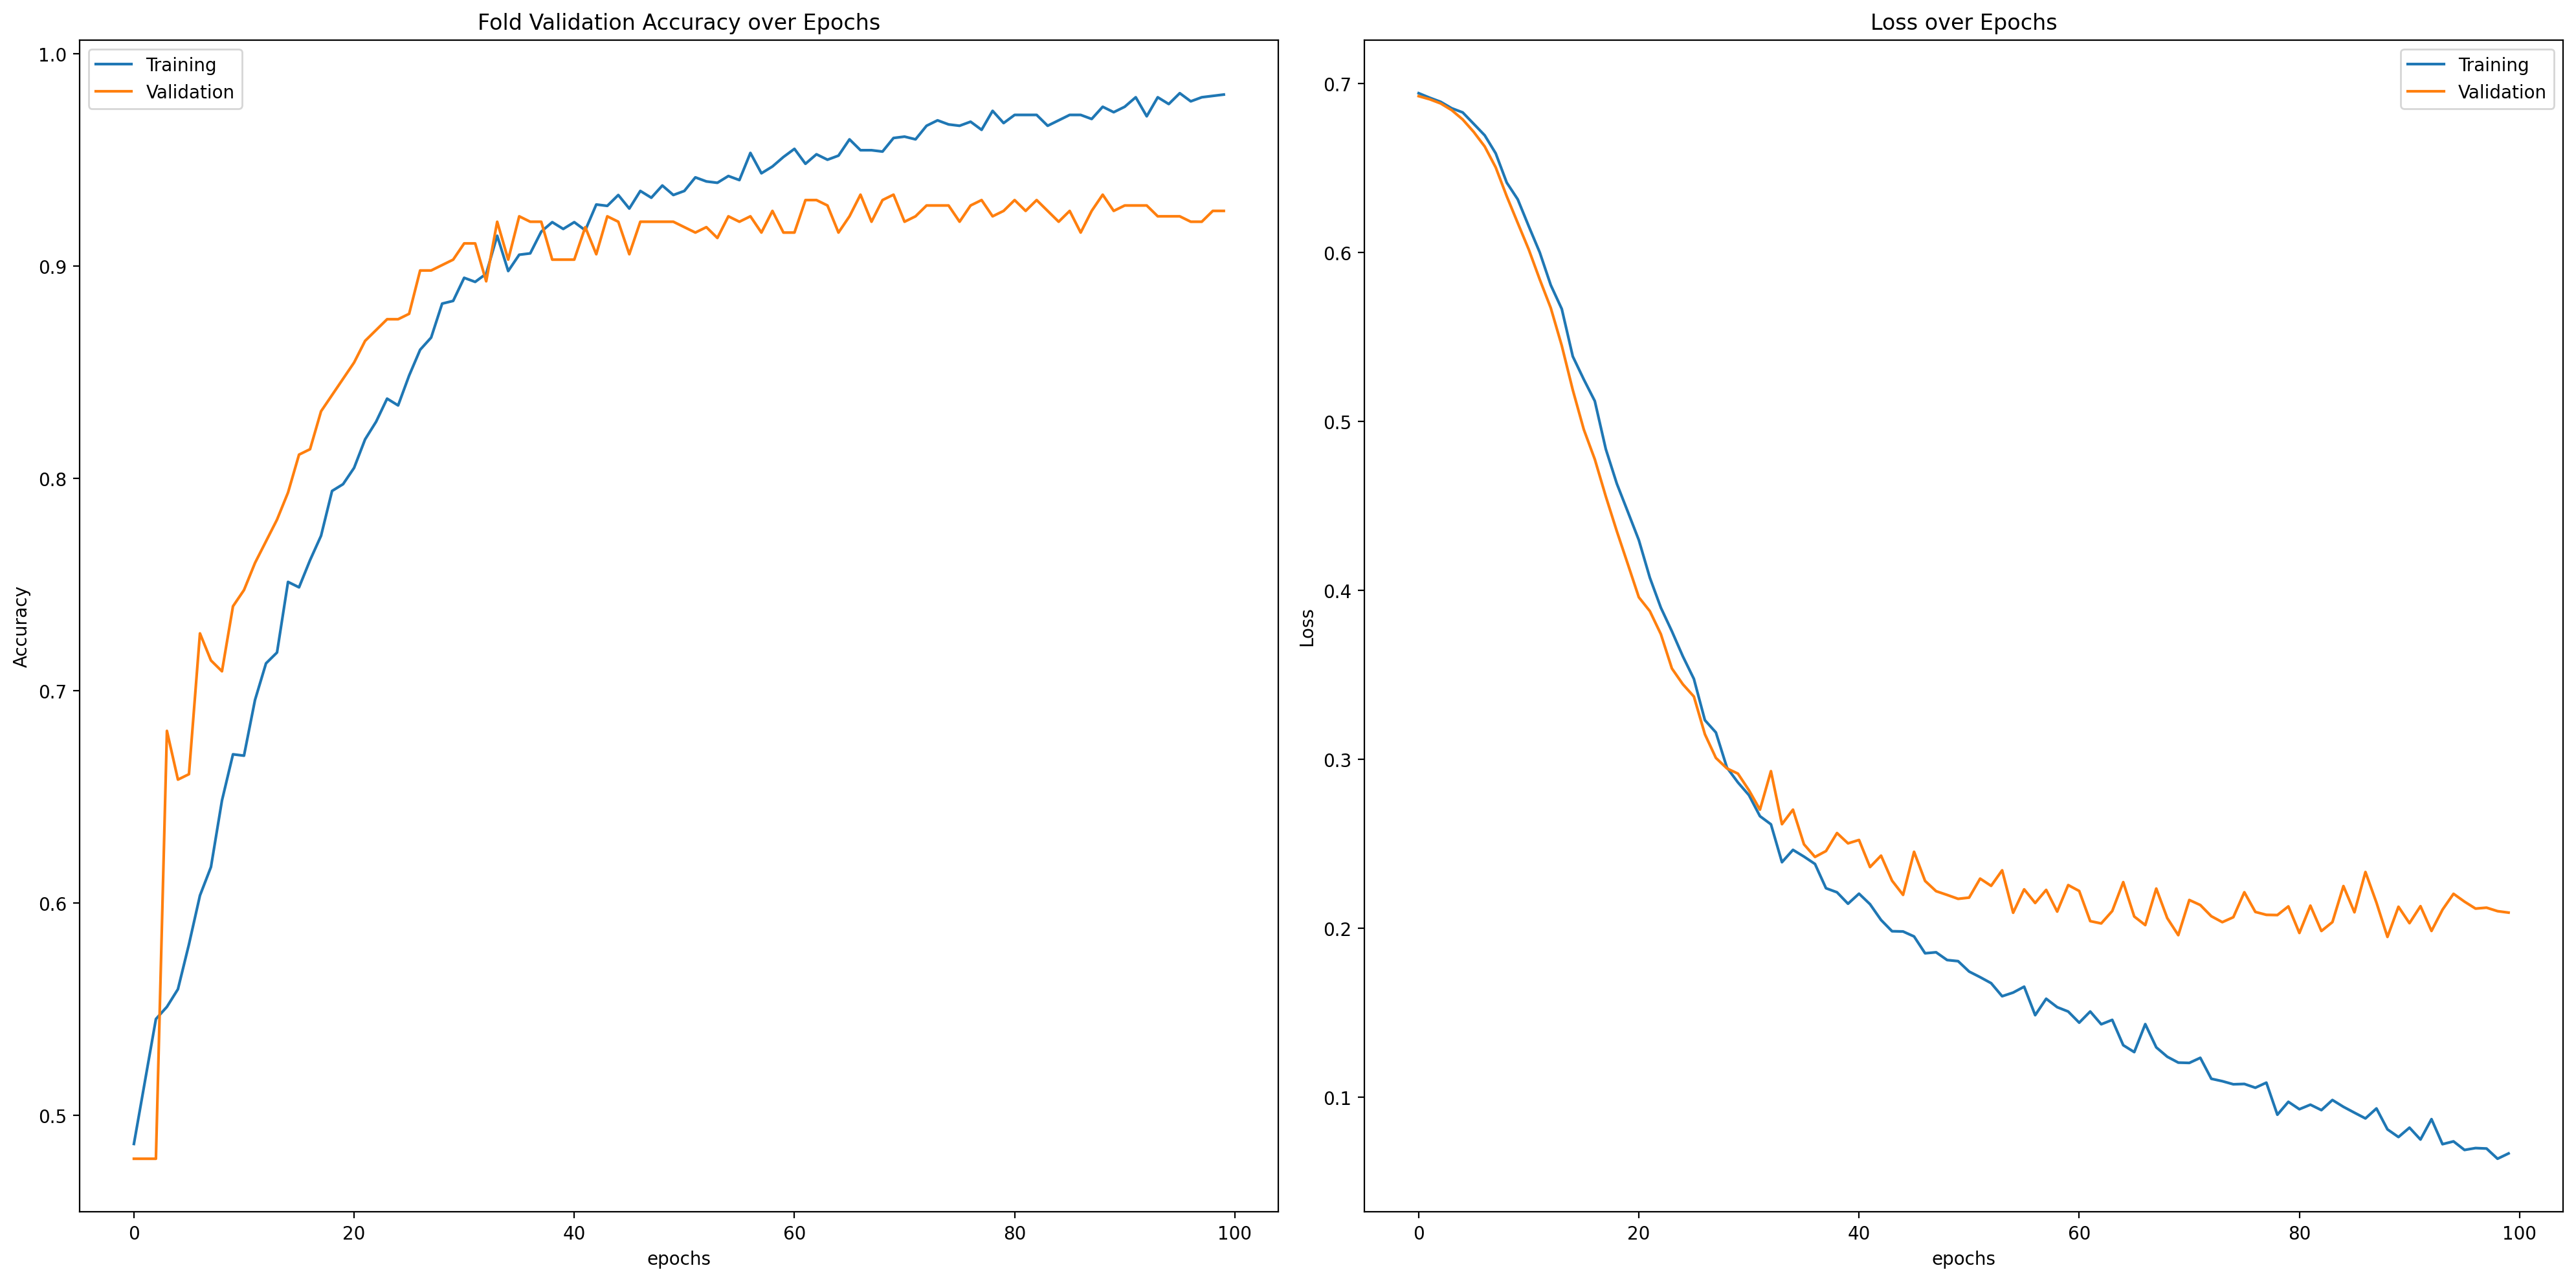

13/13 [==============================] - 0s 8ms/step
Fold validation accuracy: 0.9260203838348389
Graph 2:


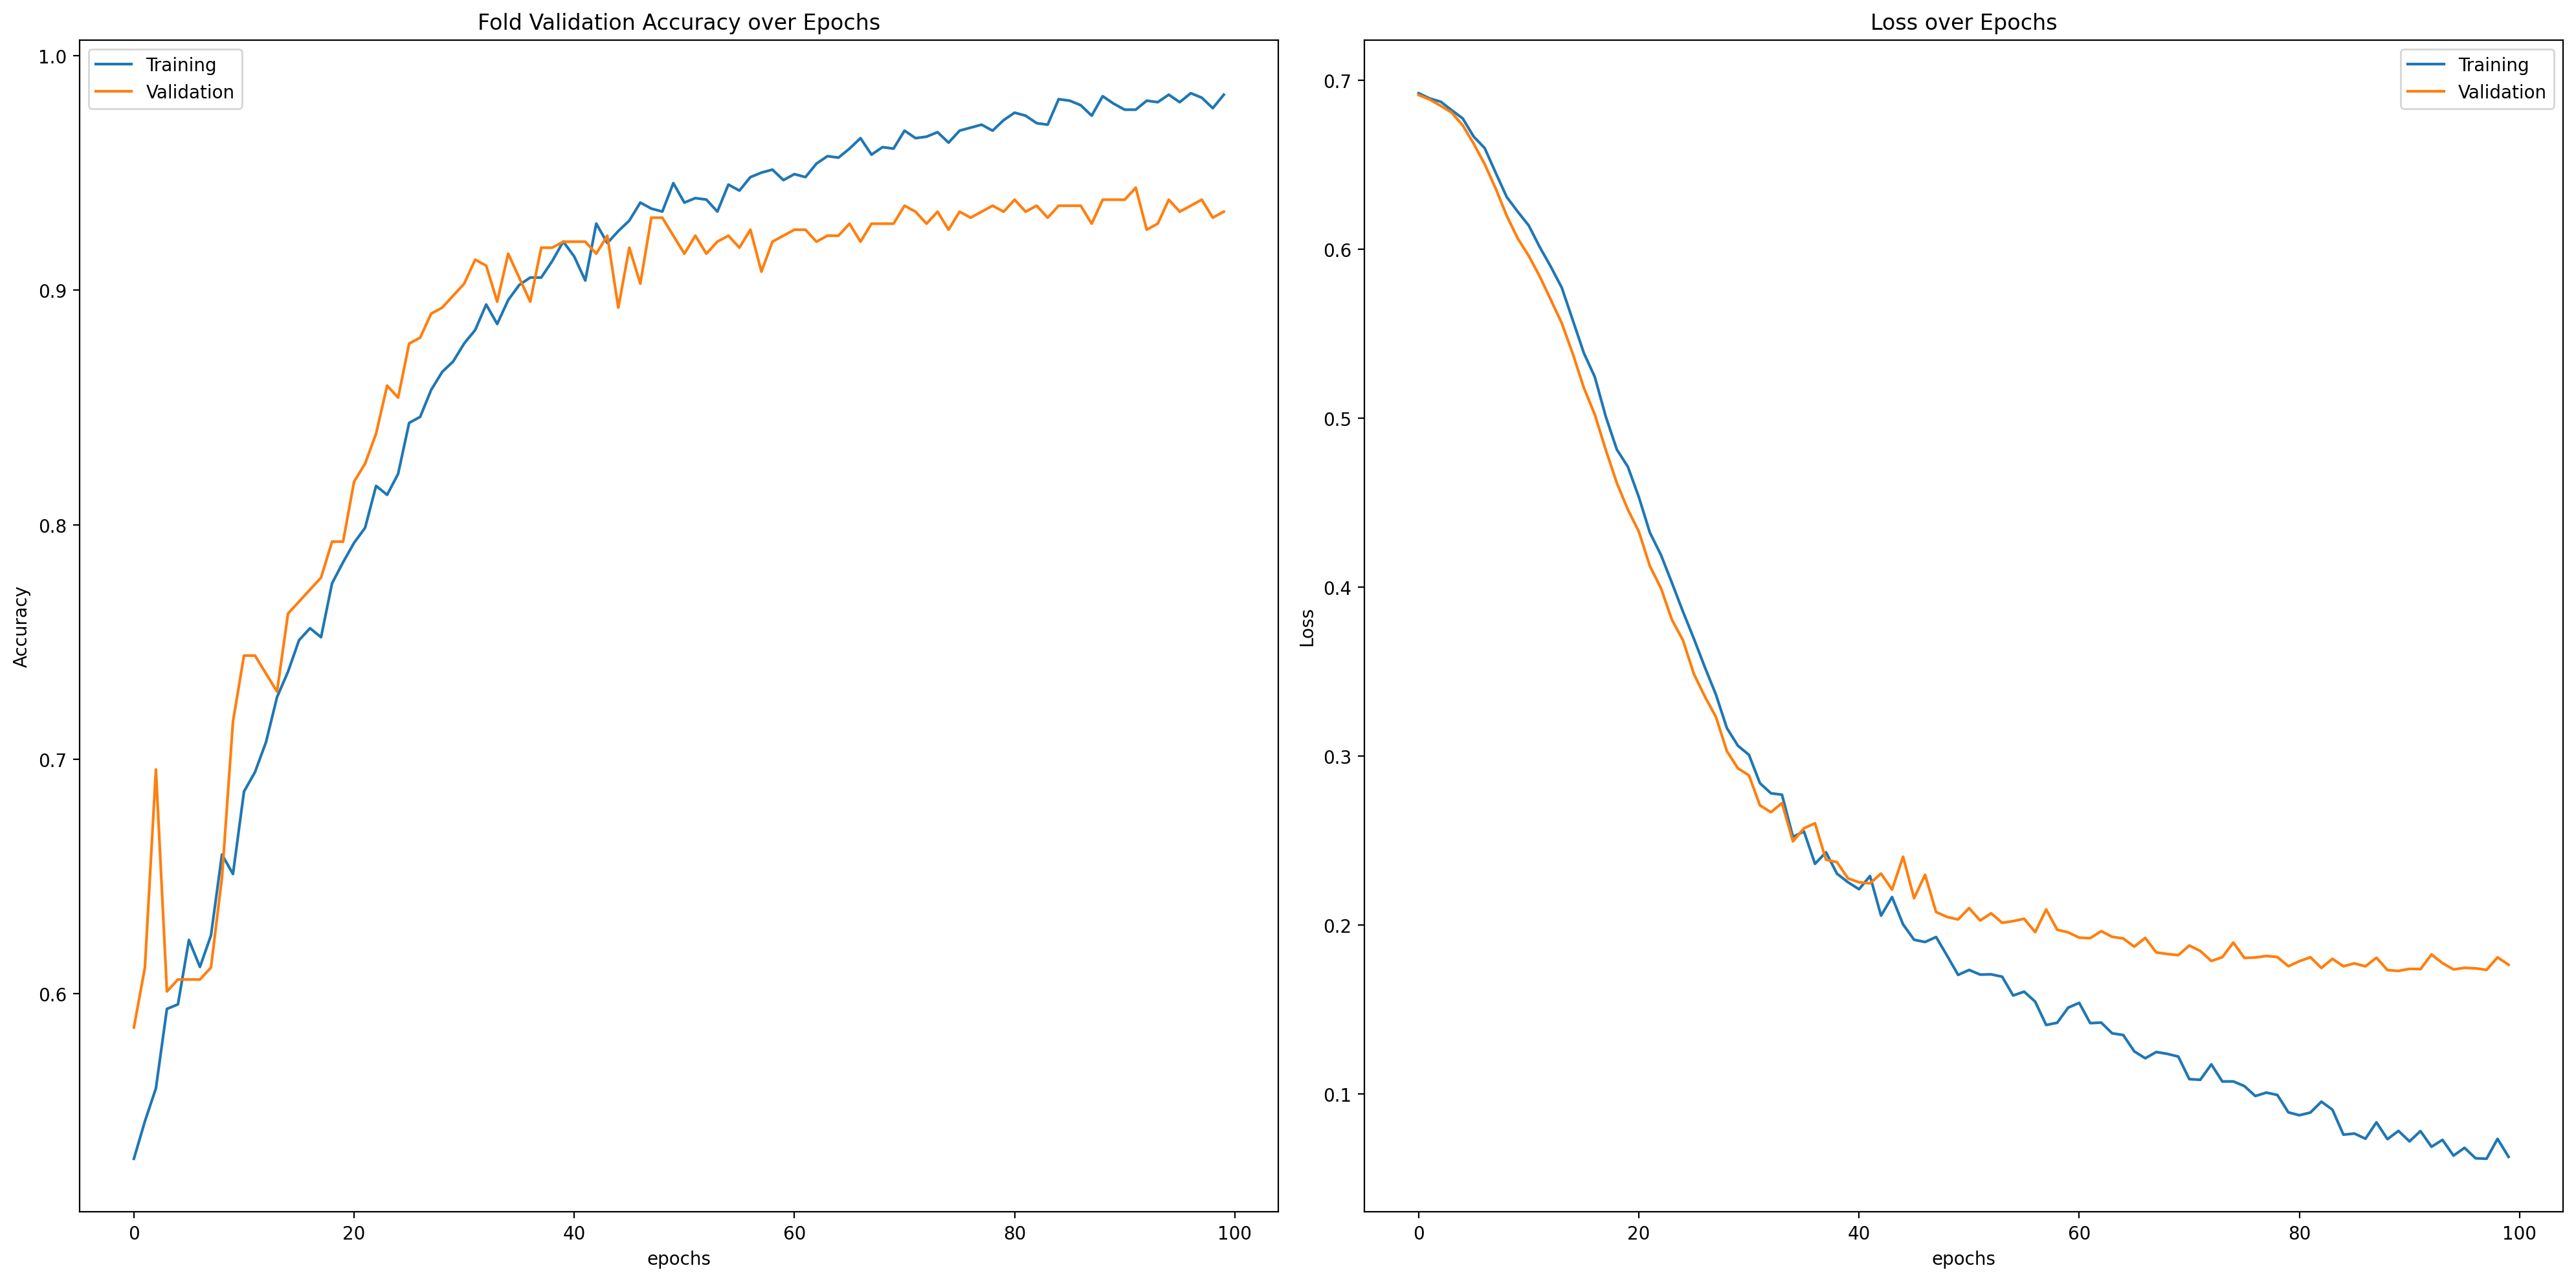

13/13 [==============================] - 0s 7ms/step
Fold validation accuracy: 0.9335038065910339
Graph 3:


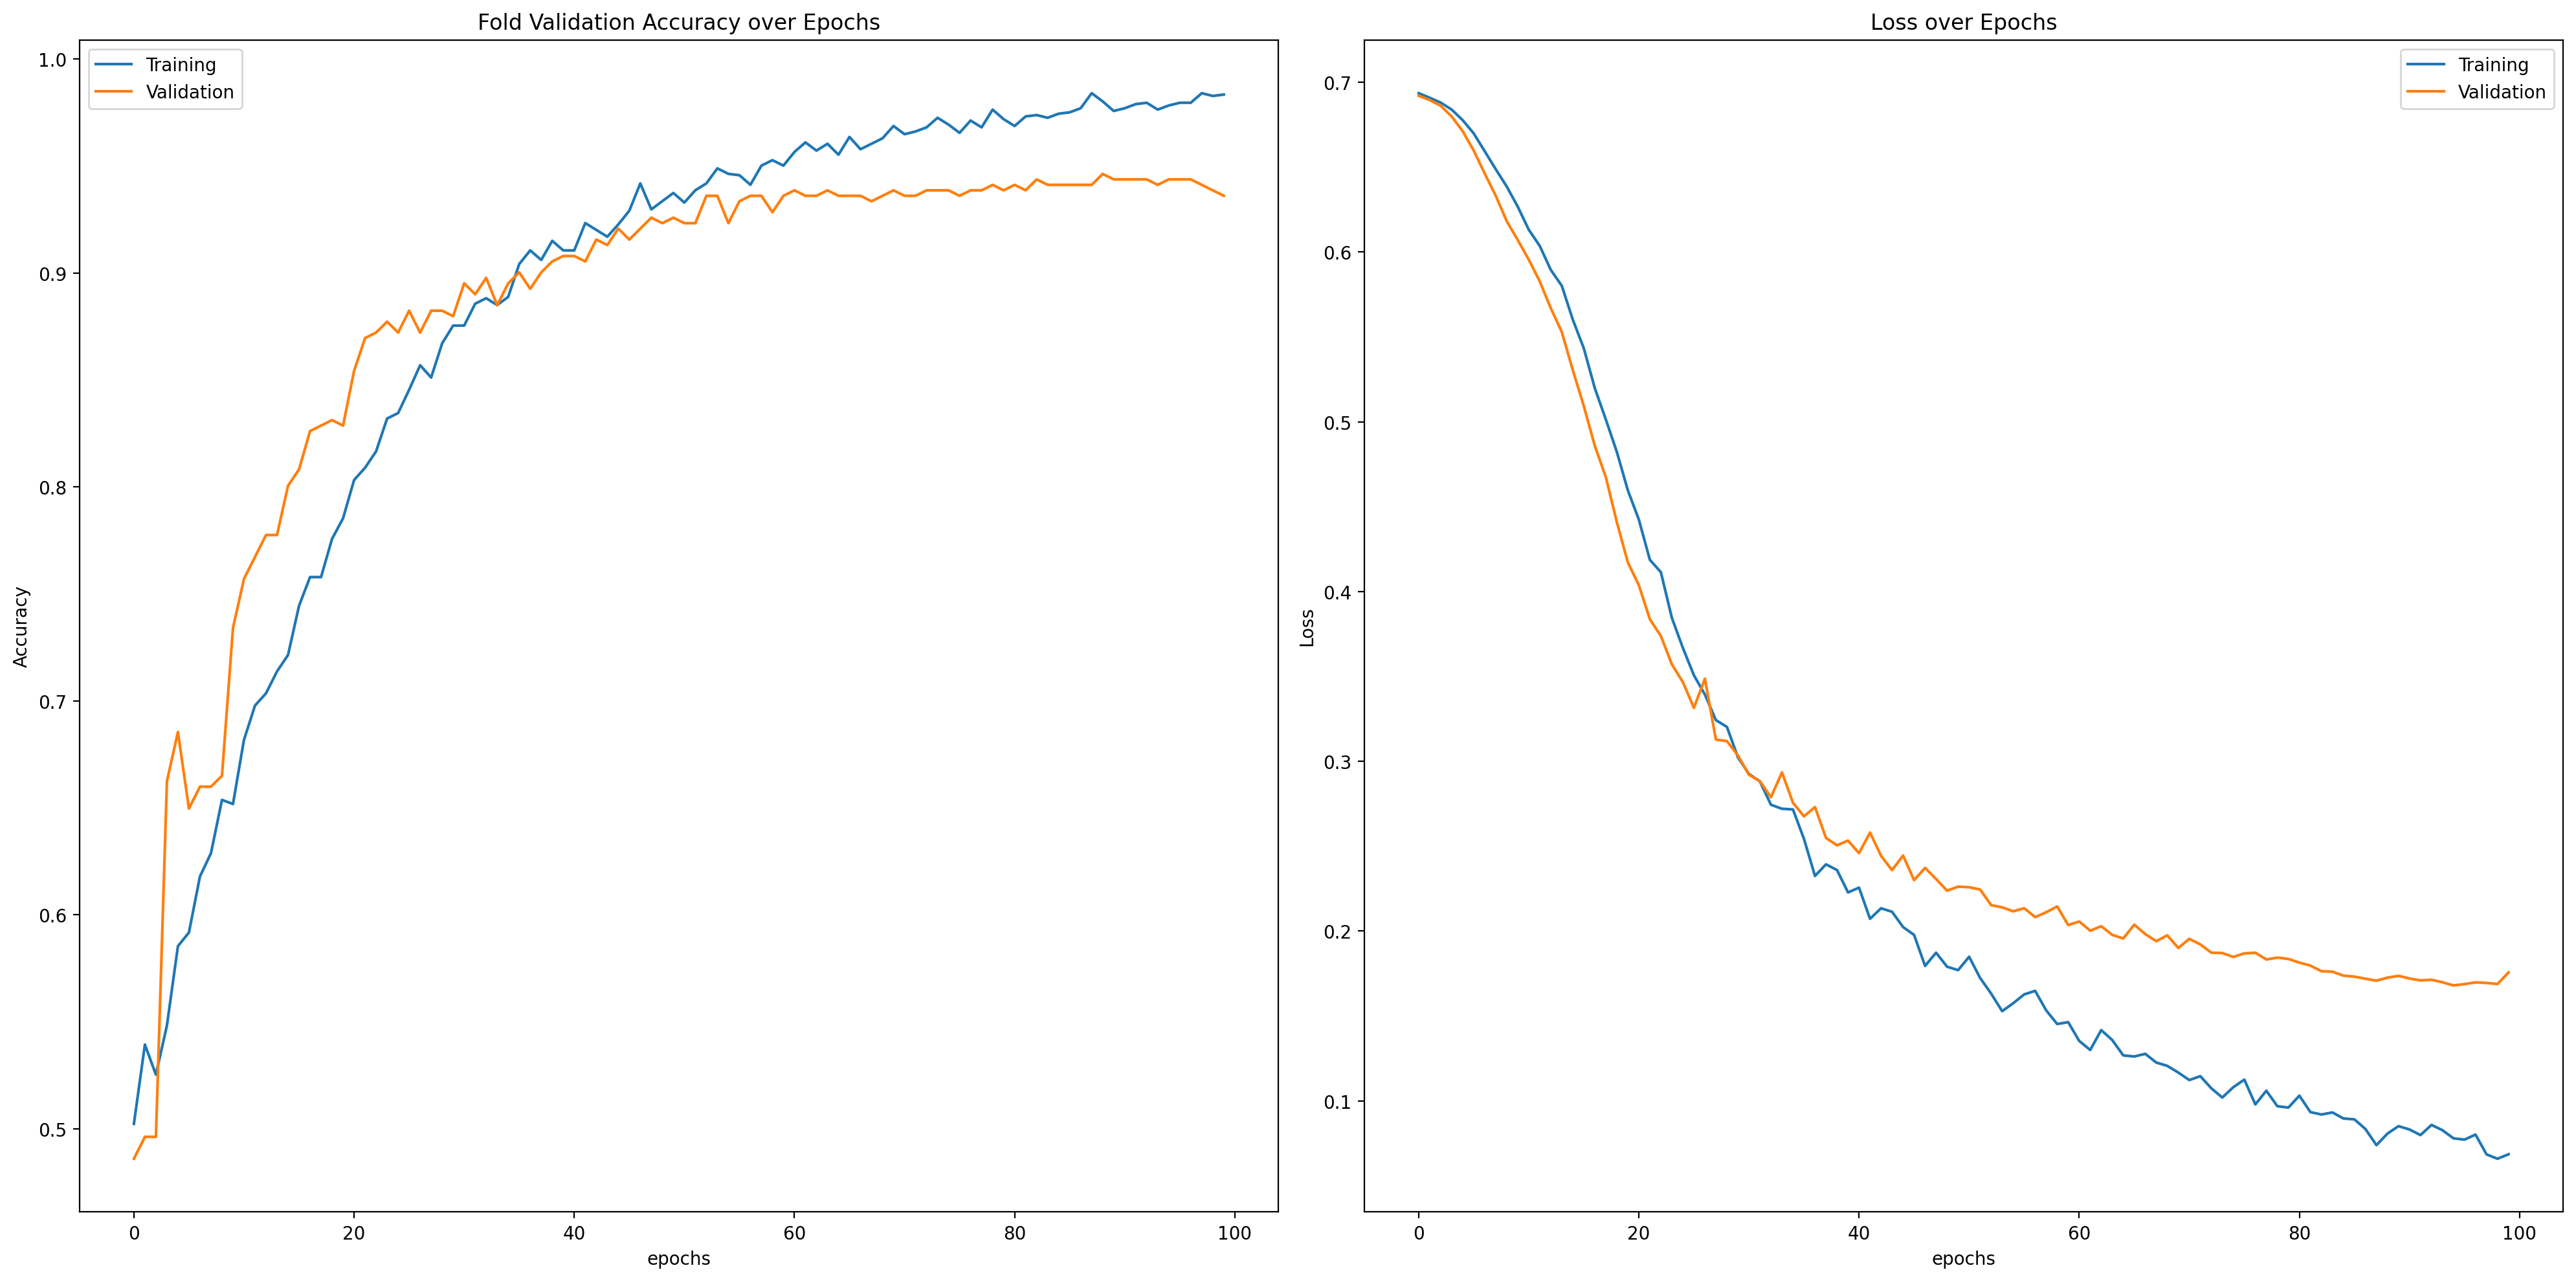

13/13 [==============================] - 0s 8ms/step
Fold validation accuracy: 0.9360613822937012
Graph 4:


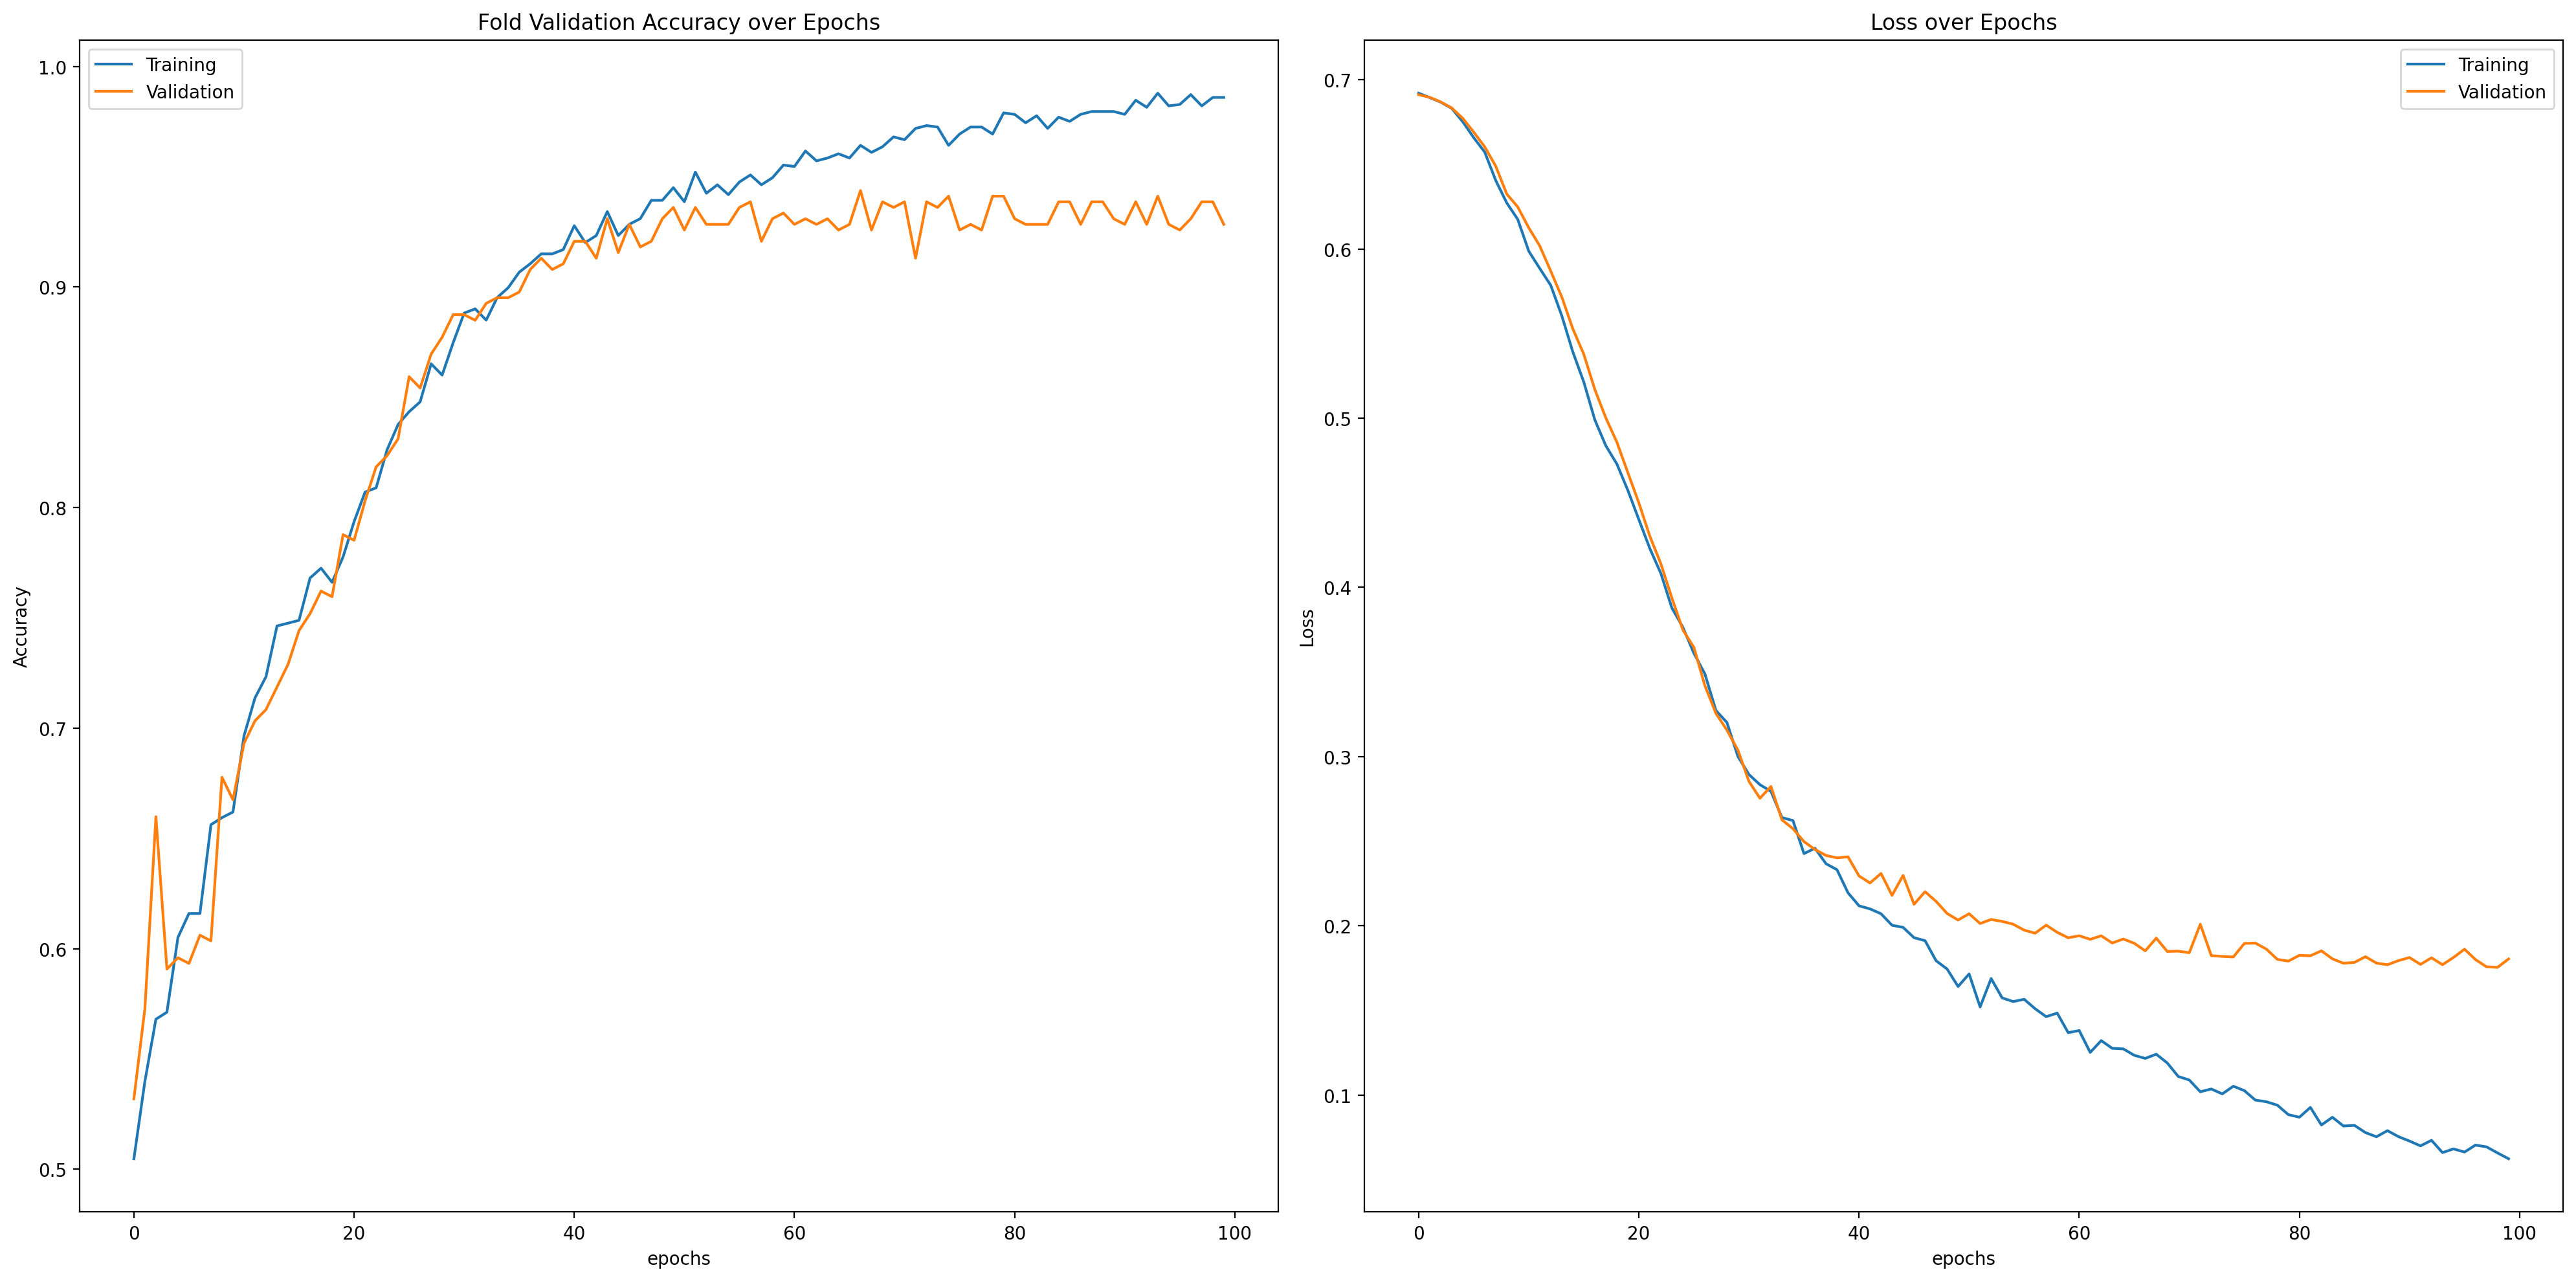

13/13 [==============================] - 0s 10ms/step
Fold validation accuracy: 0.928388774394989
Graph 5:


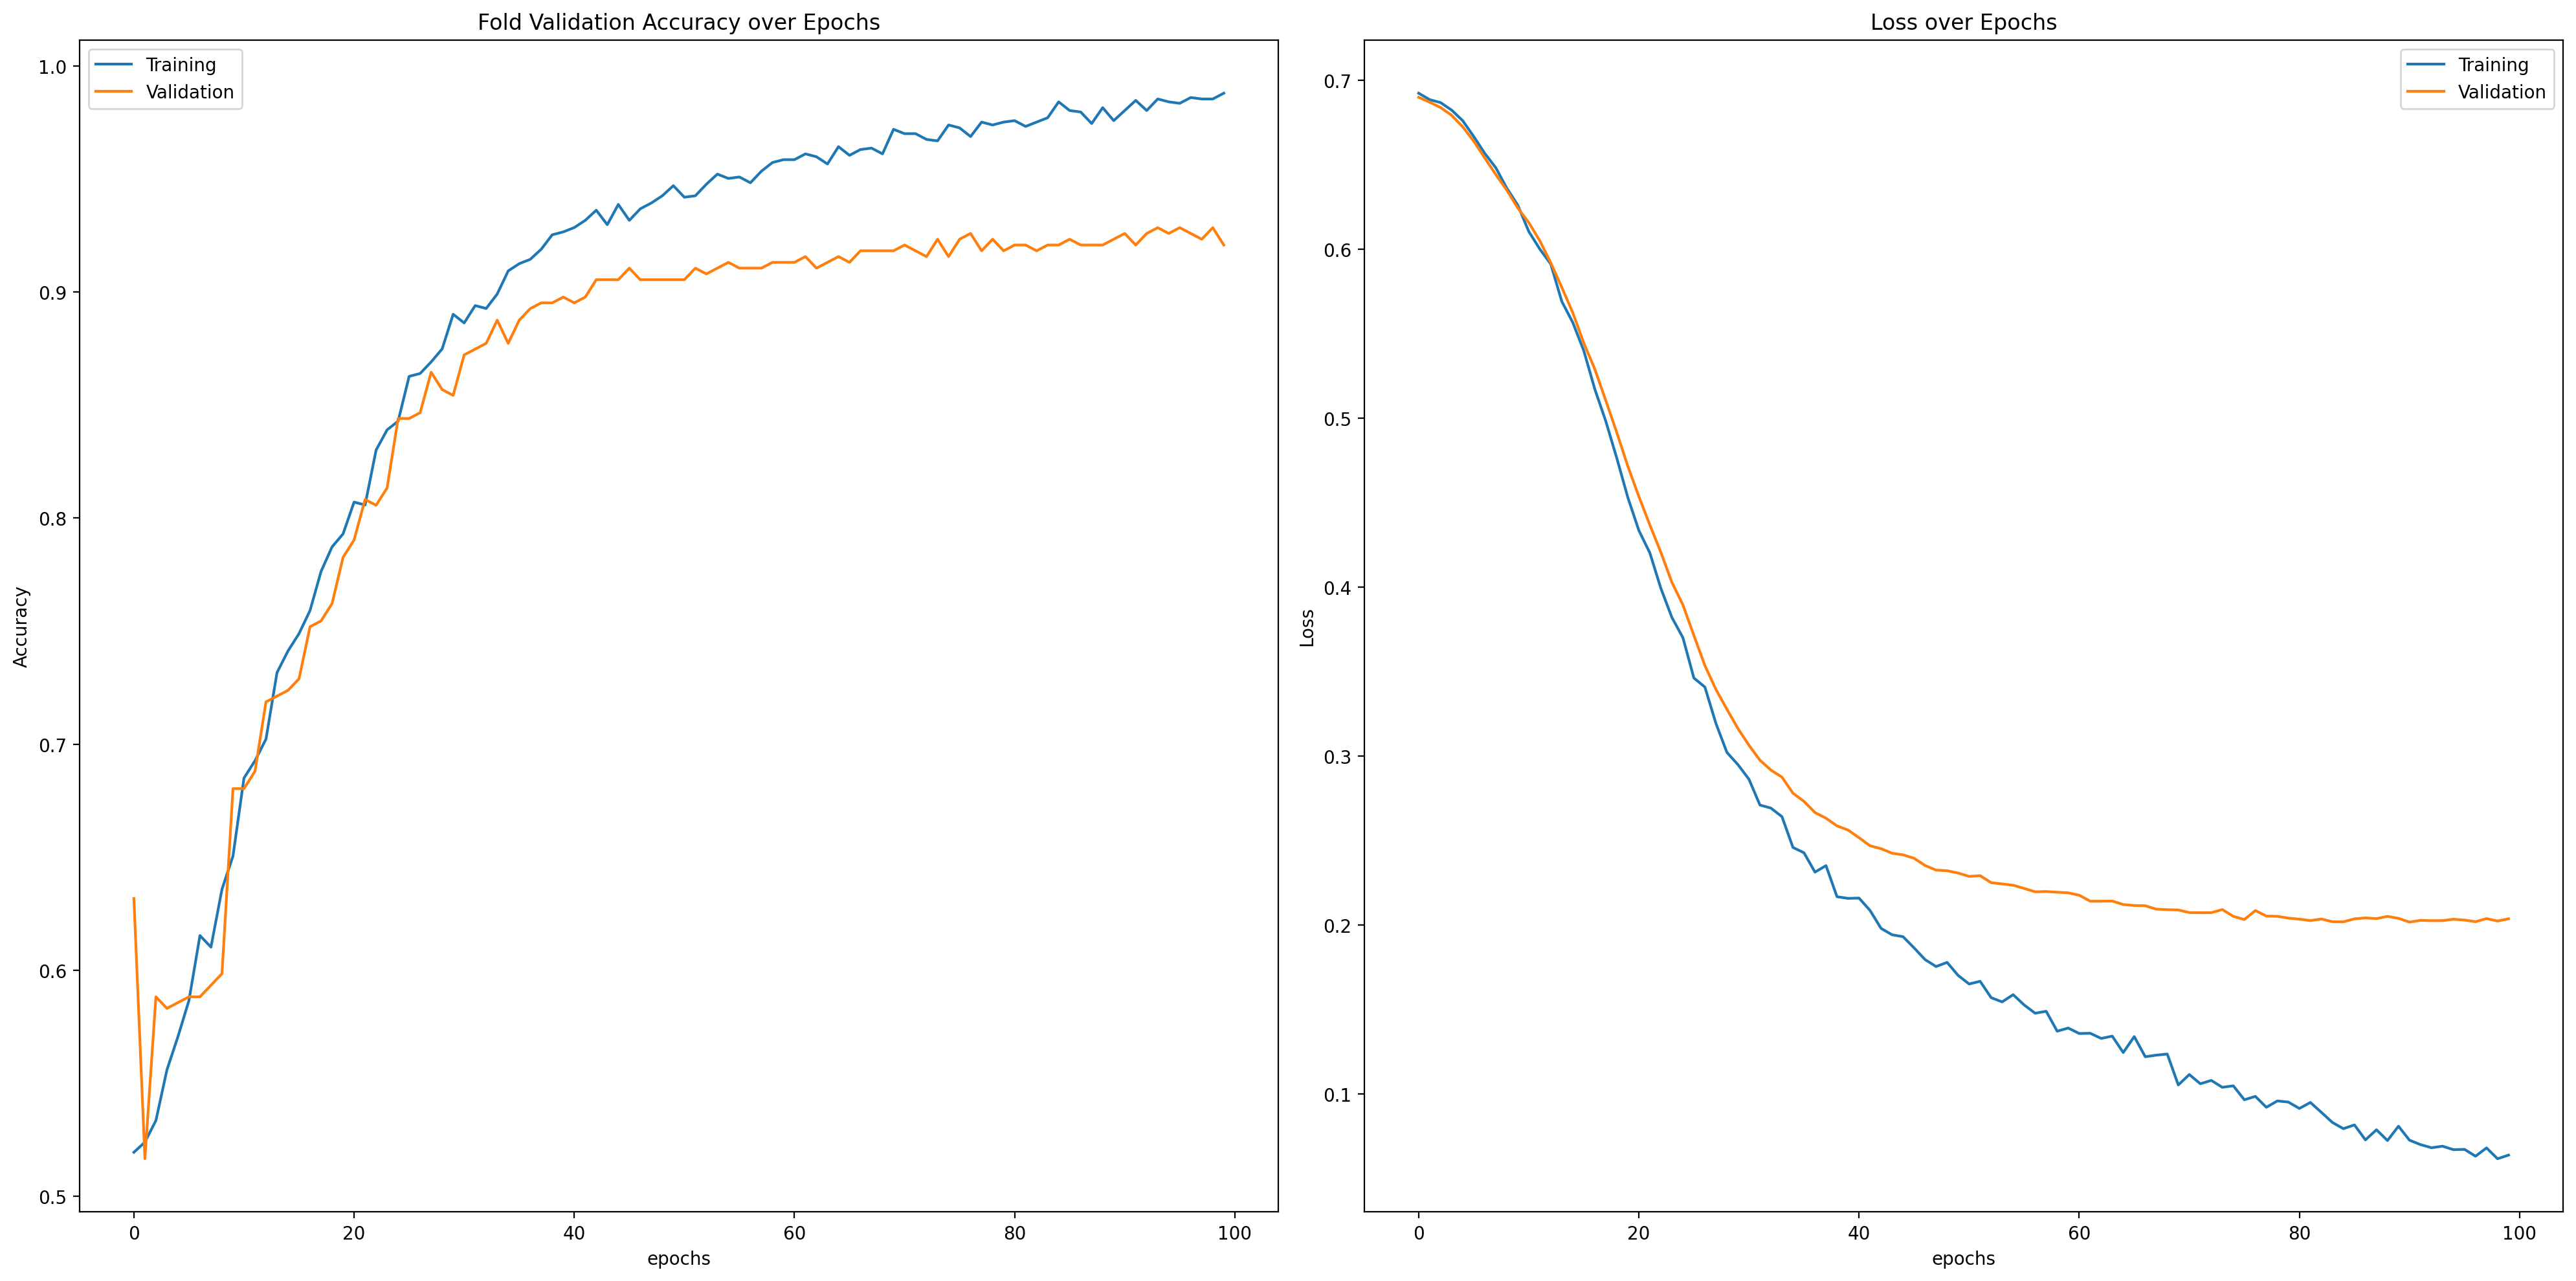

13/13 [==============================] - 0s 10ms/step
Fold validation accuracy: 0.9207161068916321
Average Accuracy: 0.928938090801239


In [38]:
# the input is a list of integers, 500 long
sequence_input = Input(shape=(X.shape[1], ))

embedded_sequences = Embedding(
    len(word_index) + 1, EMBED_SIZE, weights=[embedding_matrix], input_length=max_length, 
    trainable=False)(sequence_input)

x = Conv1D(64, 5, activation='relu',kernel_initializer='he_uniform')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

# Just Mean Pooling but kernel size is the whole thing, leaves 64 results for each of the 64 filters.
x_mean = GlobalAveragePooling1D()(x)

# Both of these steps compute the Variance, results in 64 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])

x = Dense(32, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

cnn1 = Model(sequence_input, preds)
pred_cnn1, acc_cnn1 = test_model(X, labels, kf, cnn1, 1, "cnn1_predictions.csv", ep=100, bs=64, lr=0.0001)

In this modified CNN, we changed the number of filters used in the first and third Convolutional Layers from 64 to 128 and 32 respectively.

Graph 1:


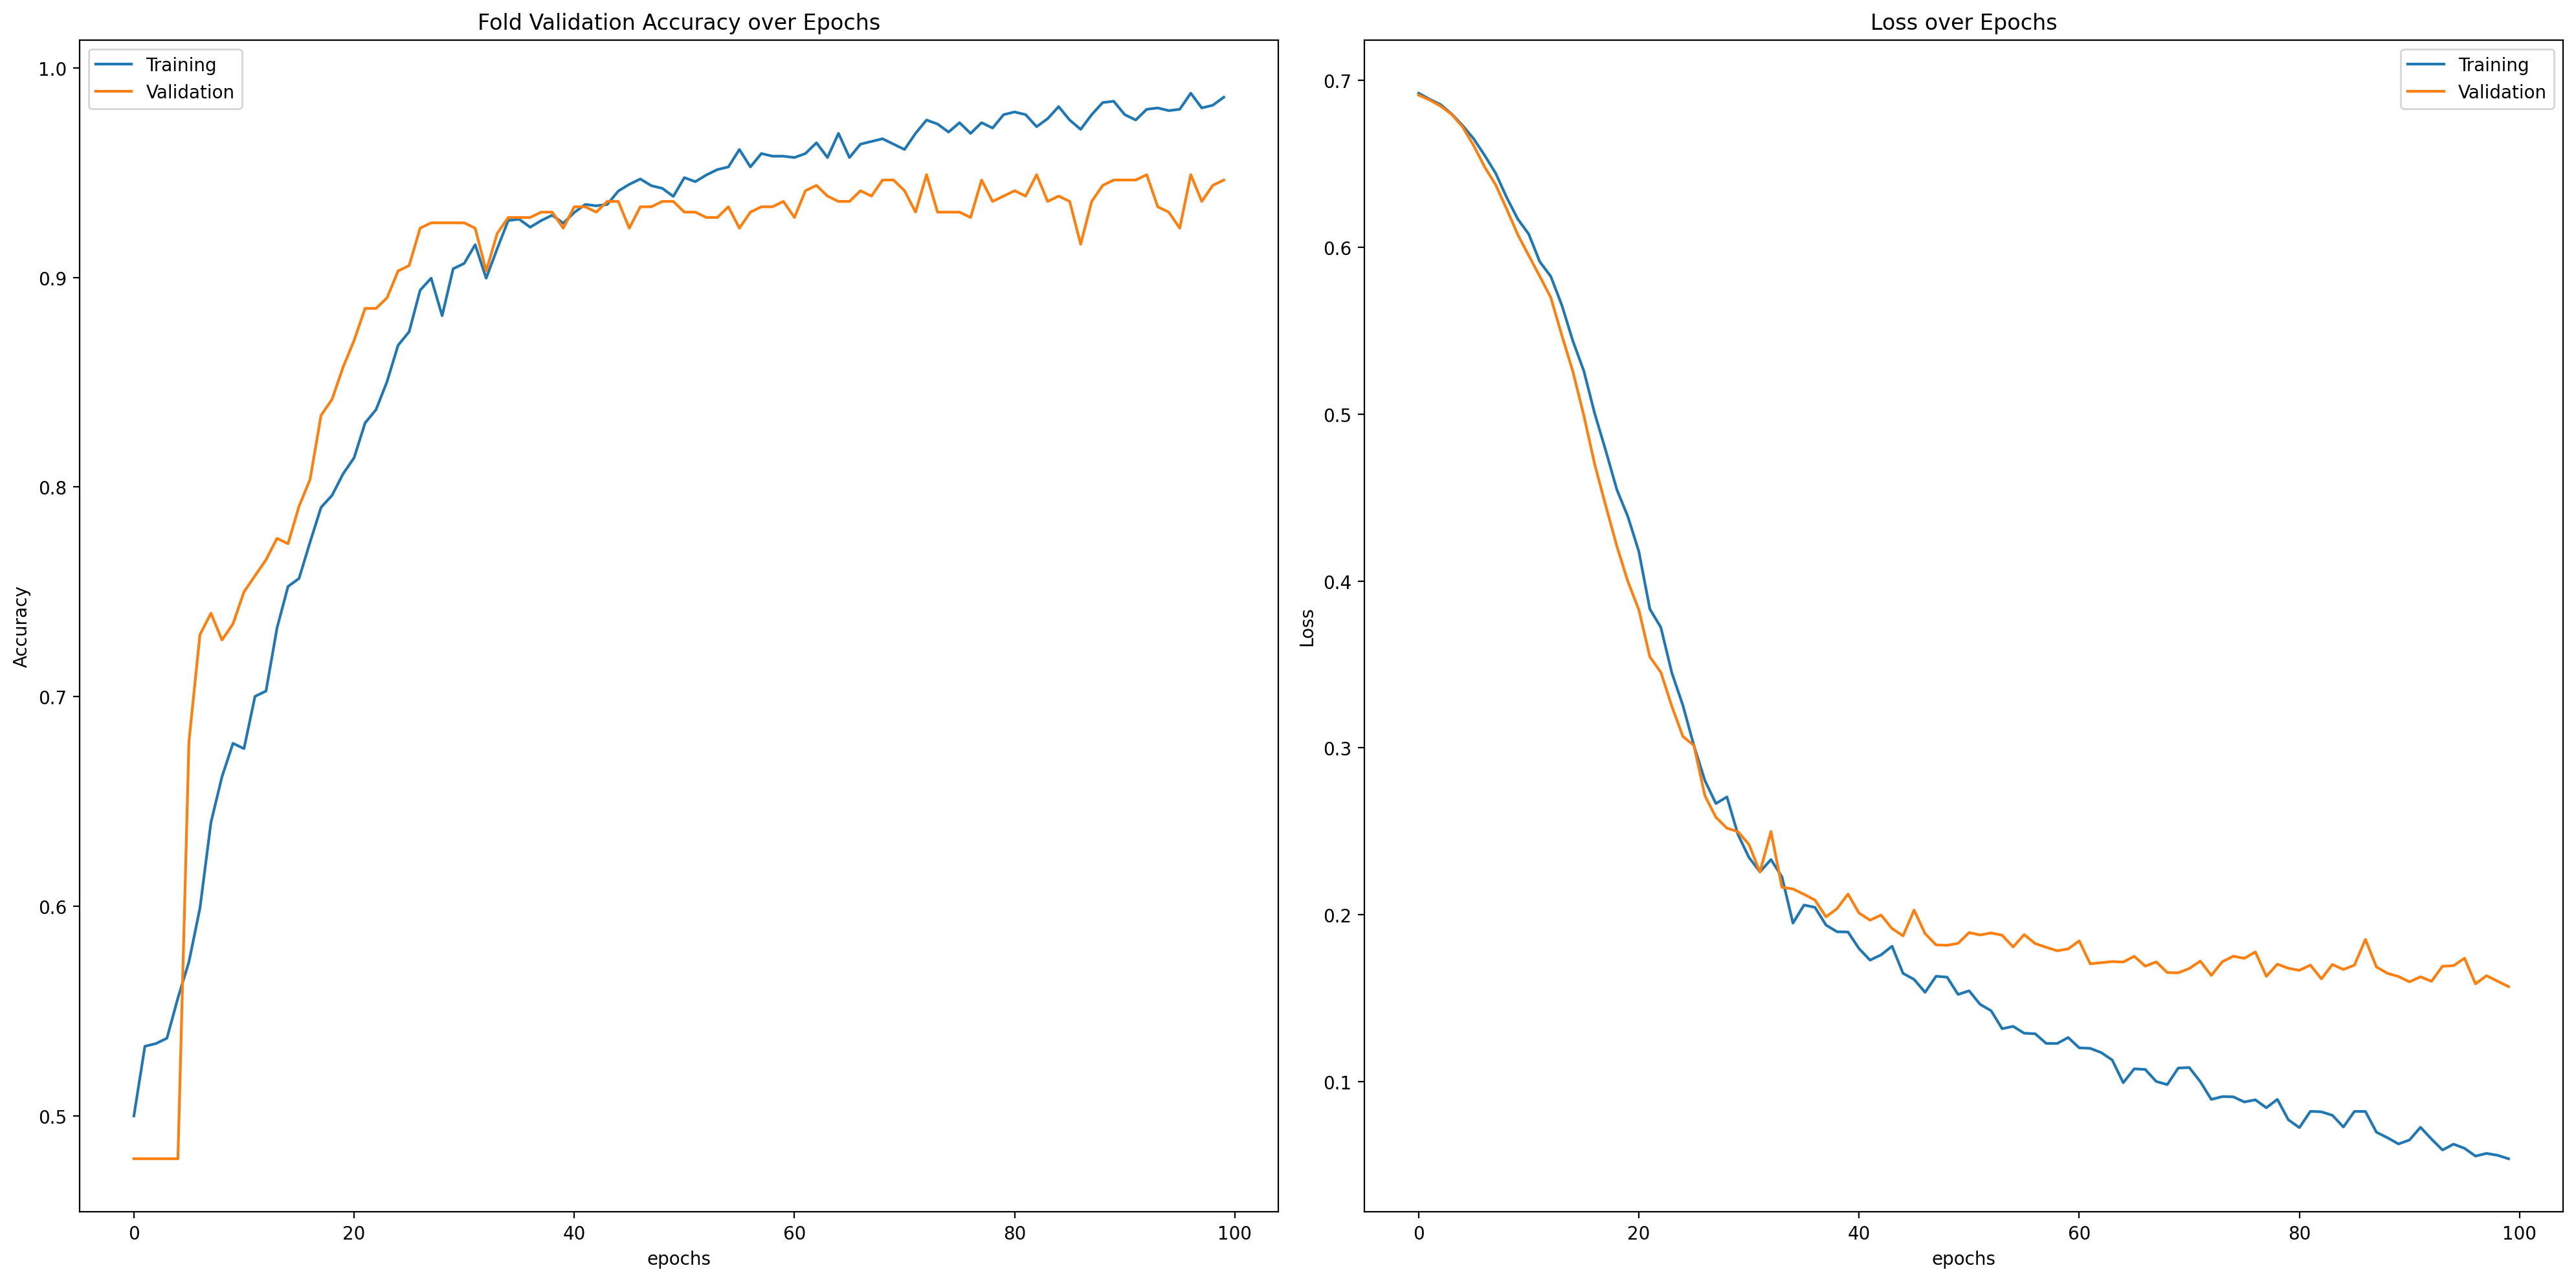

13/13 [==============================] - 0s 7ms/step
Fold validation accuracy: 0.9464285969734192
Graph 2:


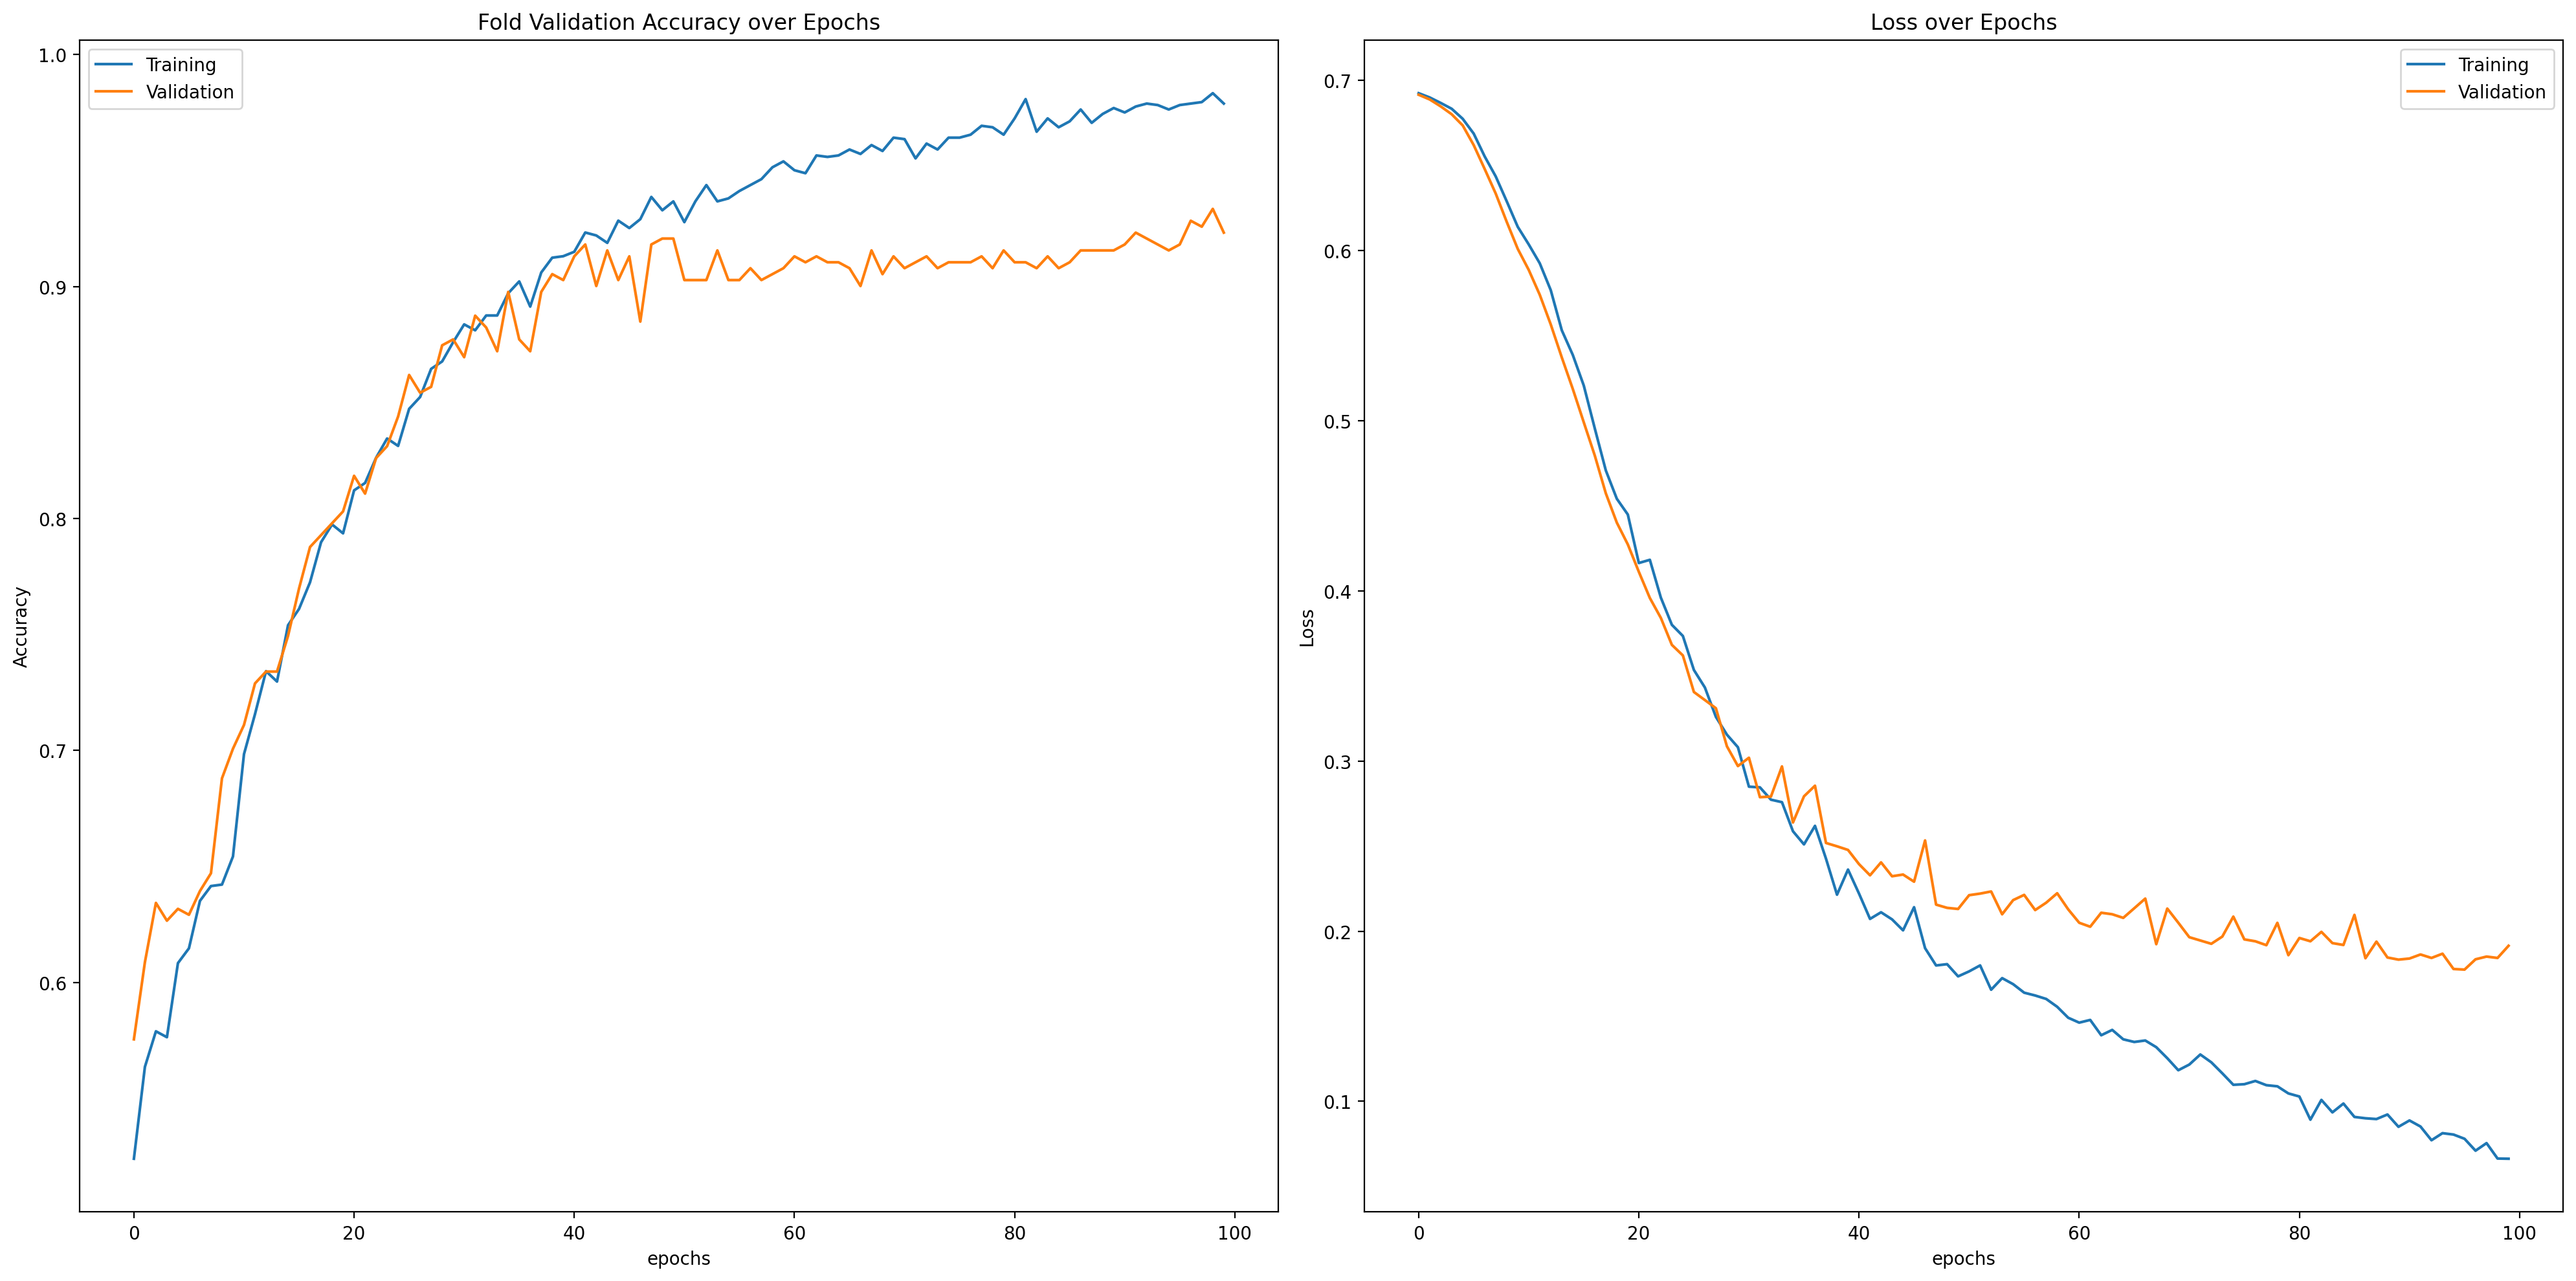

13/13 [==============================] - 0s 8ms/step
Fold validation accuracy: 0.9232736825942993
Graph 3:


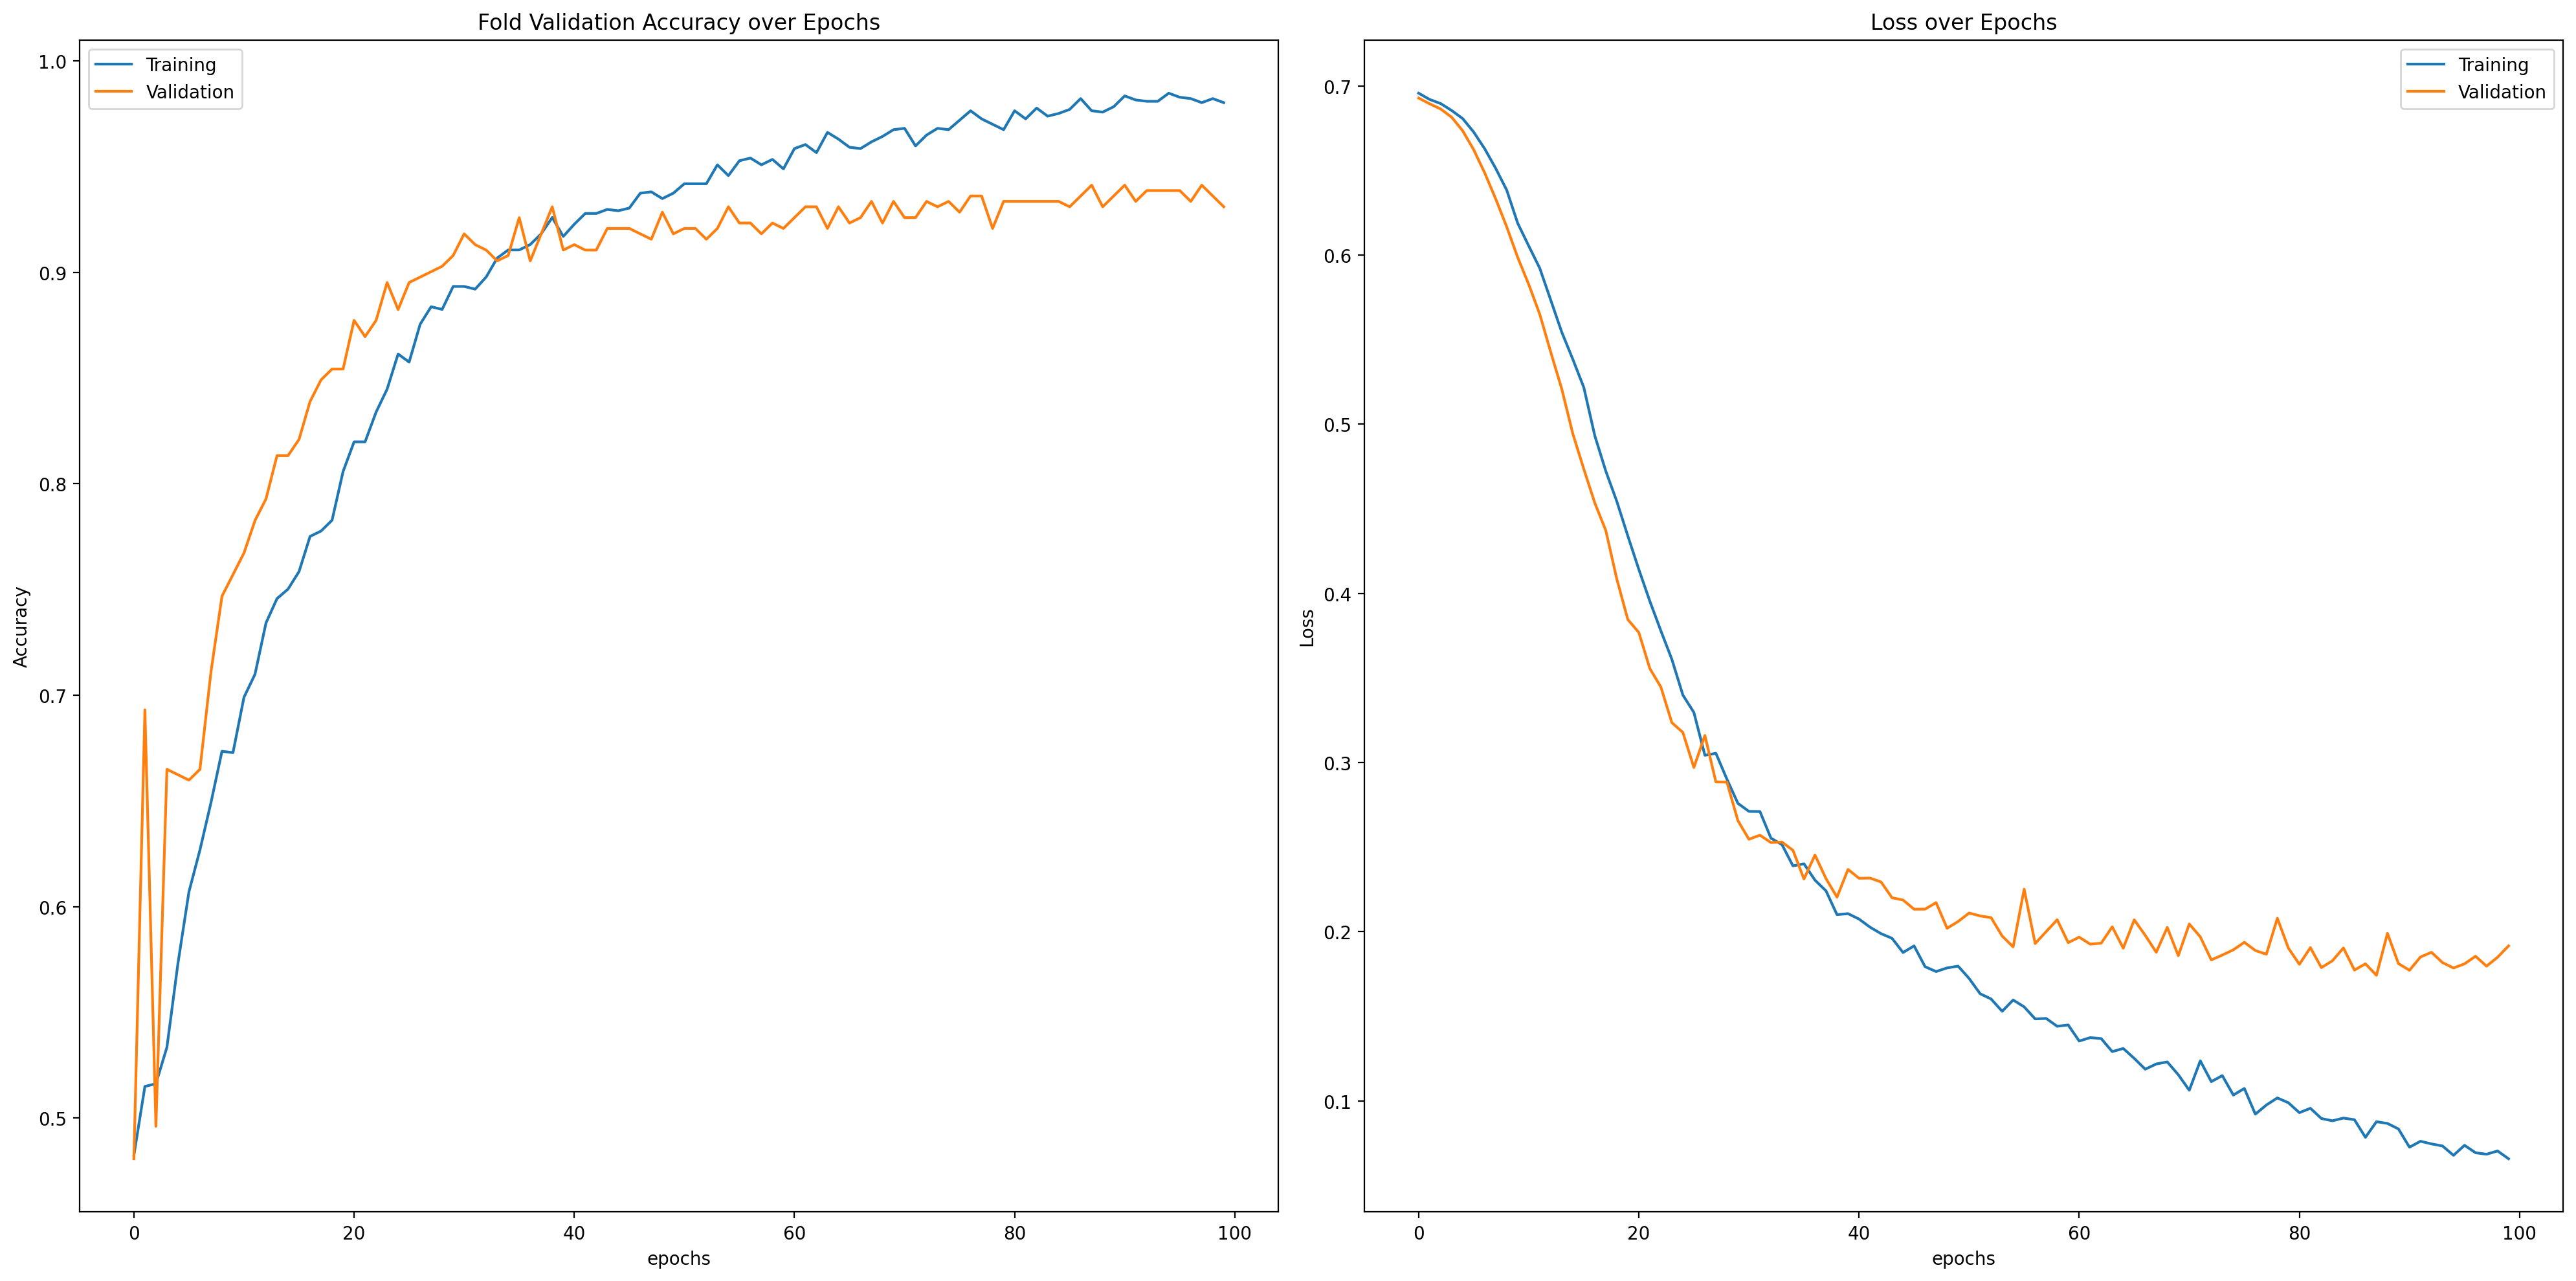

13/13 [==============================] - 0s 8ms/step
Fold validation accuracy: 0.9309462904930115
Graph 4:


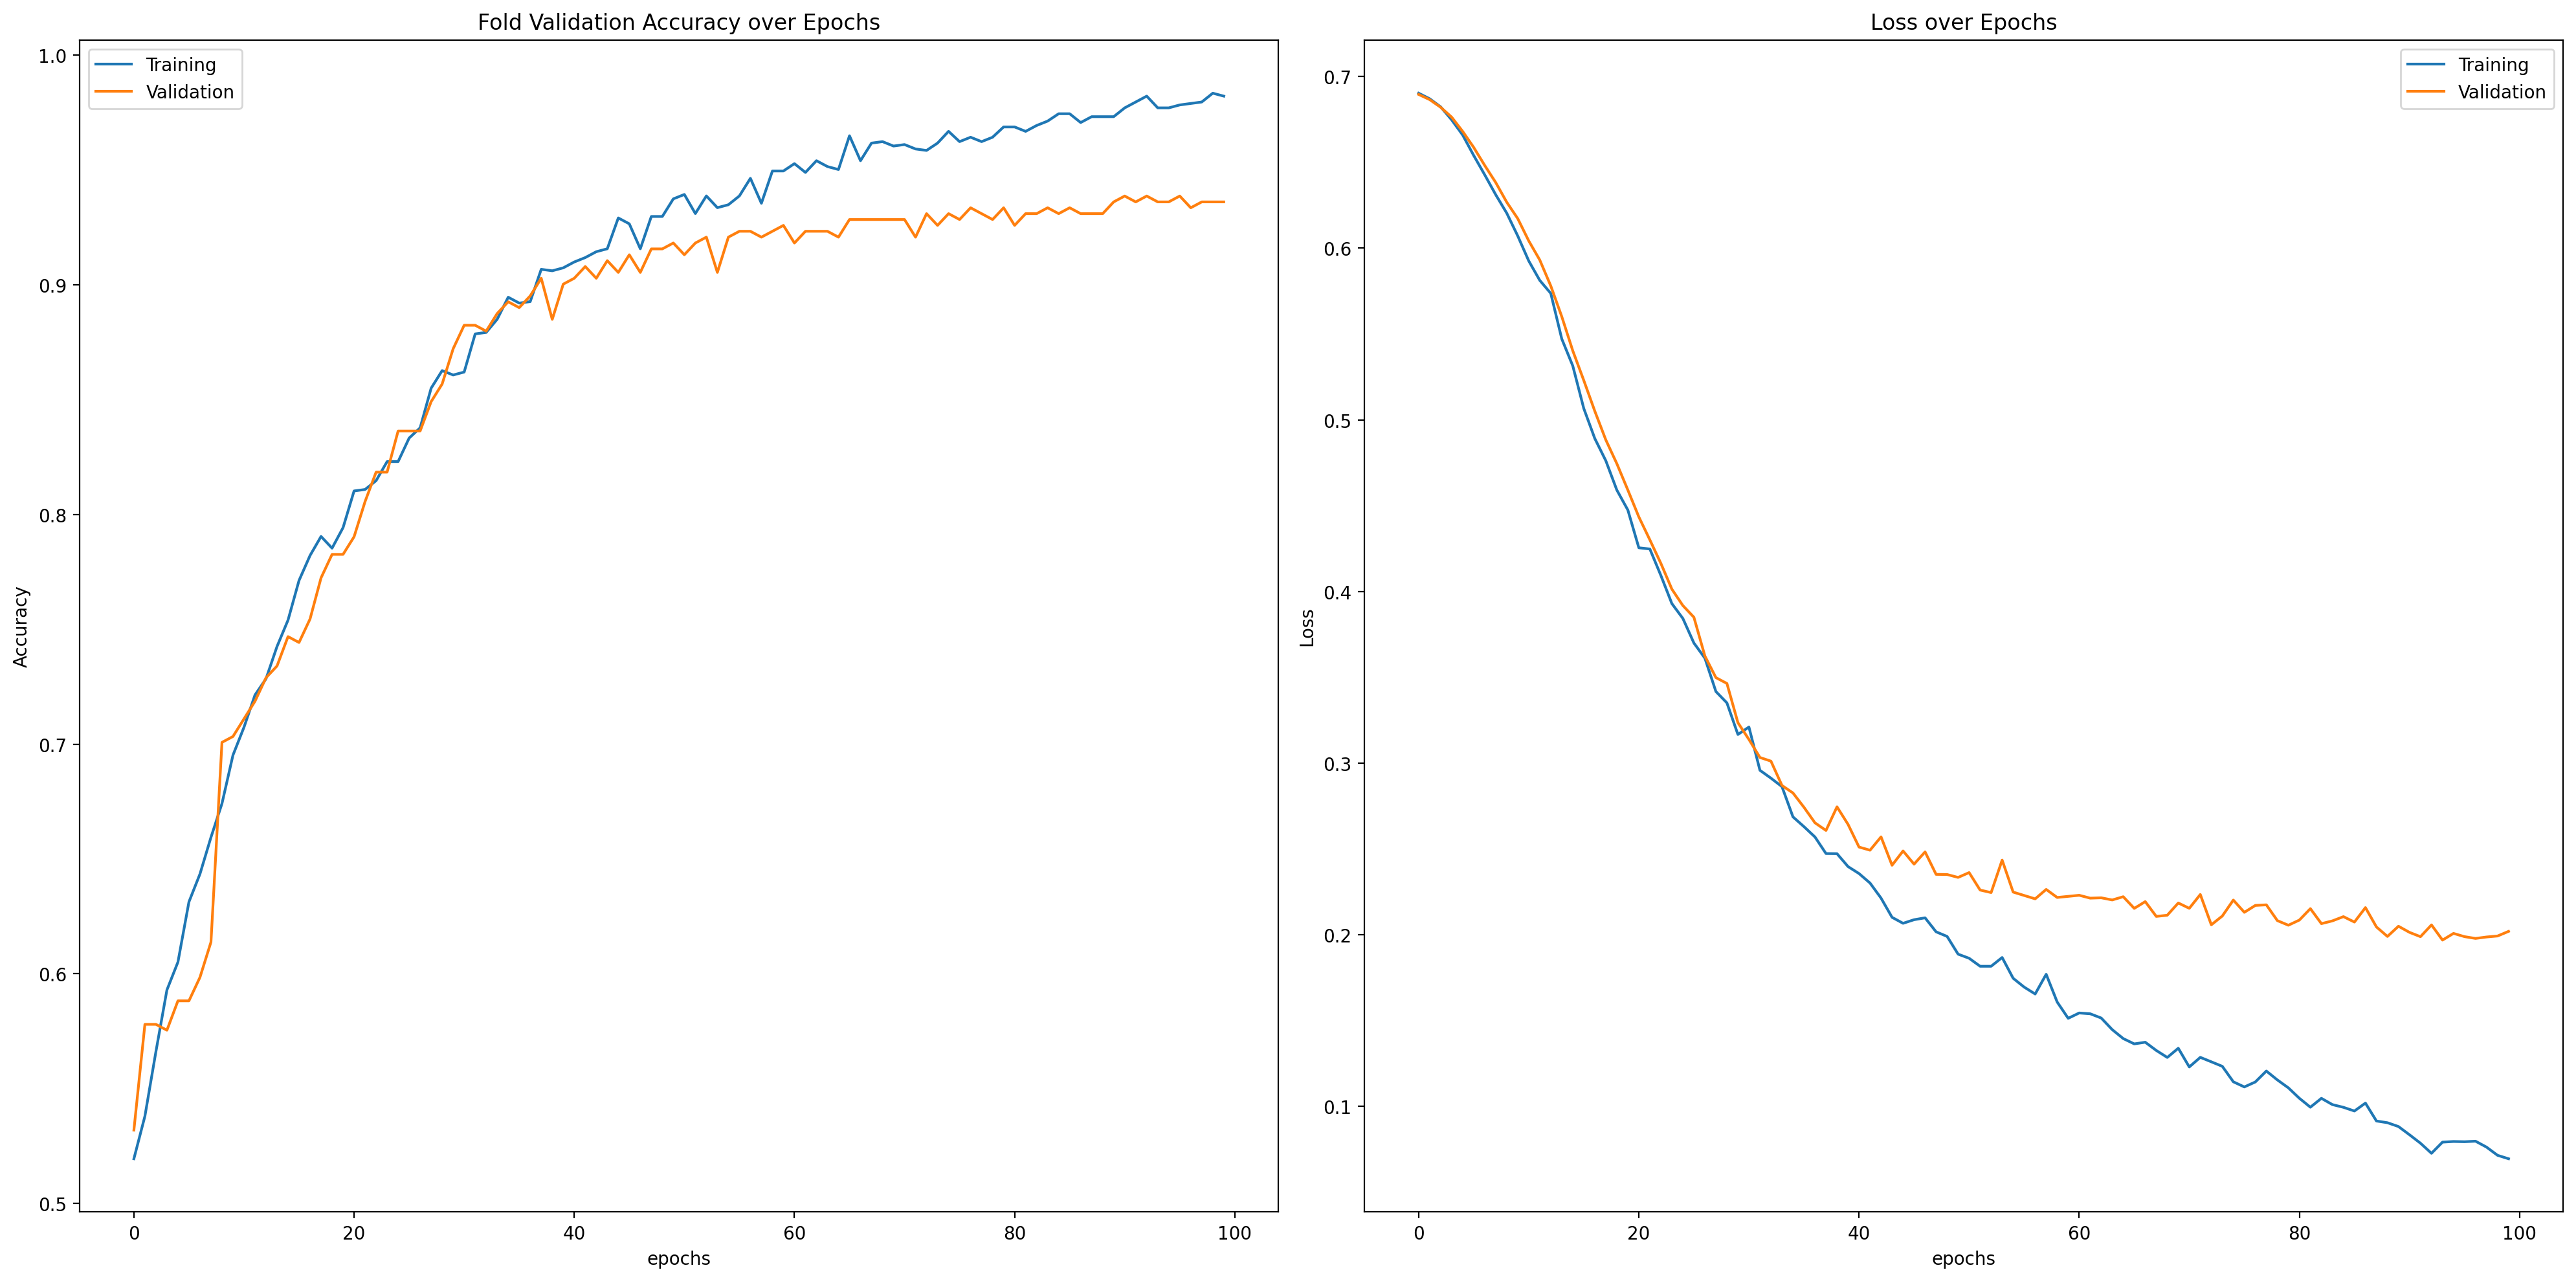

13/13 [==============================] - 0s 6ms/step
Fold validation accuracy: 0.9360613822937012
Graph 5:


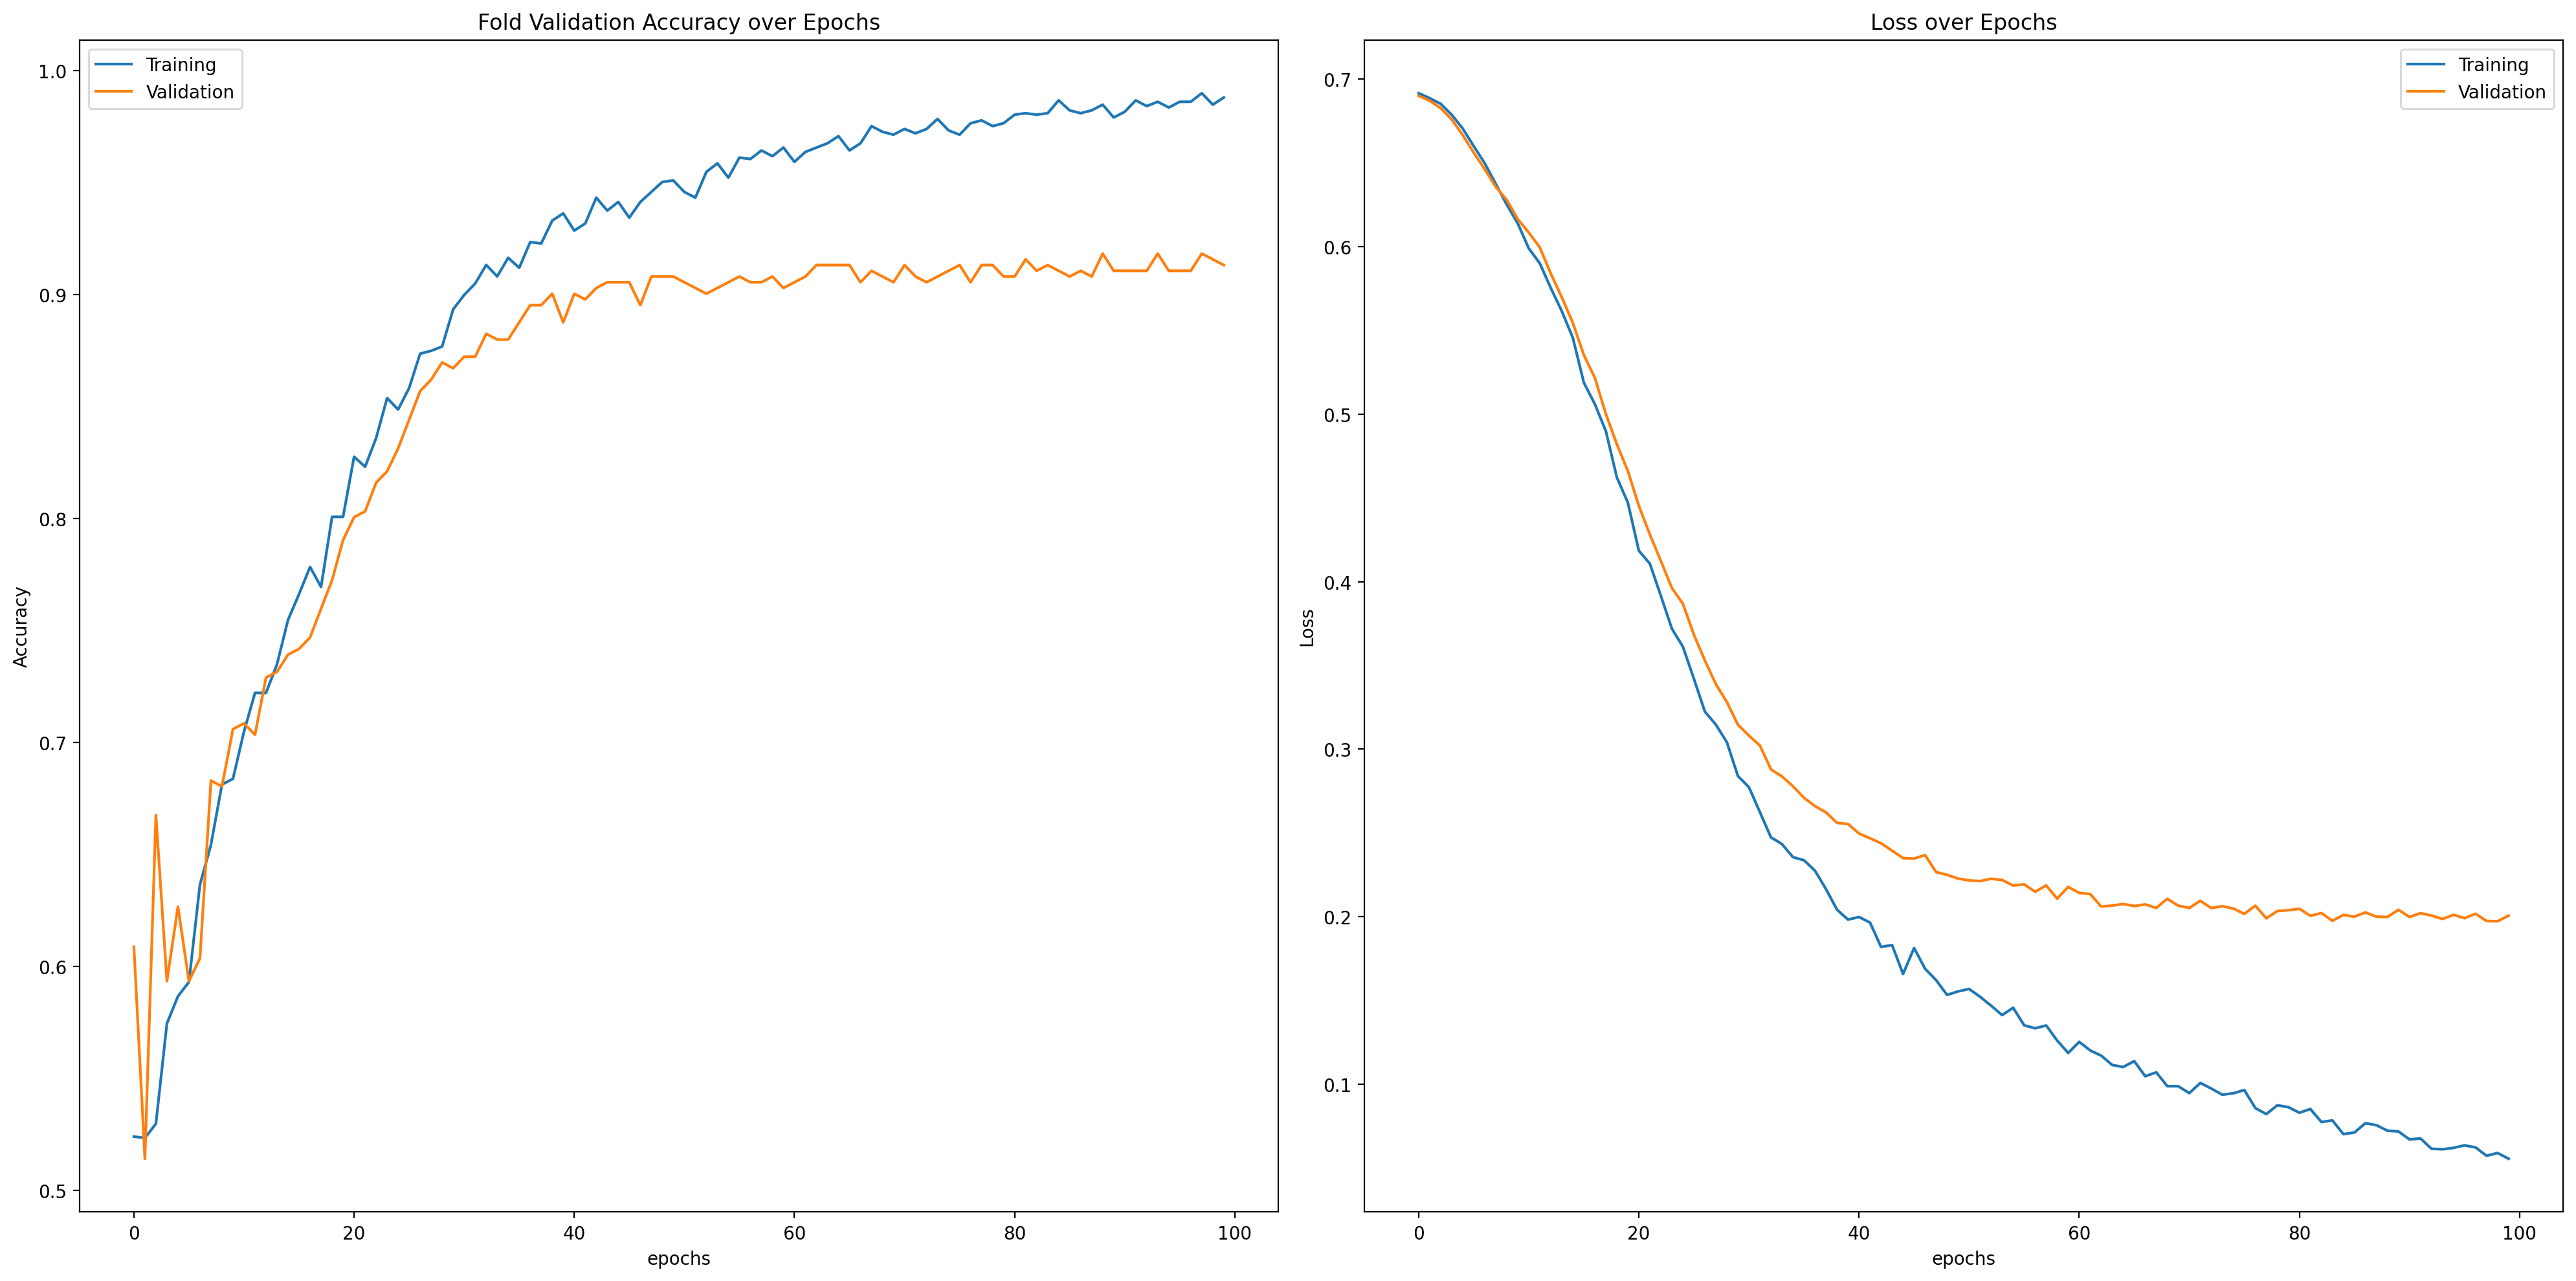

13/13 [==============================] - 0s 8ms/step
Fold validation accuracy: 0.9130434989929199
Average Accuracy: 0.9299506902694702


In [40]:
# the input is a list of integers, 500 long
sequence_input = Input(shape=(X.shape[1], ))

embedded_sequences = Embedding(
    len(word_index) + 1, EMBED_SIZE, weights=[embedding_matrix], input_length=max_length, 
    trainable=False)(sequence_input)

x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(32, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

# Just Mean Pooling but kernel size is the whole thing, leaves 64 results for each of the 64 filters.
x_mean = GlobalAveragePooling1D()(x)

# Both of these steps compute the Variance, results in 64 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])

x = Dense(32, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

cnn2 = Model(sequence_input, preds)
pred_cnn2, acc_cnn2 = test_model(X, labels, kf, cnn2, 1, "cnn2_predictions.csv", ep=100, bs=64, lr=0.0001)

### 2.2: Transformer and Modified Transformer

In [75]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) f
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, max_length, vocab_size, embed_dim, embedding_matrix, **kwargs):
        super().__init__()

        self.max_length = max_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embedding_matrix = embedding_matrix
        # one for processing the tokens (words)
        self.token_emb = Embedding(
            input_dim=vocab_size, output_dim=embed_dim, 
            weights=[embedding_matrix], input_length=max_length, 
            trainable=False)

        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=max_length, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

    def get_config(self):
        config = super().get_config()
        # Include layer-specific arguments that can be used for reconstructing the layer
        config.update({
            "max_length": self.max_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "embedding_matrix": self.embedding_matrix  # Don't save embedding matrix since it's not serializable
        })
        return config

Graph 1:


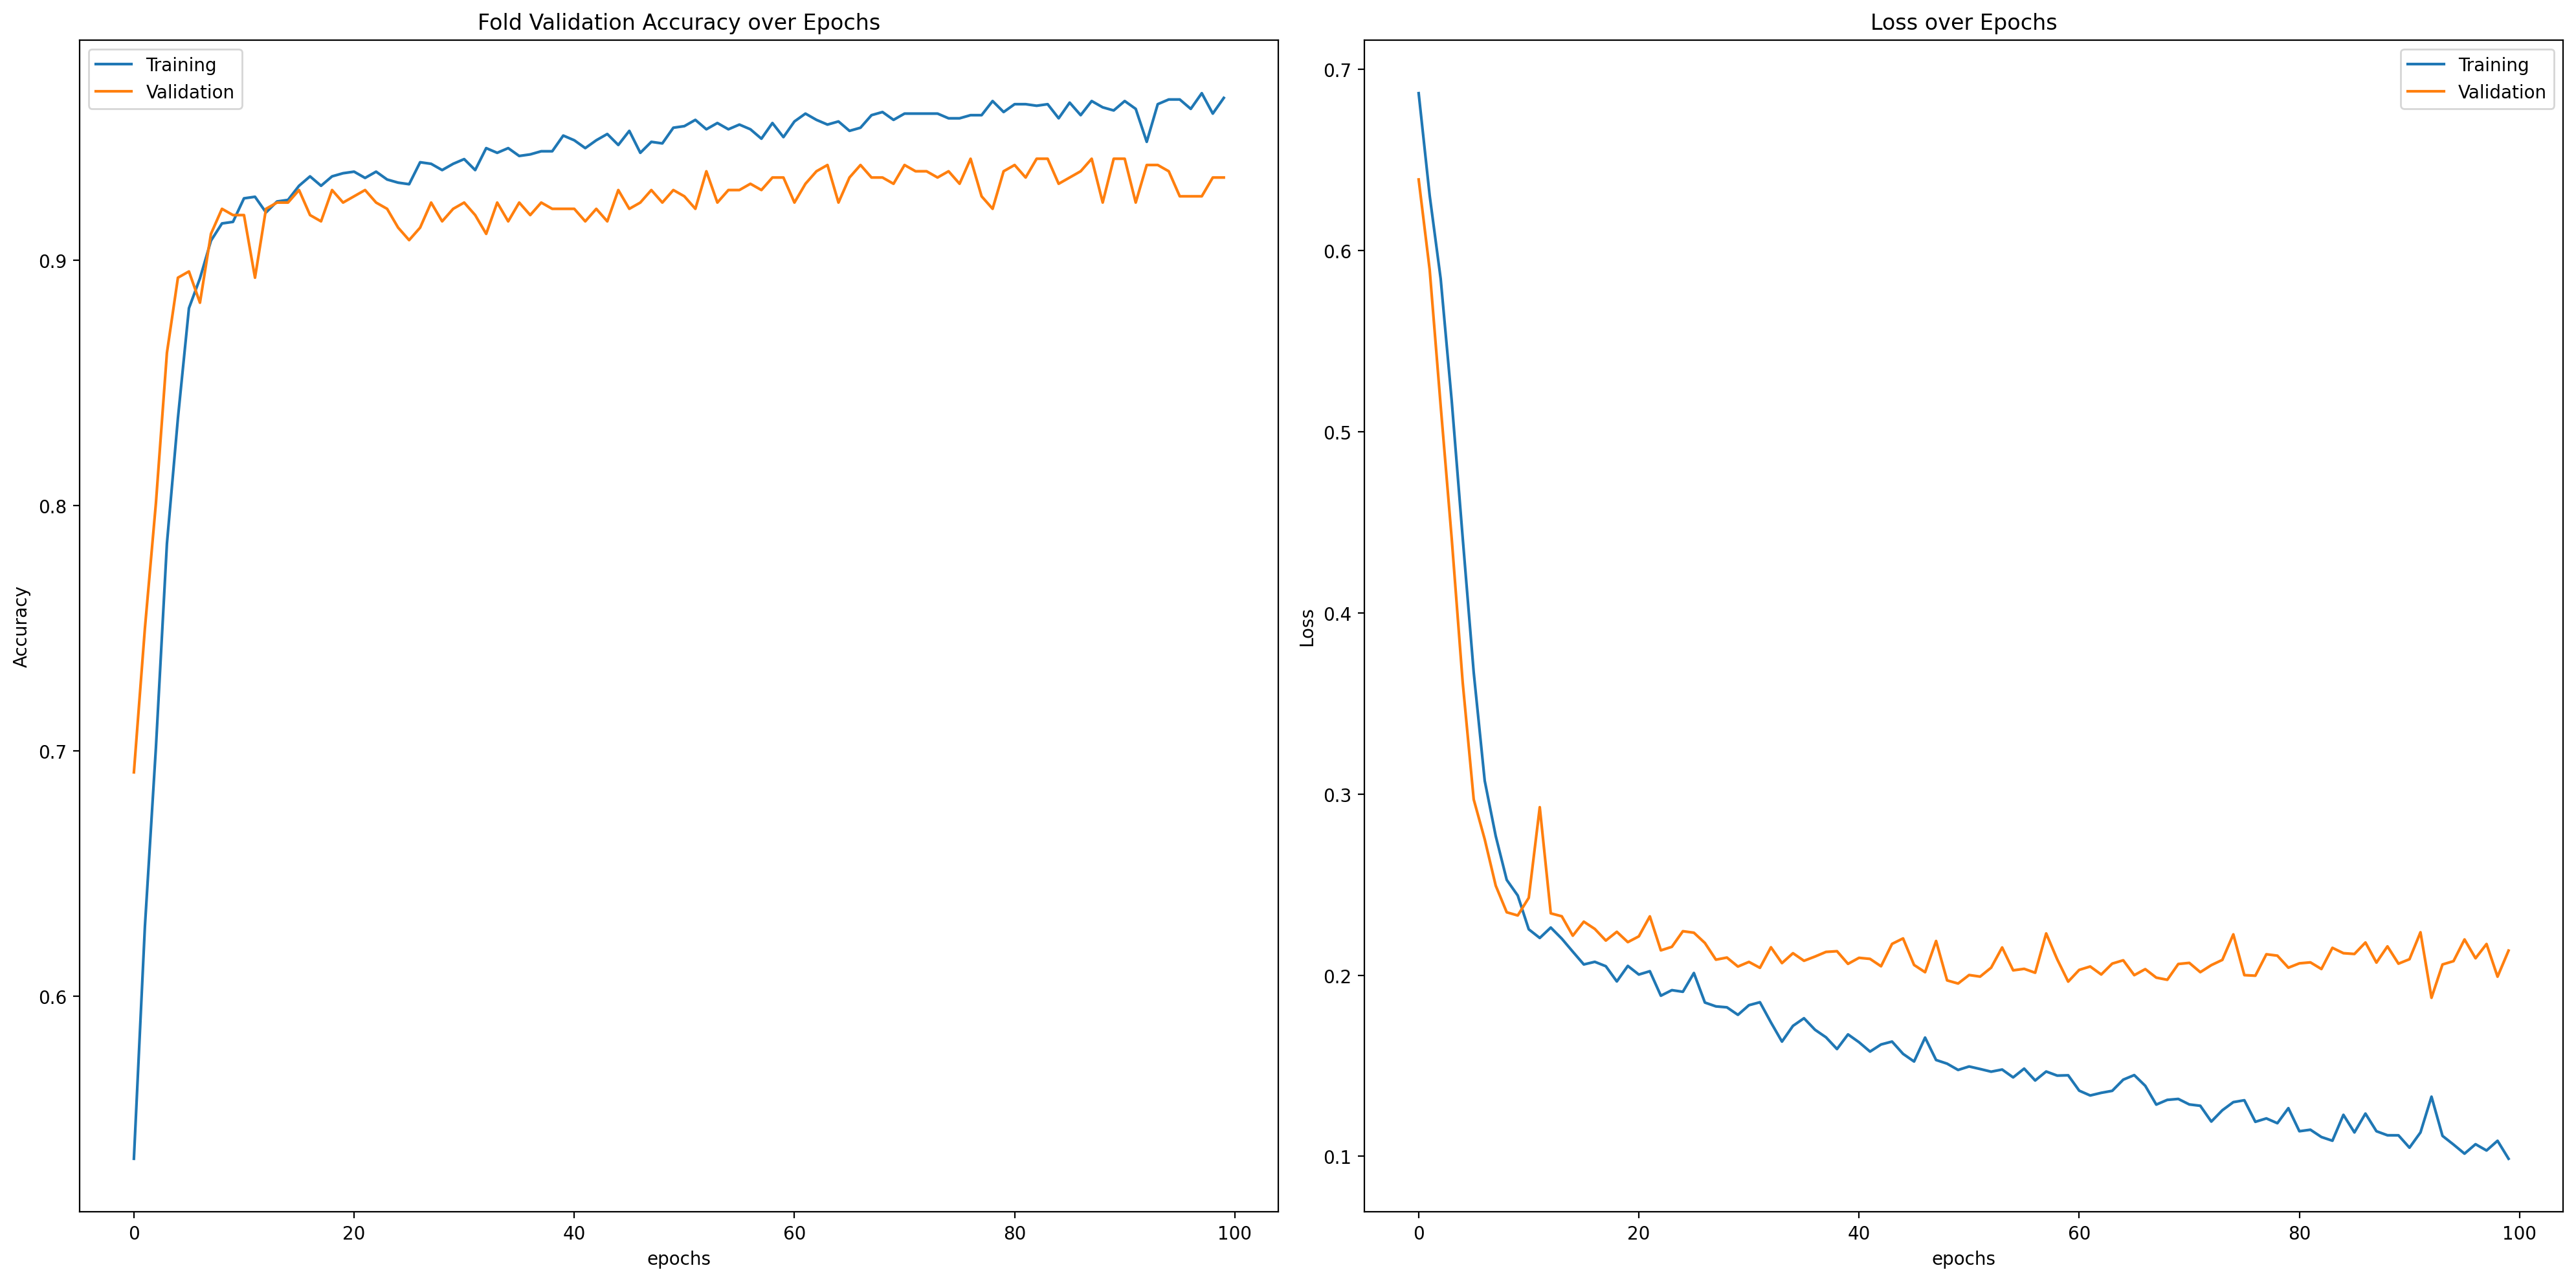

13/13 [==============================] - 1s 44ms/step
Fold validation accuracy: 0.9336734414100647
Graph 2:


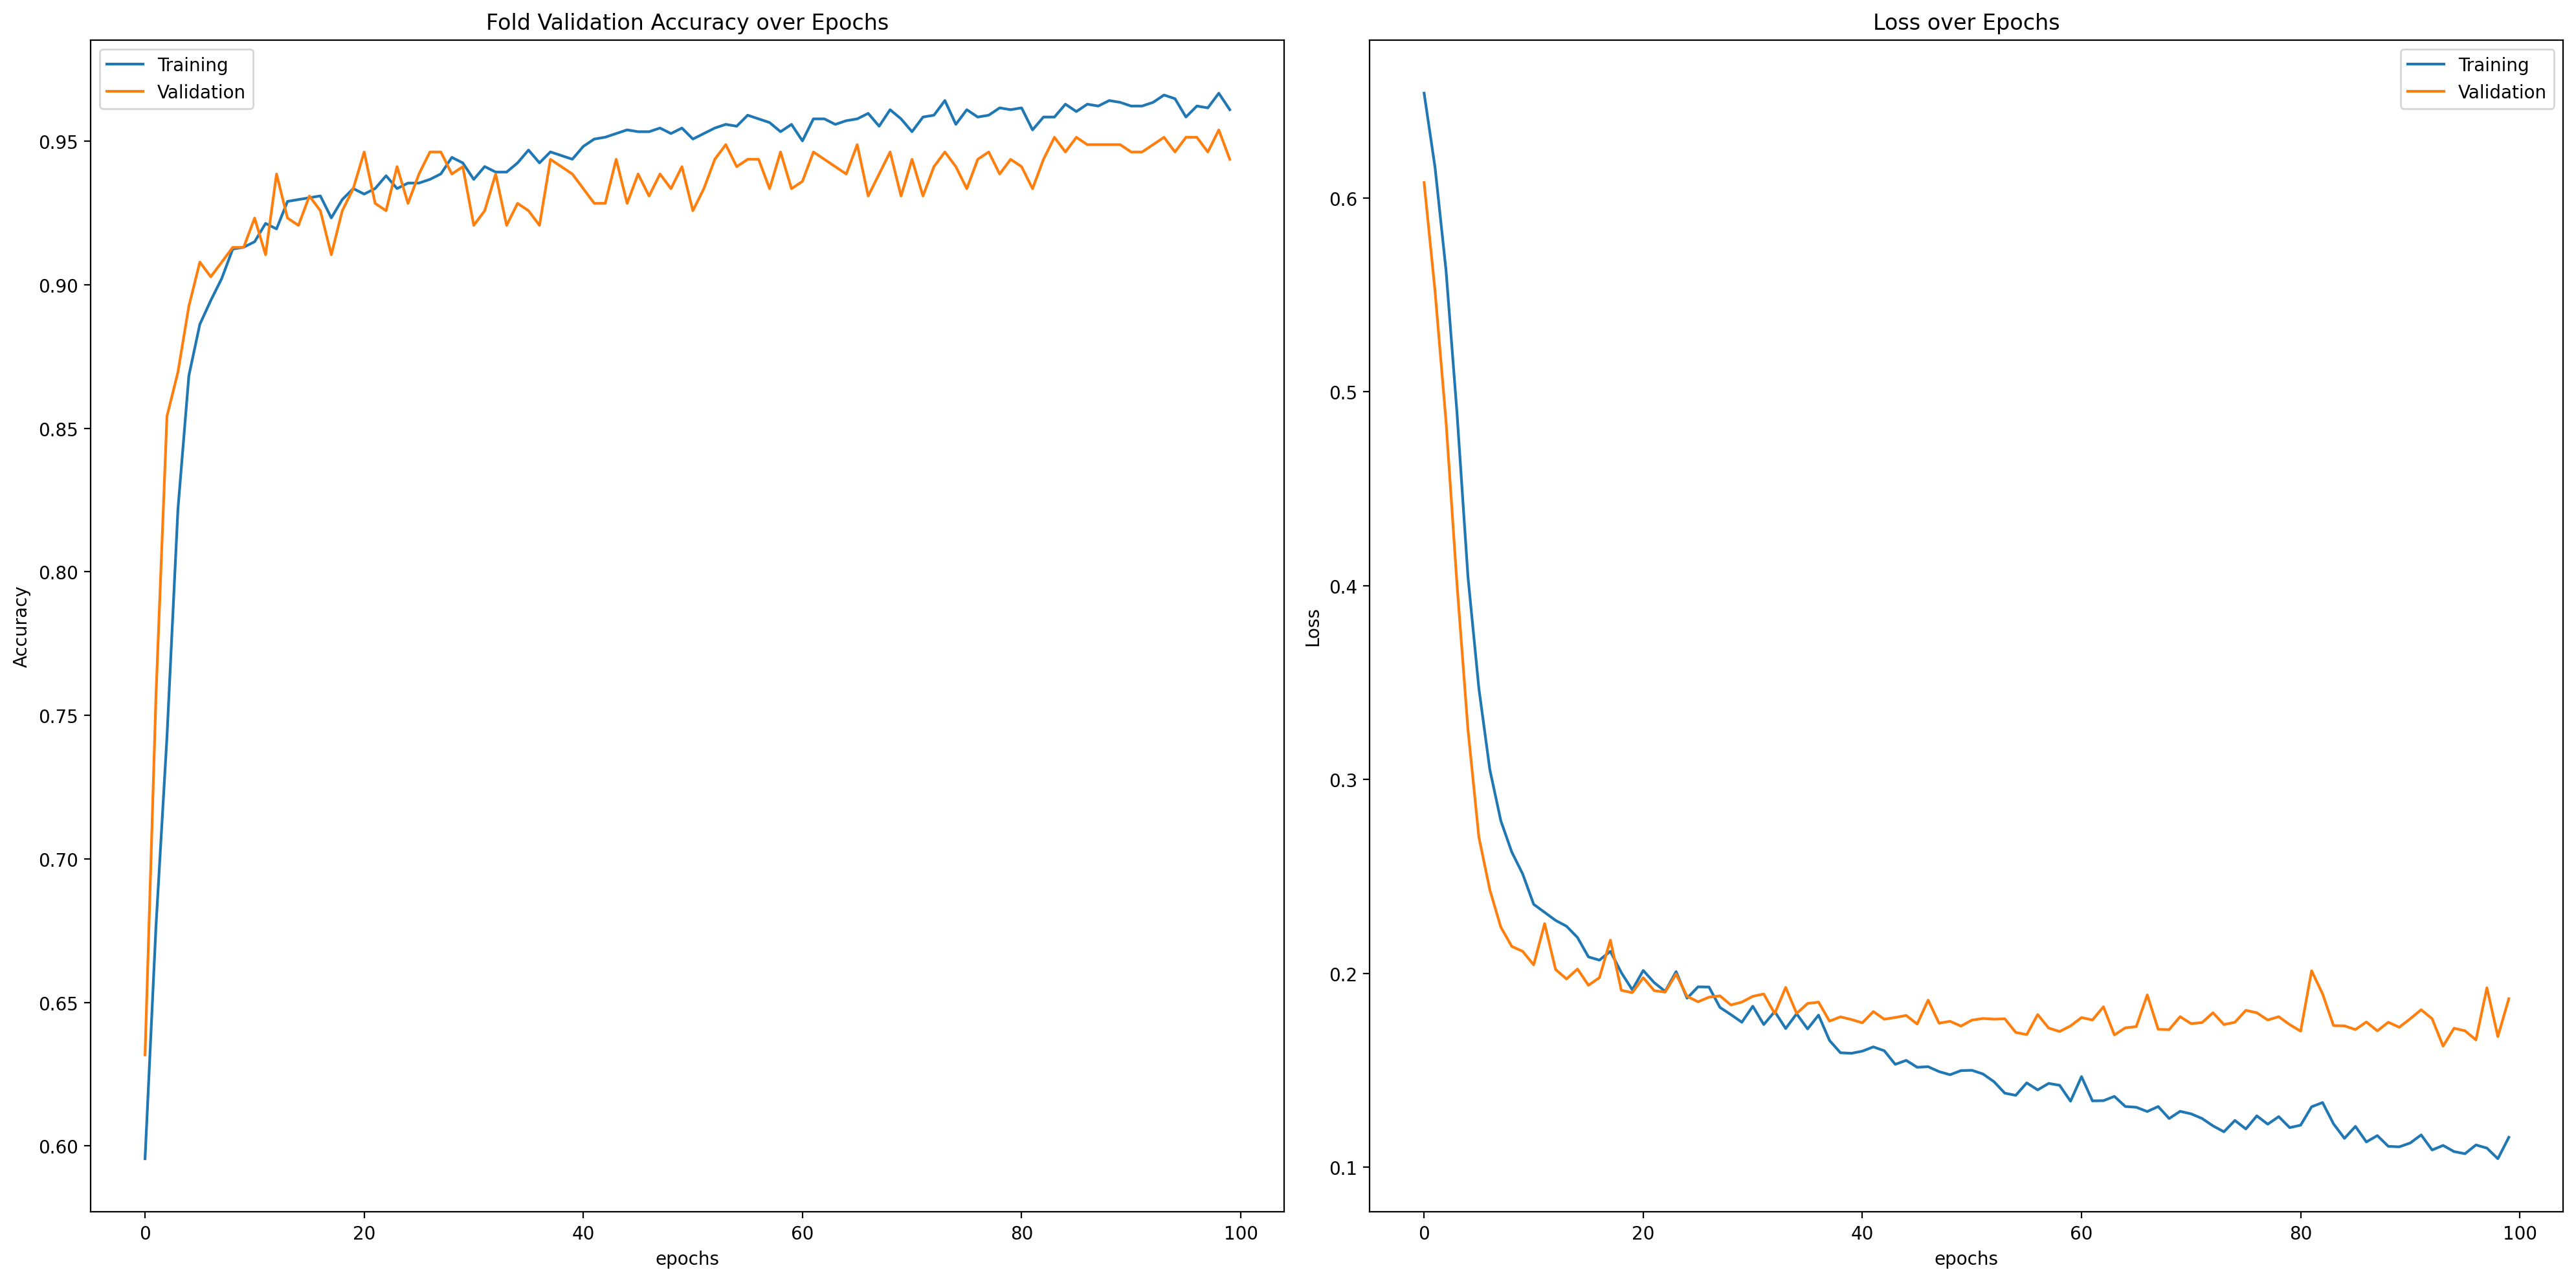

13/13 [==============================] - 1s 40ms/step
Fold validation accuracy: 0.9437339901924133
Graph 3:


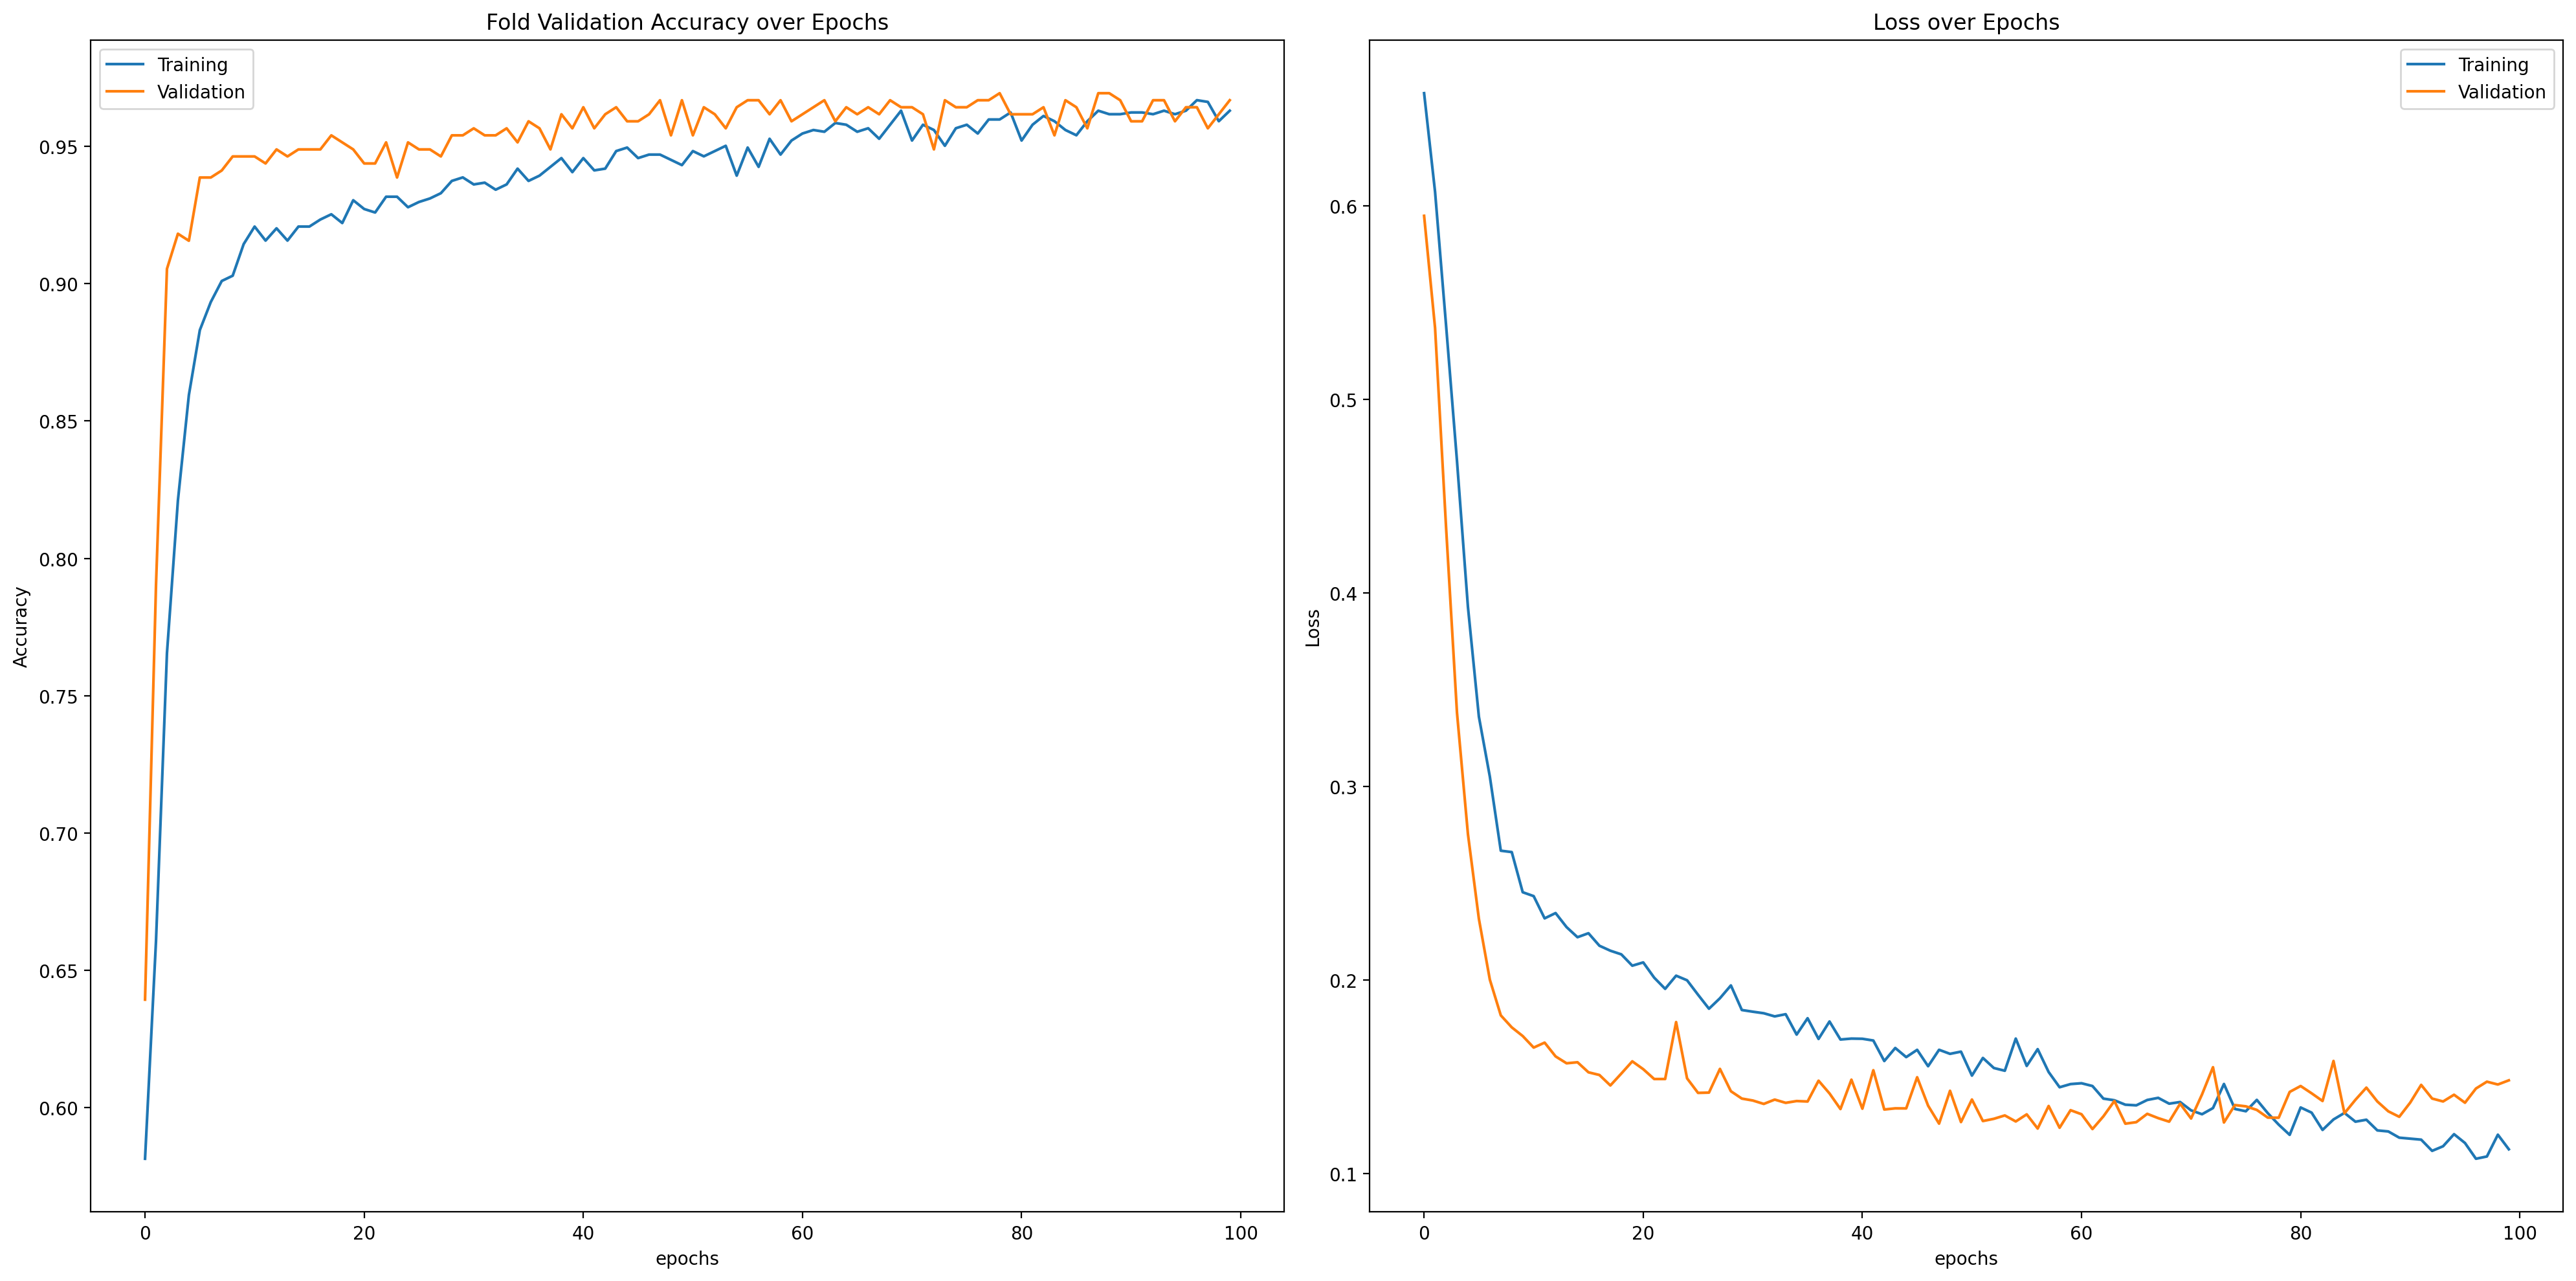

13/13 [==============================] - 1s 40ms/step
Fold validation accuracy: 0.9667519330978394
Graph 4:


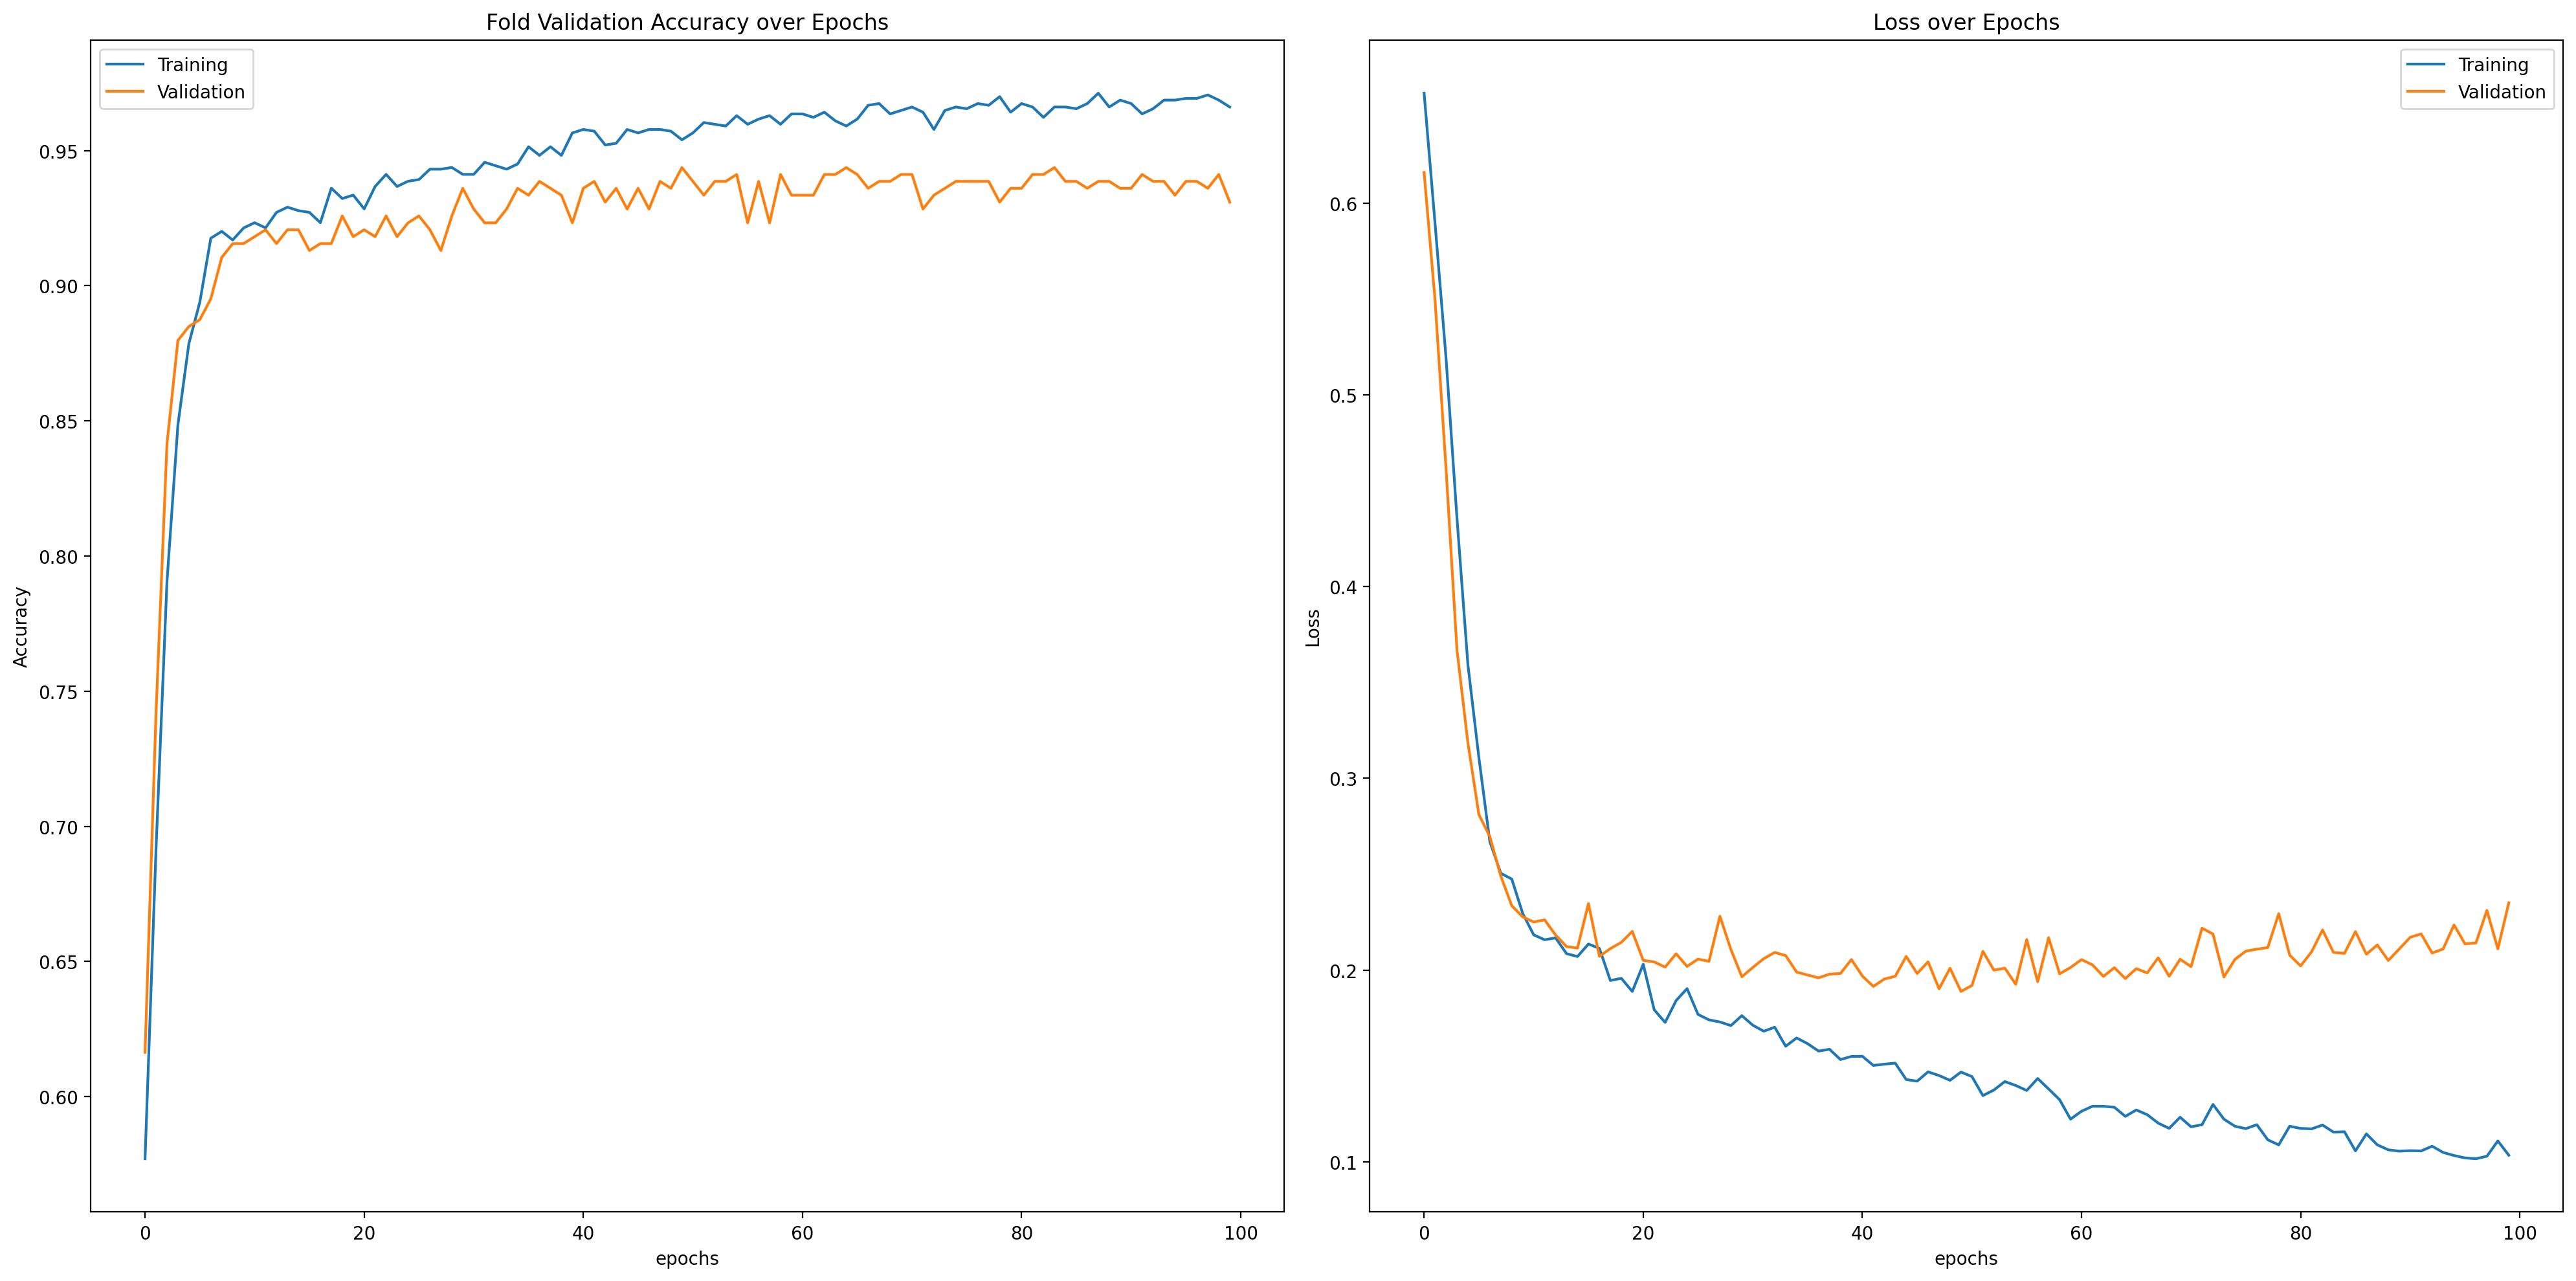

13/13 [==============================] - 1s 44ms/step
Fold validation accuracy: 0.9309462904930115
Graph 5:


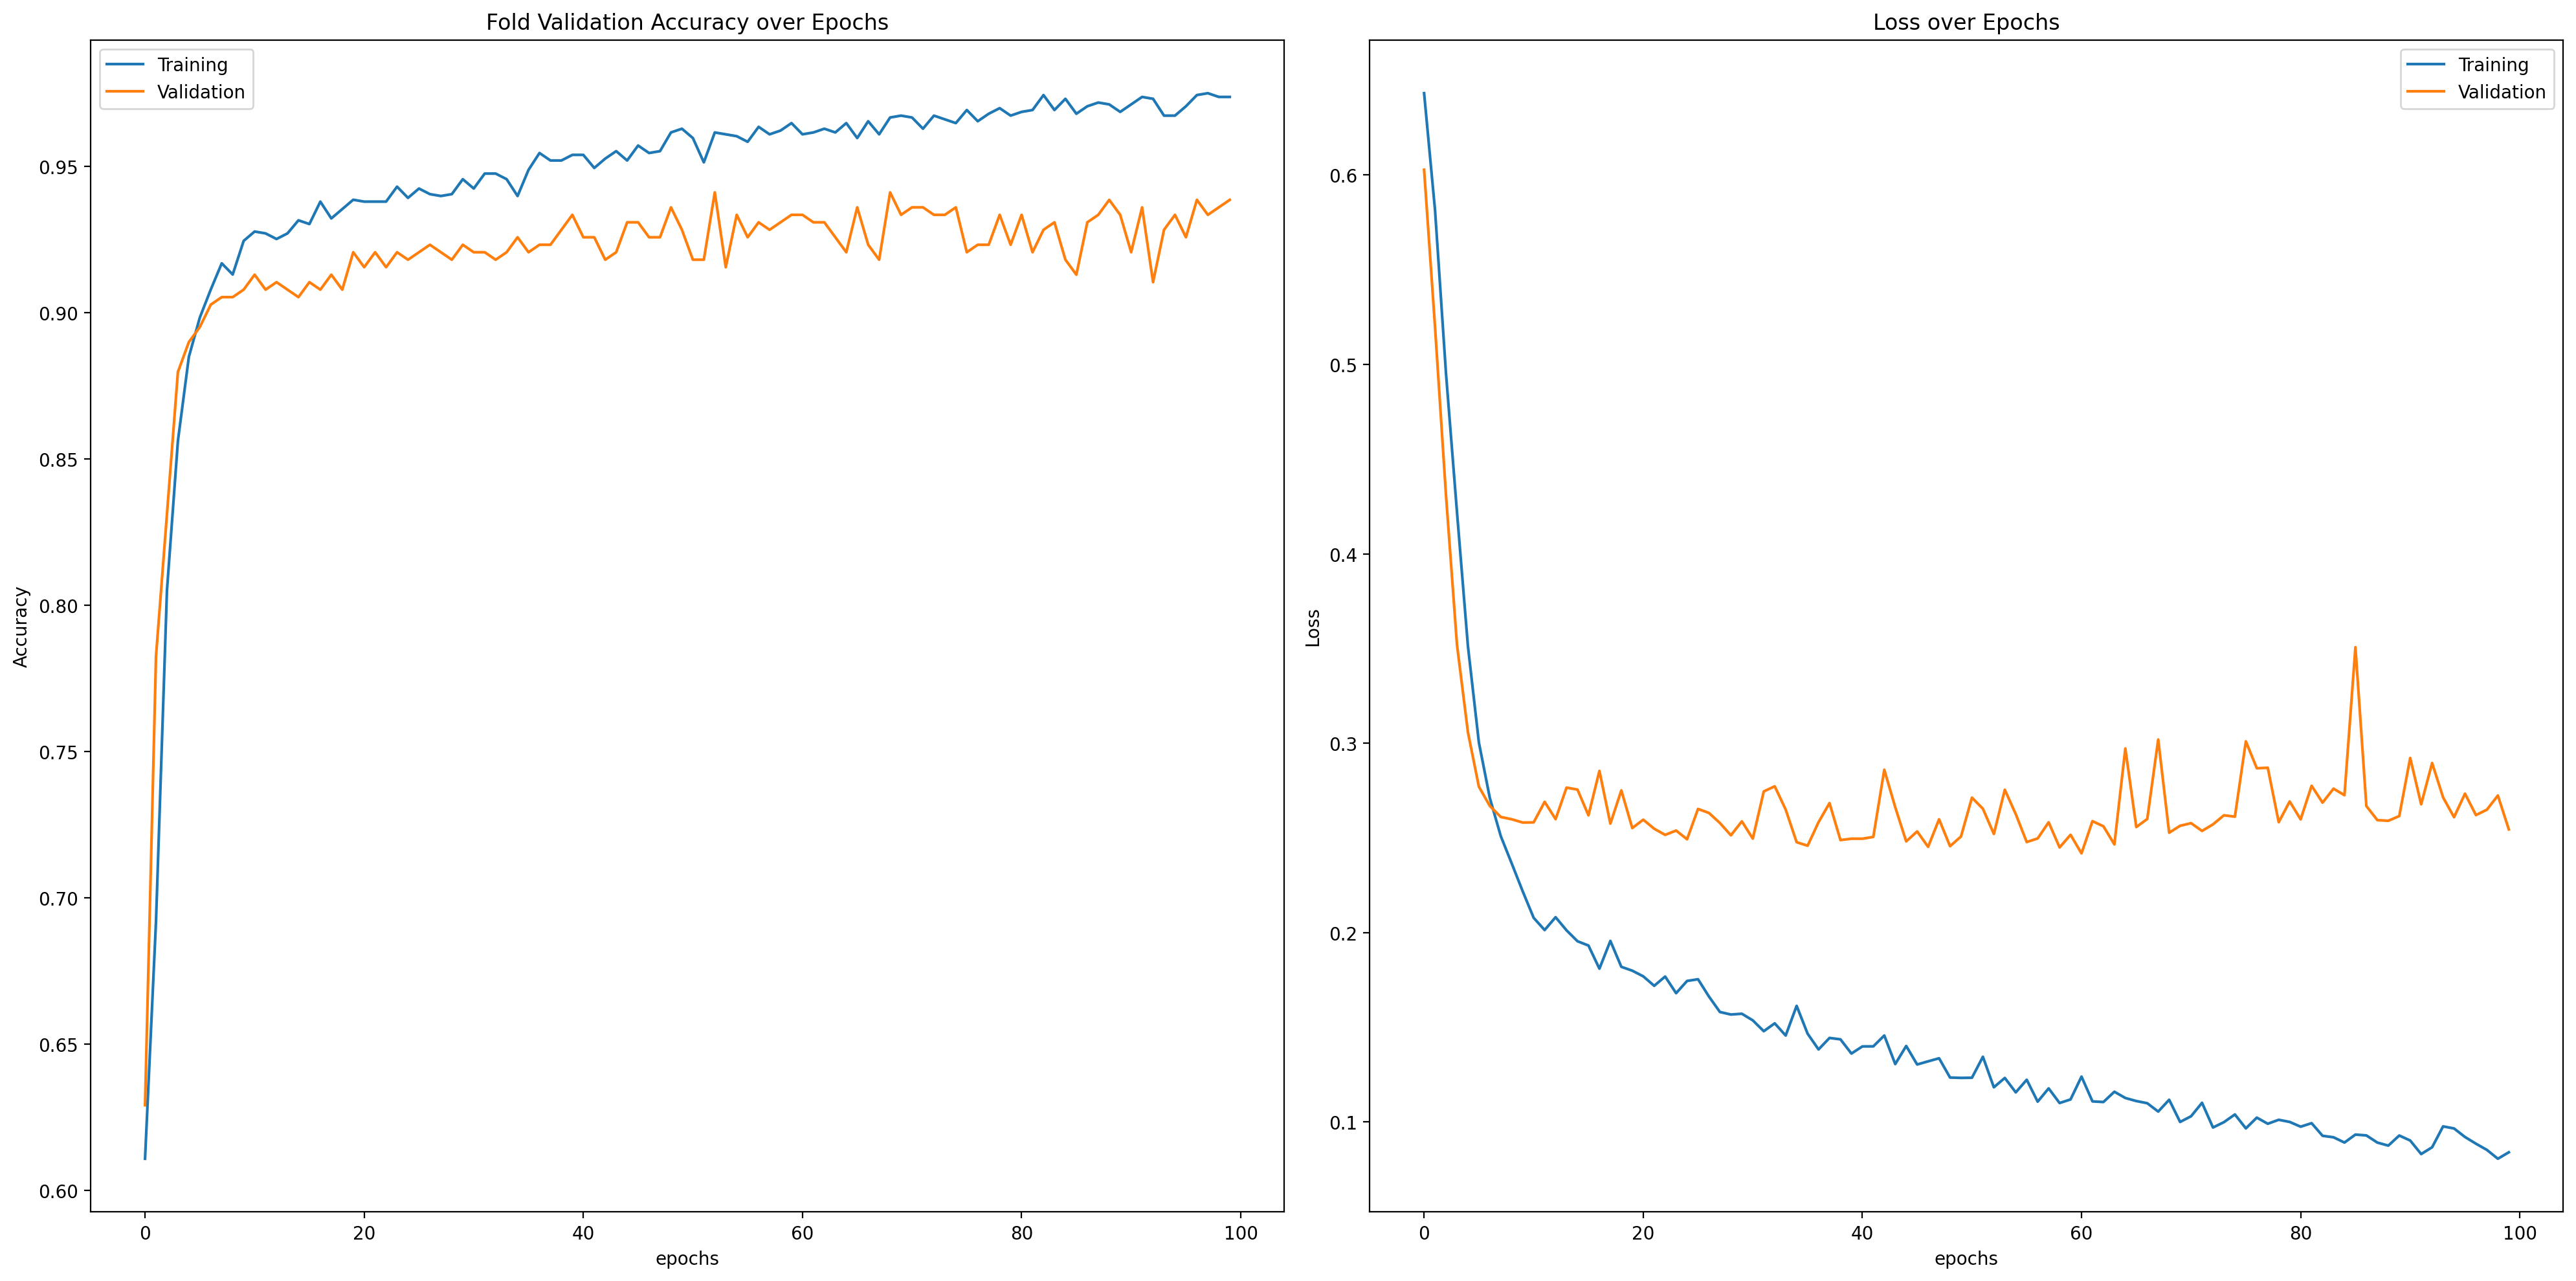

13/13 [==============================] - 1s 44ms/step
Fold validation accuracy: 0.9386188983917236
Average Accuracy: 0.9427449107170105


In [77]:
num_words = 4952
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X.shape[1],))
x = TokenAndPositionEmbedding(X.shape[1], num_words, EMBED_SIZE, embedding_matrix)(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

trans1 = Model(inputs=inputs, outputs=outputs)
pred_trans1, acc_trans1 = test_model(X, labels, kf, trans1, 1, "trans1_predictions.csv", ep=100, bs=64, lr=0.0001)

For the modified Transformer, we changed the number of attention heads in the Multi-headed self attention layer from 1 to 3. We also changed the hidden layer size in the feed forward network inside the transformer from 32 to 48.

Graph 1:


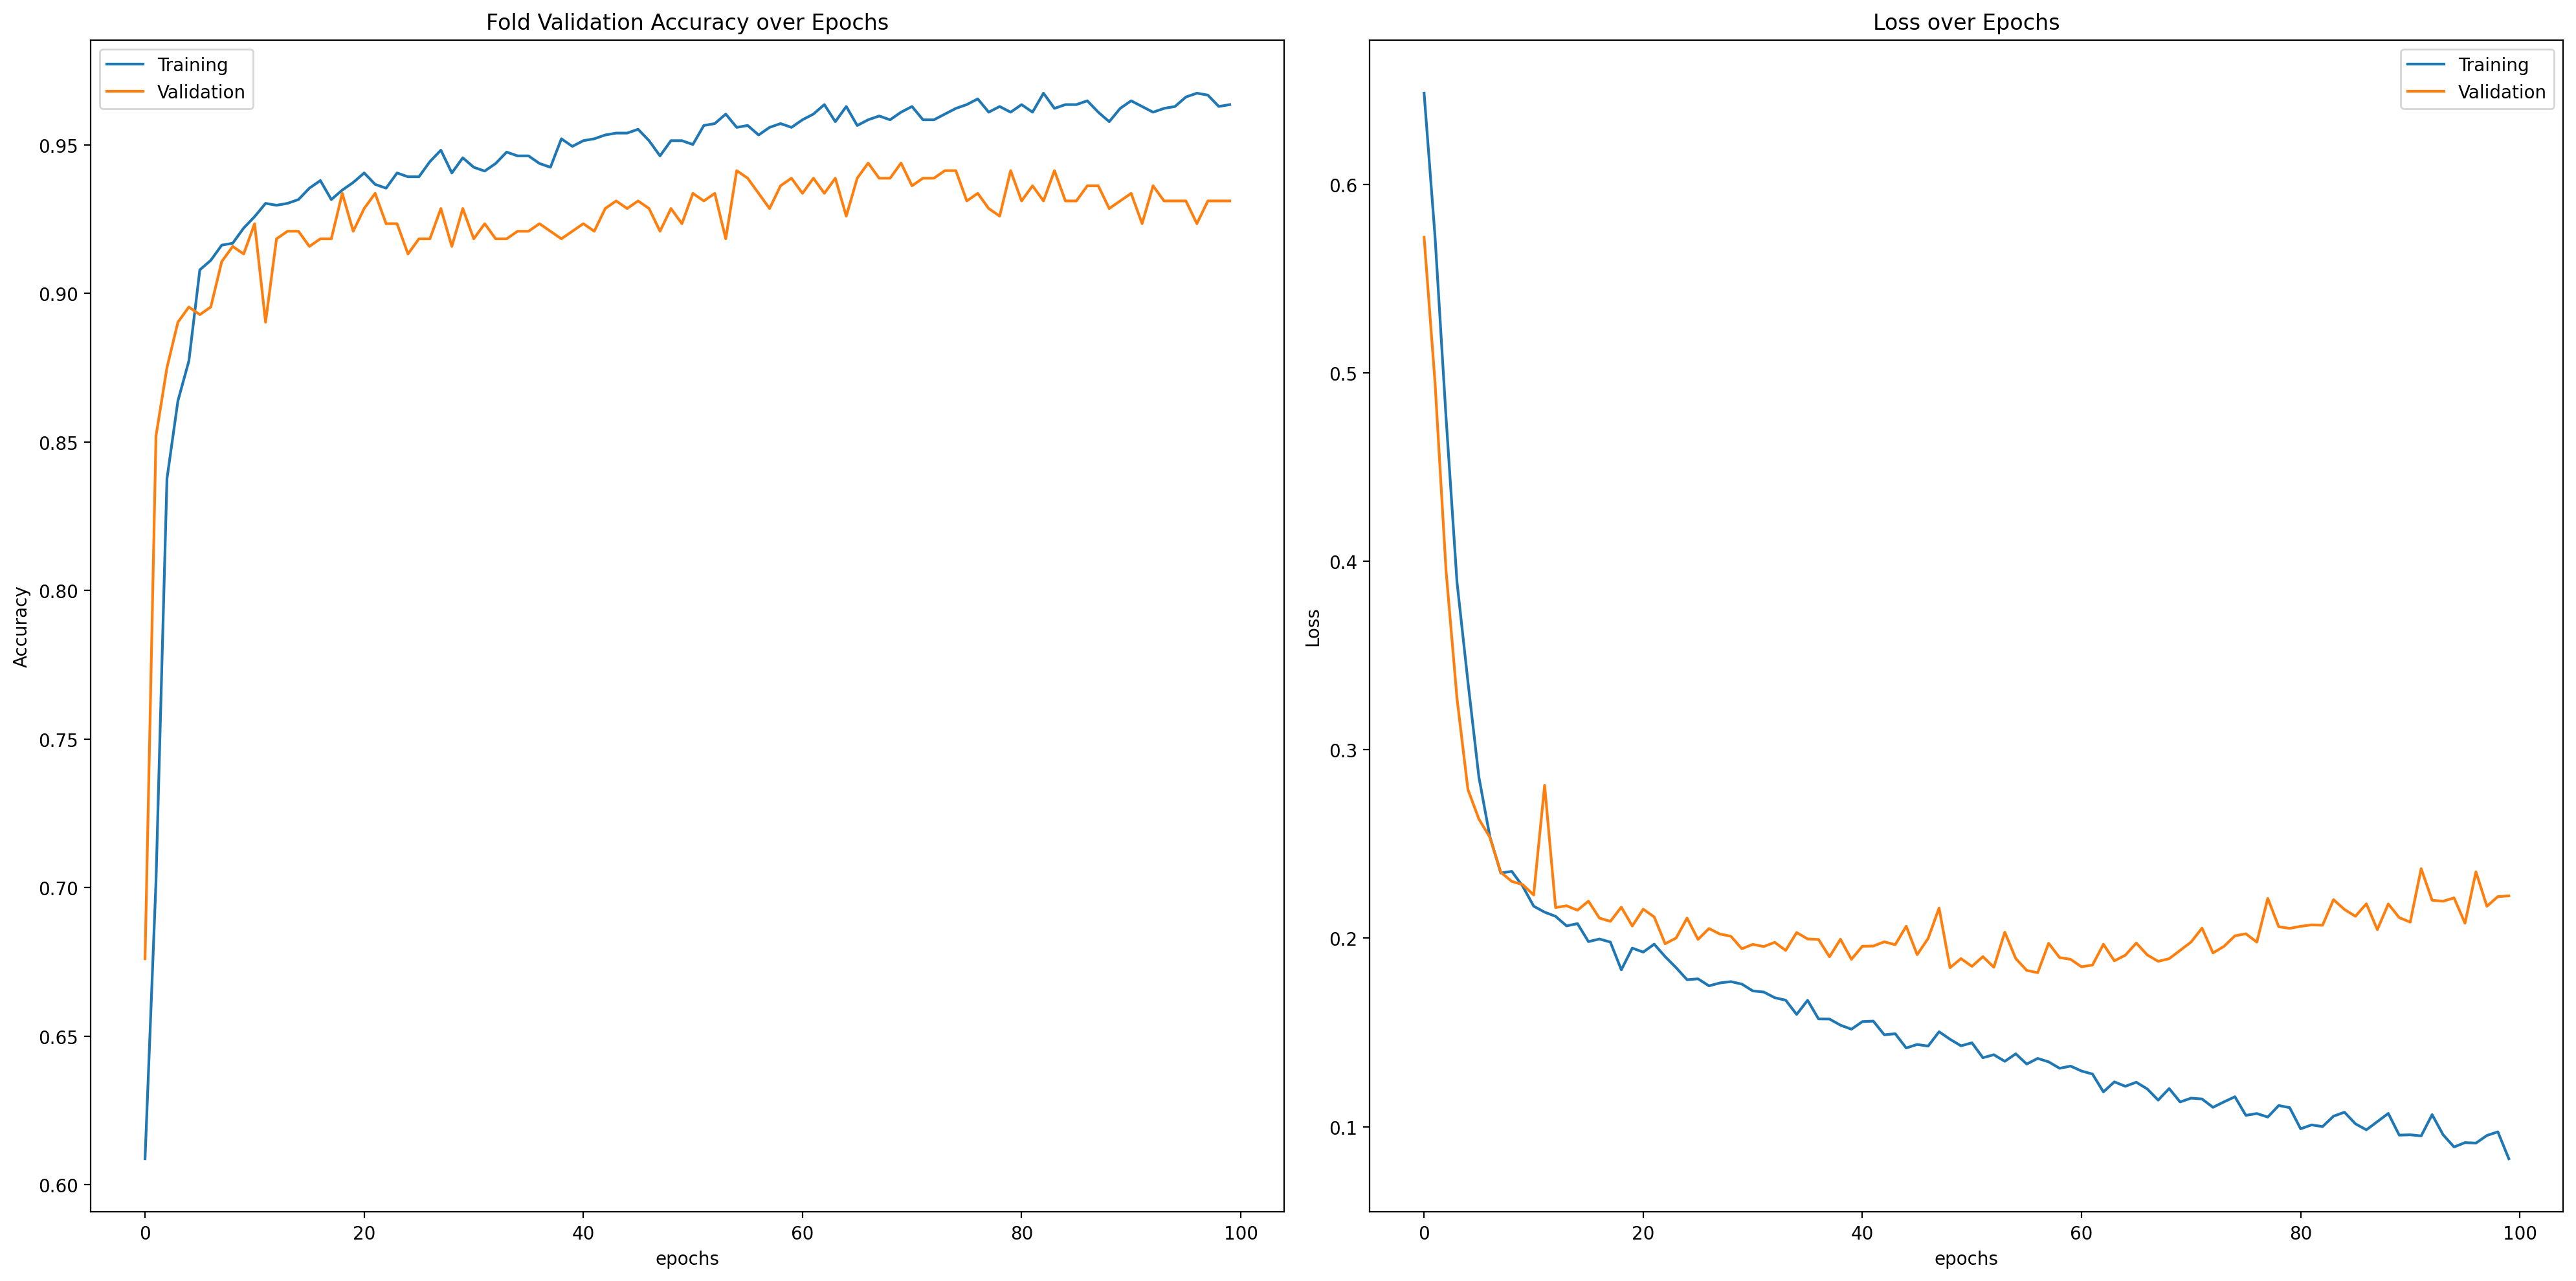

13/13 [==============================] - 1s 50ms/step
Fold validation accuracy: 0.9311224222183228
Graph 2:


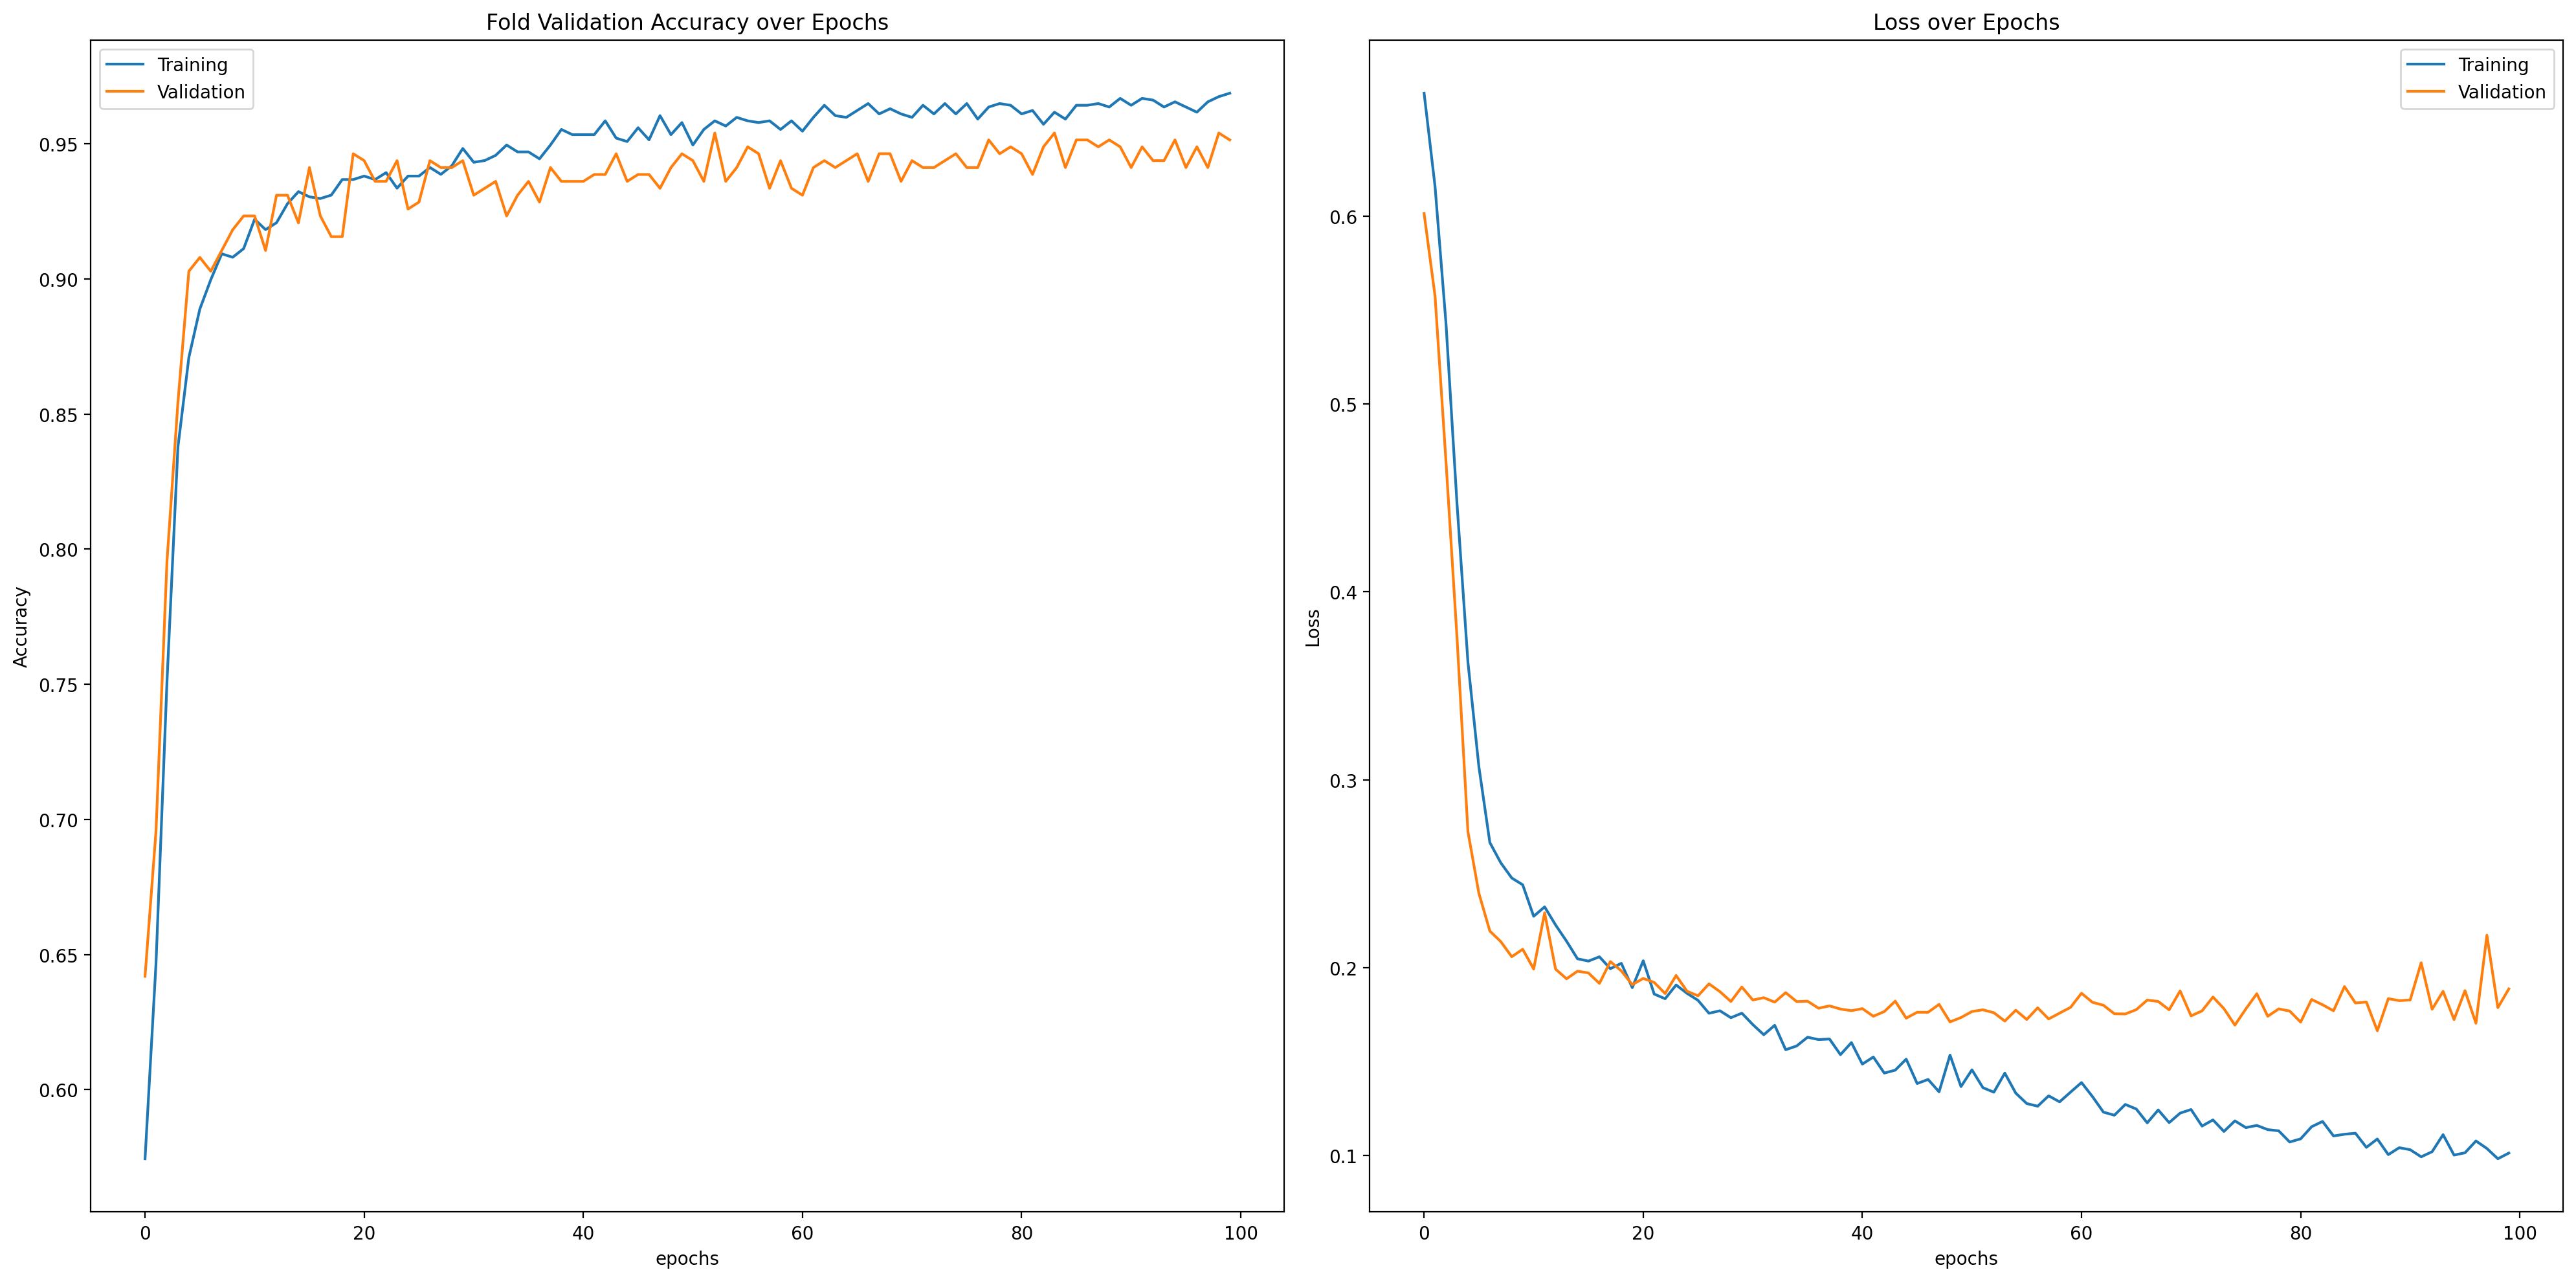

13/13 [==============================] - 1s 47ms/step
Fold validation accuracy: 0.9514066576957703
Graph 3:


In [ ]:
num_words = 4952
num_heads = 3  # Number of attention heads
ff_dim = 48  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X.shape[1],))
x = TokenAndPositionEmbedding(X.shape[1], num_words, EMBED_SIZE, embedding_matrix)(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

trans2 = Model(inputs=inputs, outputs=outputs)
pred_trans2, acc_trans2 = test_model(X, labels, kf, trans2, 1, "trans2_predictions.csv", ep=100, bs=64, lr=0.0001)

In [74]:
# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=max_length,
                            trainable=False)

### Saved Outputs just in case

Graph 1:


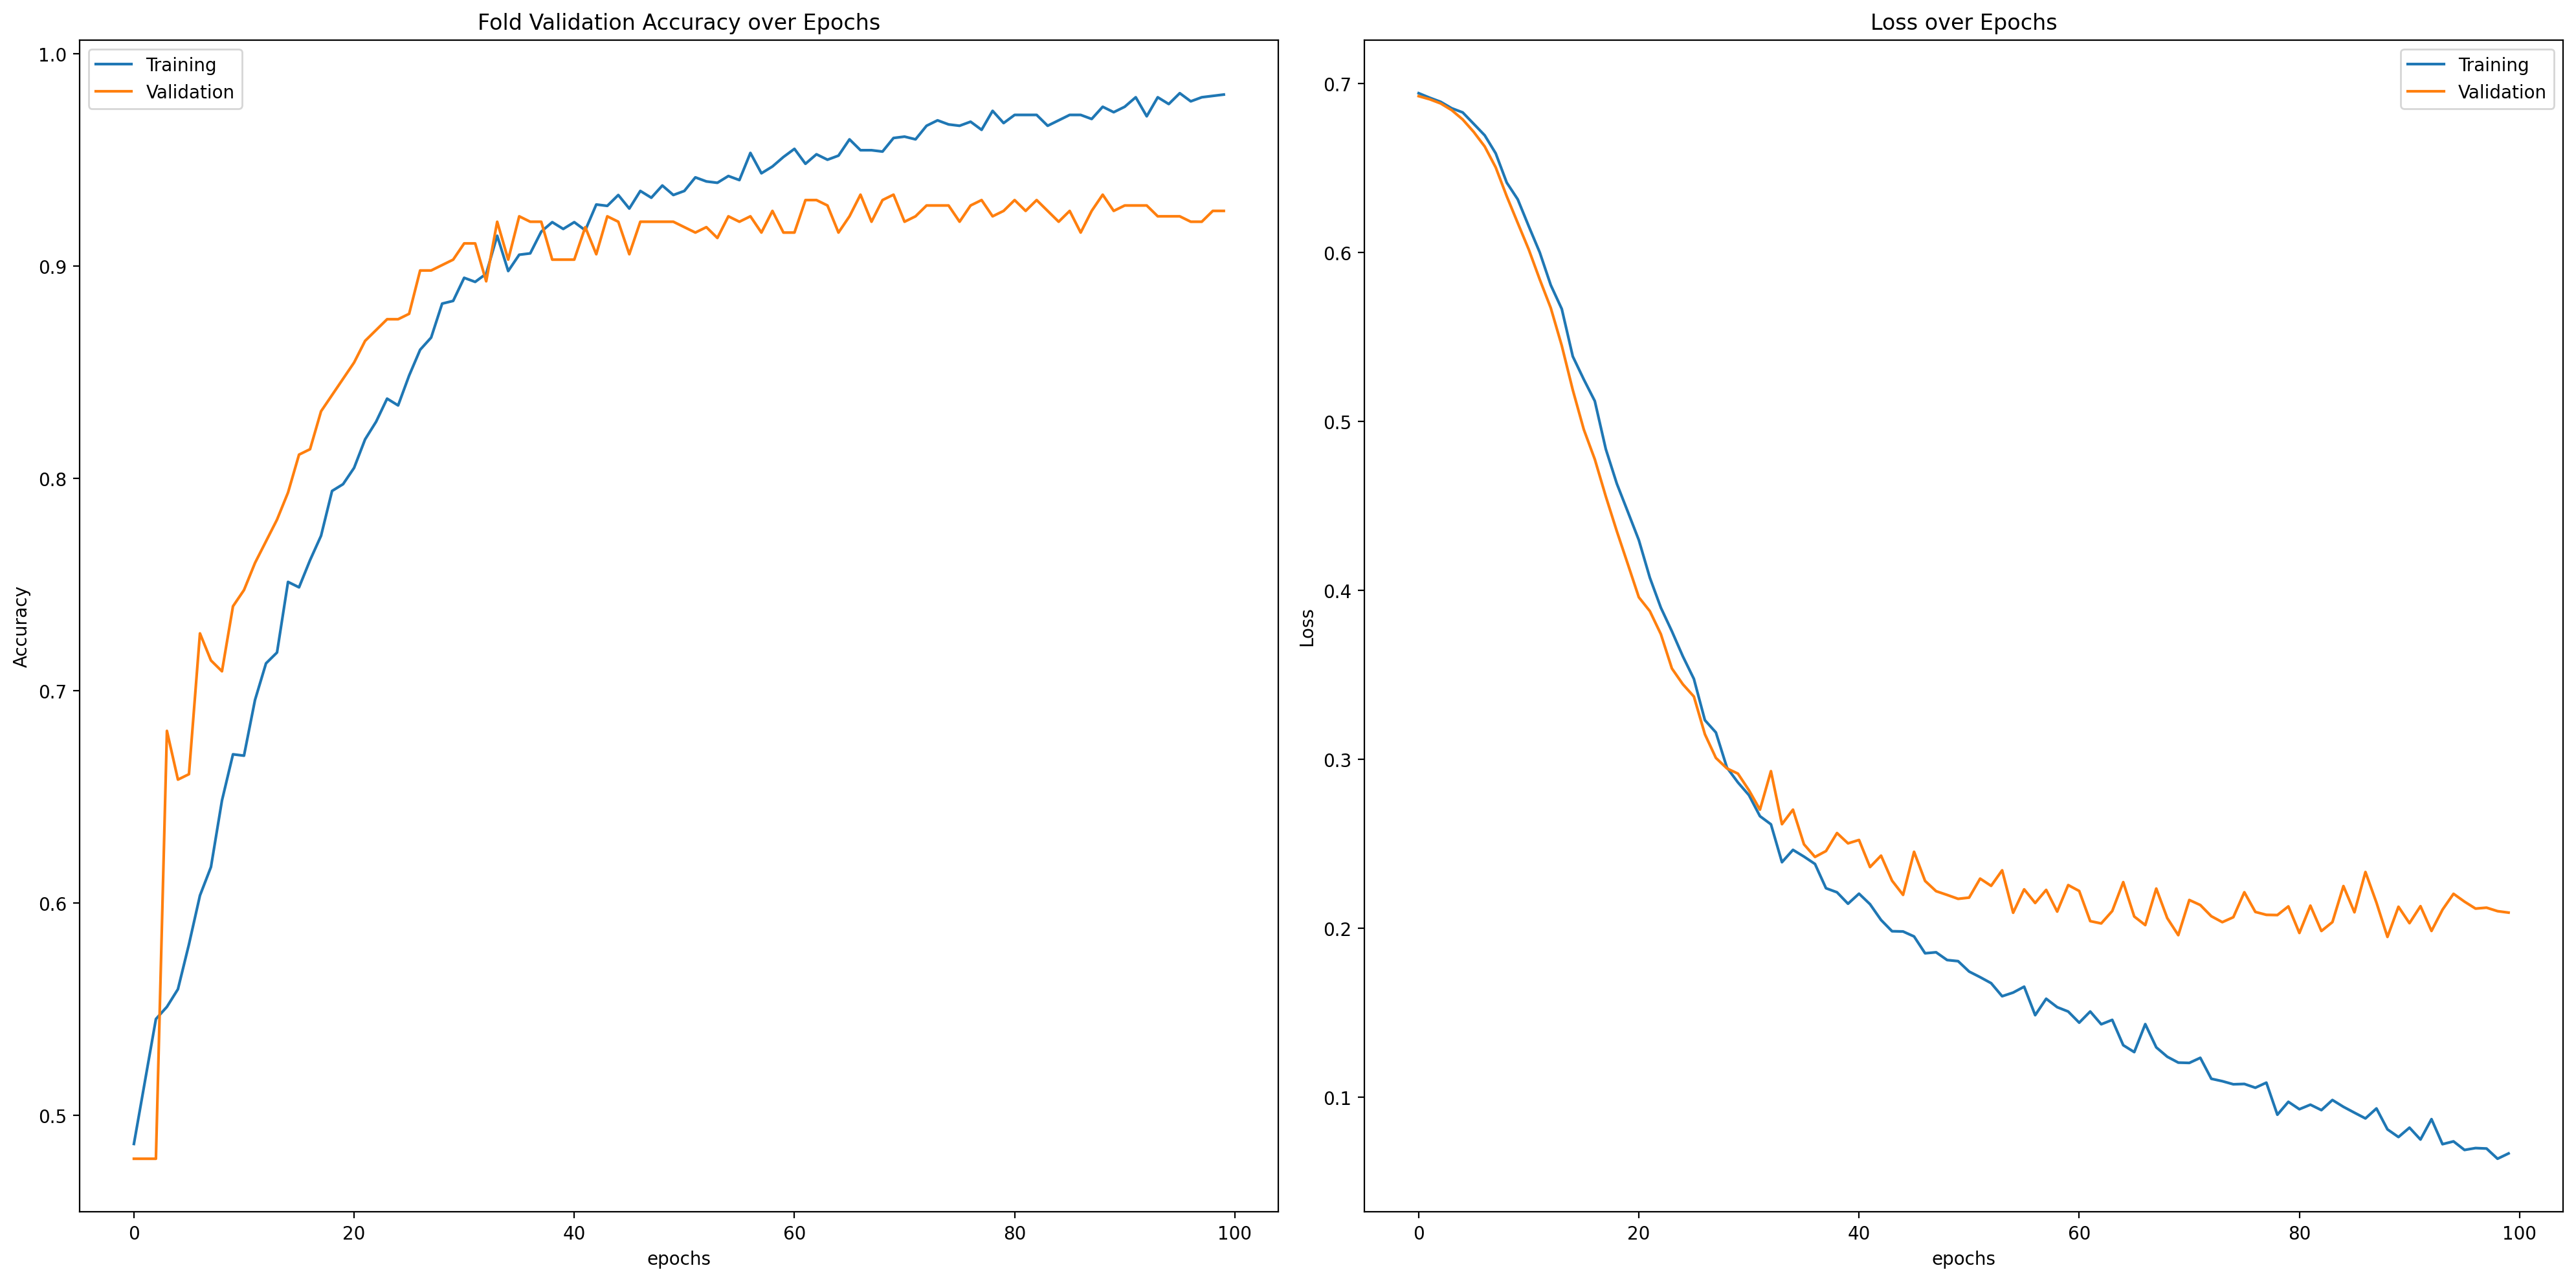

13/13 [==============================] - 0s 8ms/step
Fold validation accuracy: 0.9260203838348389
Graph 2:


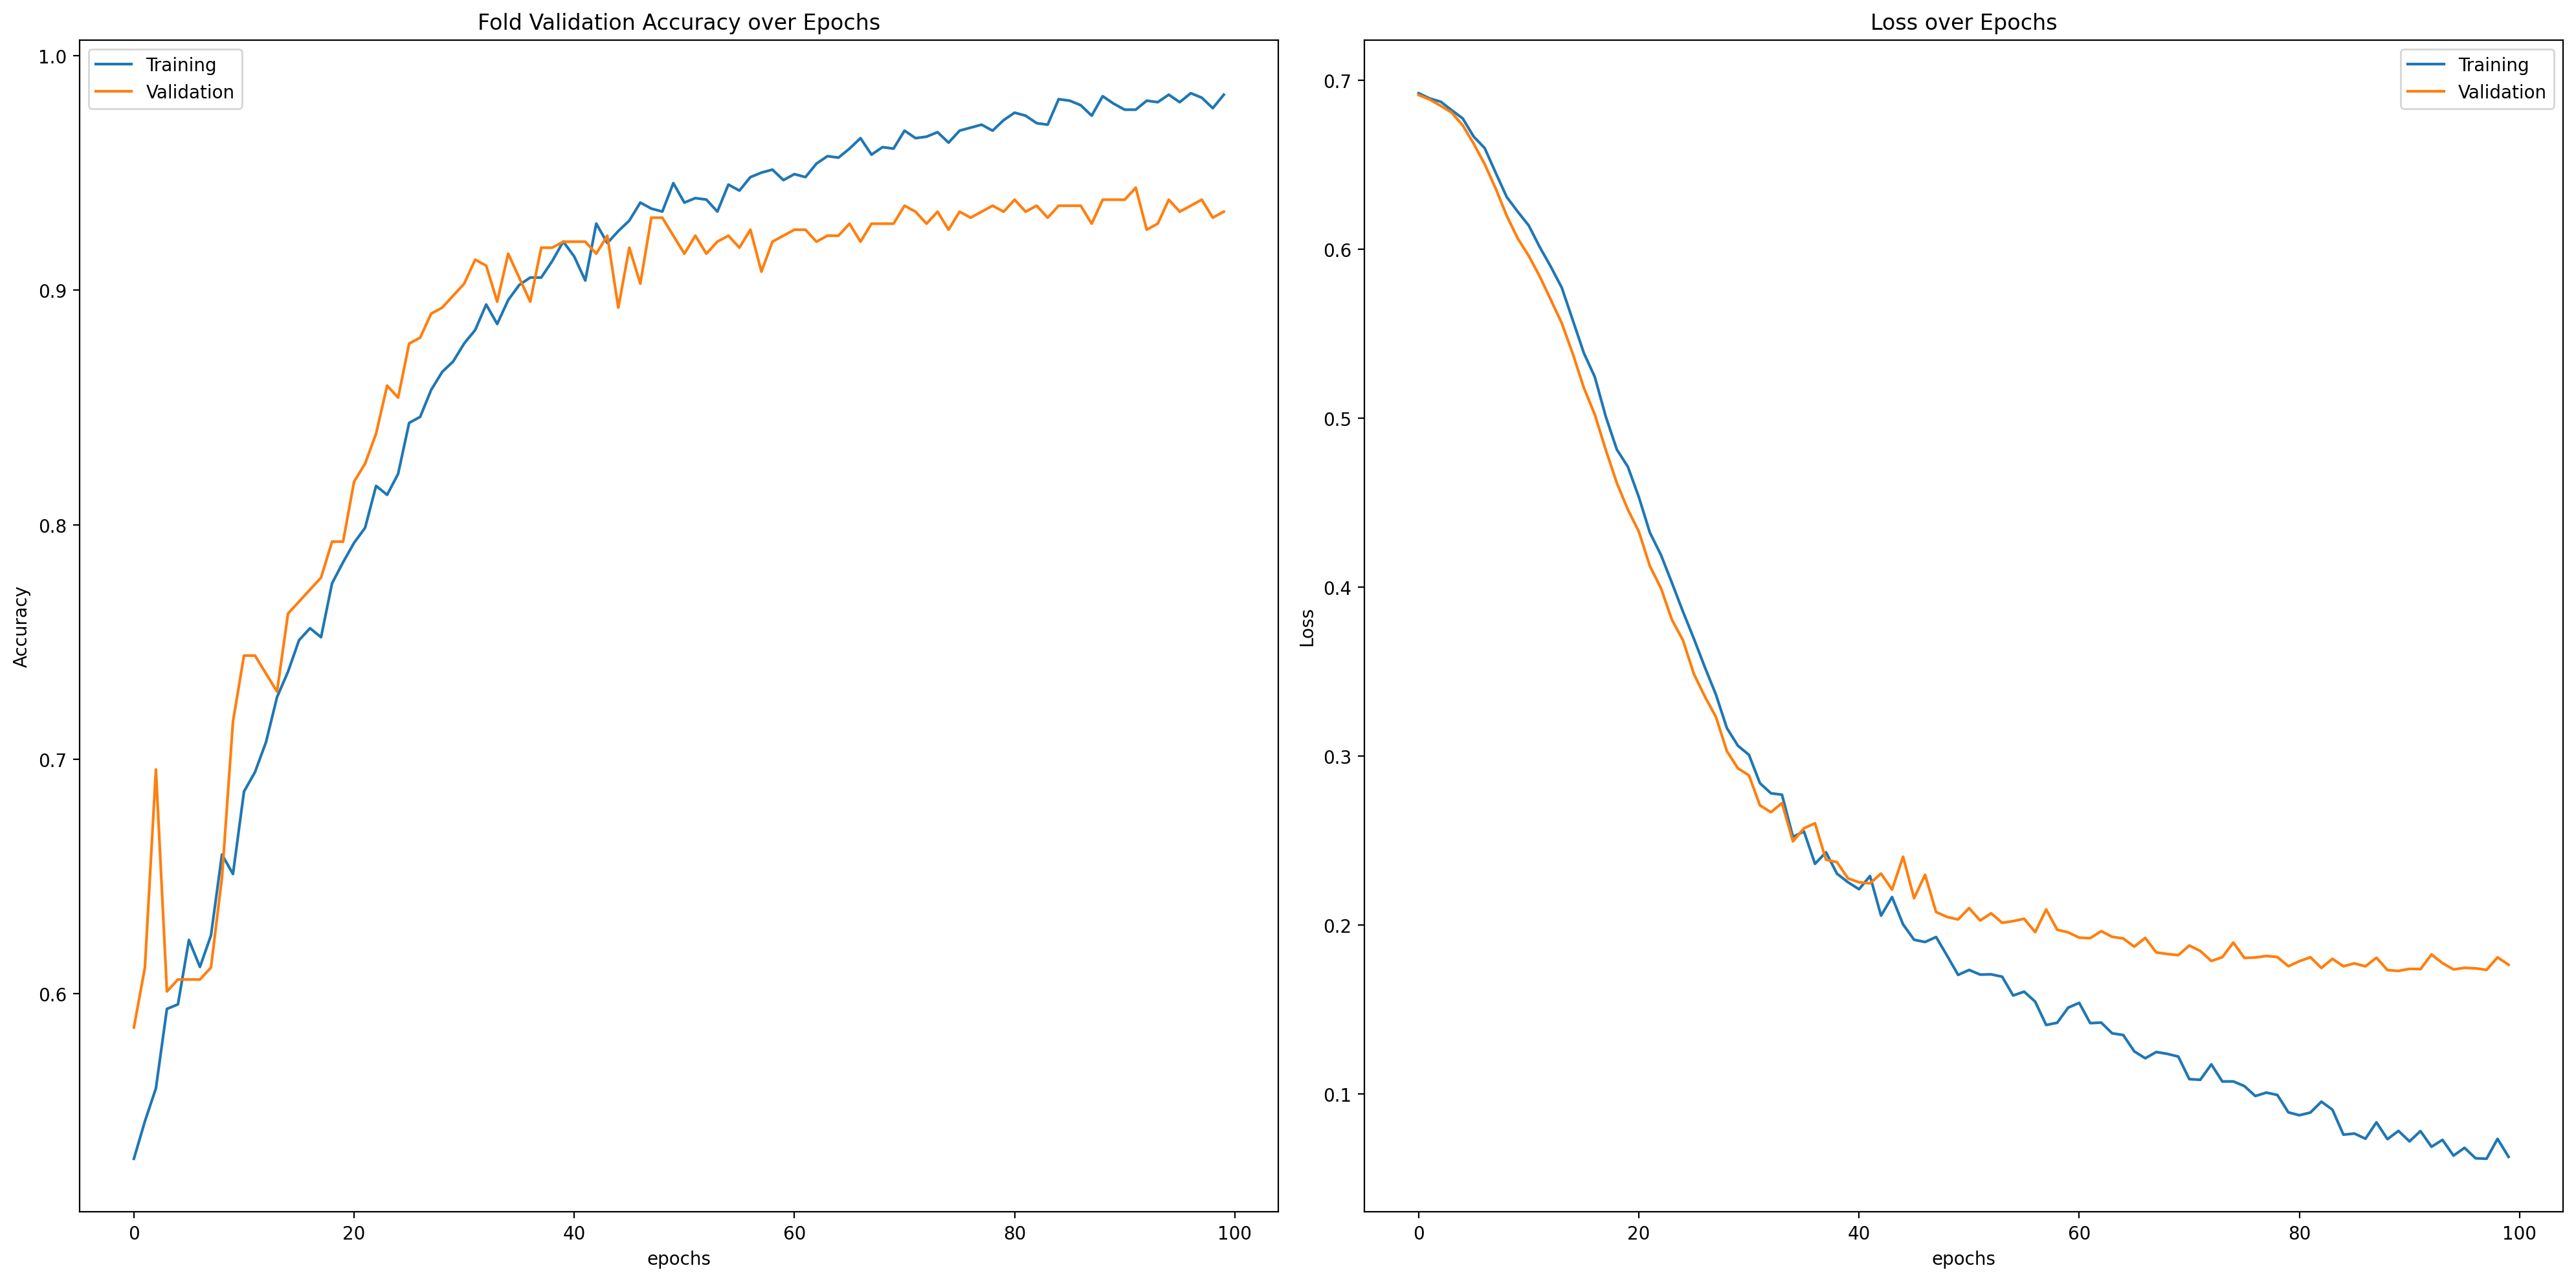

13/13 [==============================] - 0s 7ms/step
Fold validation accuracy: 0.9335038065910339
Graph 3:


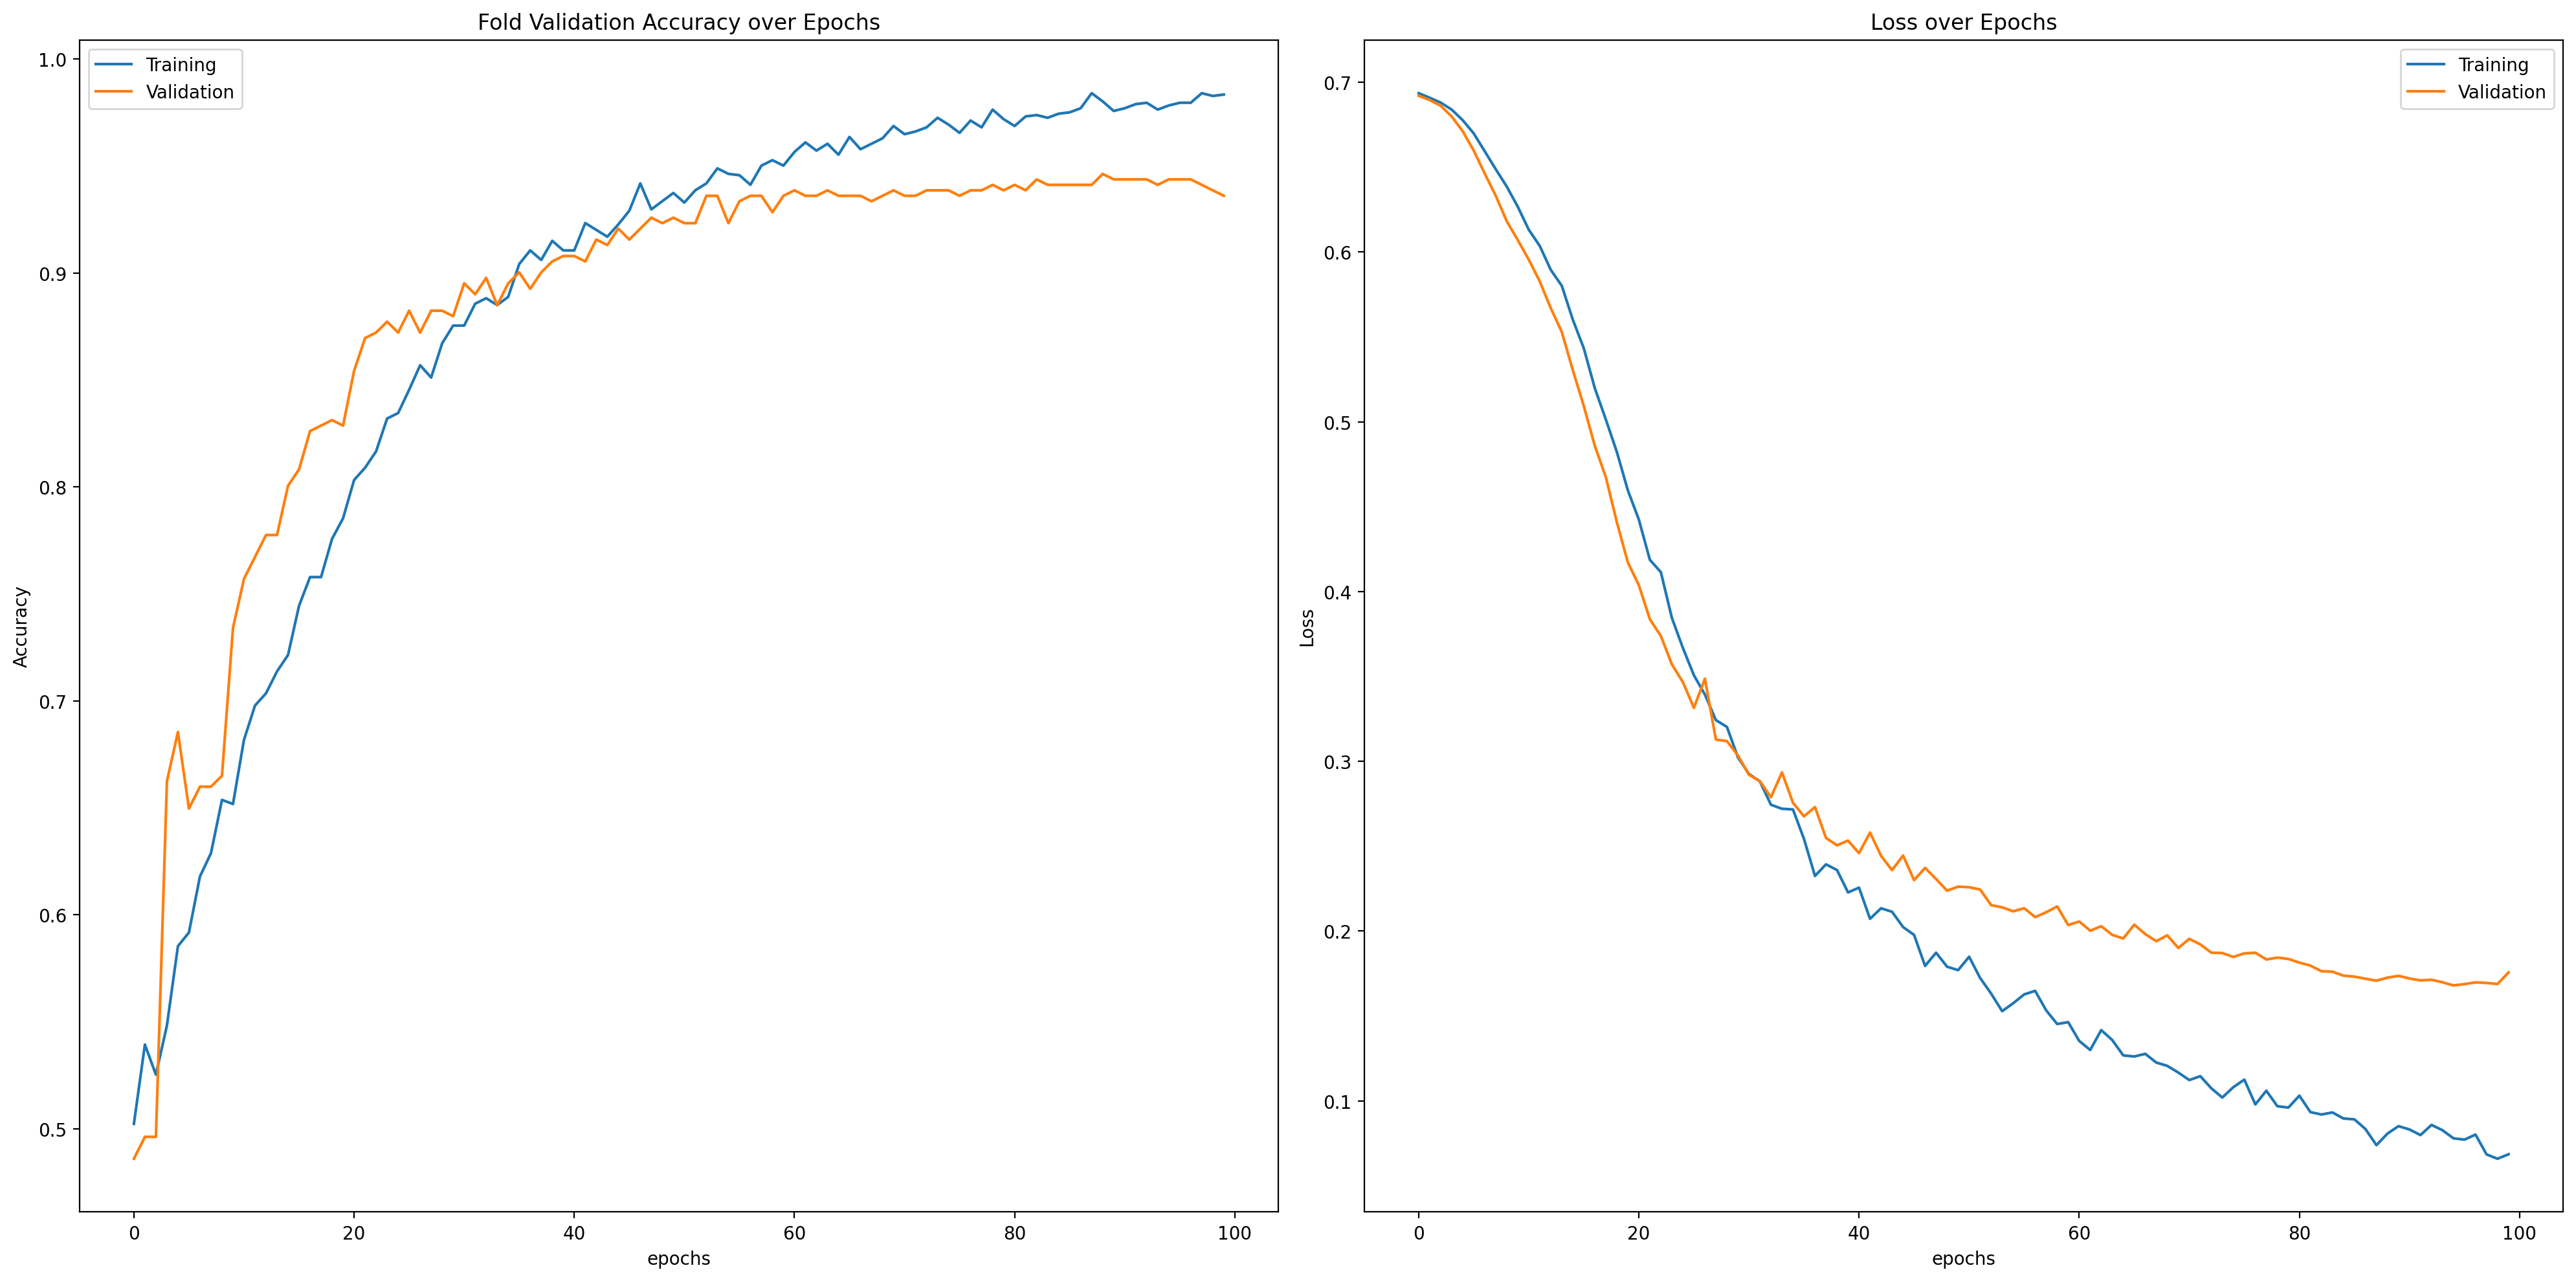

13/13 [==============================] - 0s 8ms/step
Fold validation accuracy: 0.9360613822937012
Graph 4:


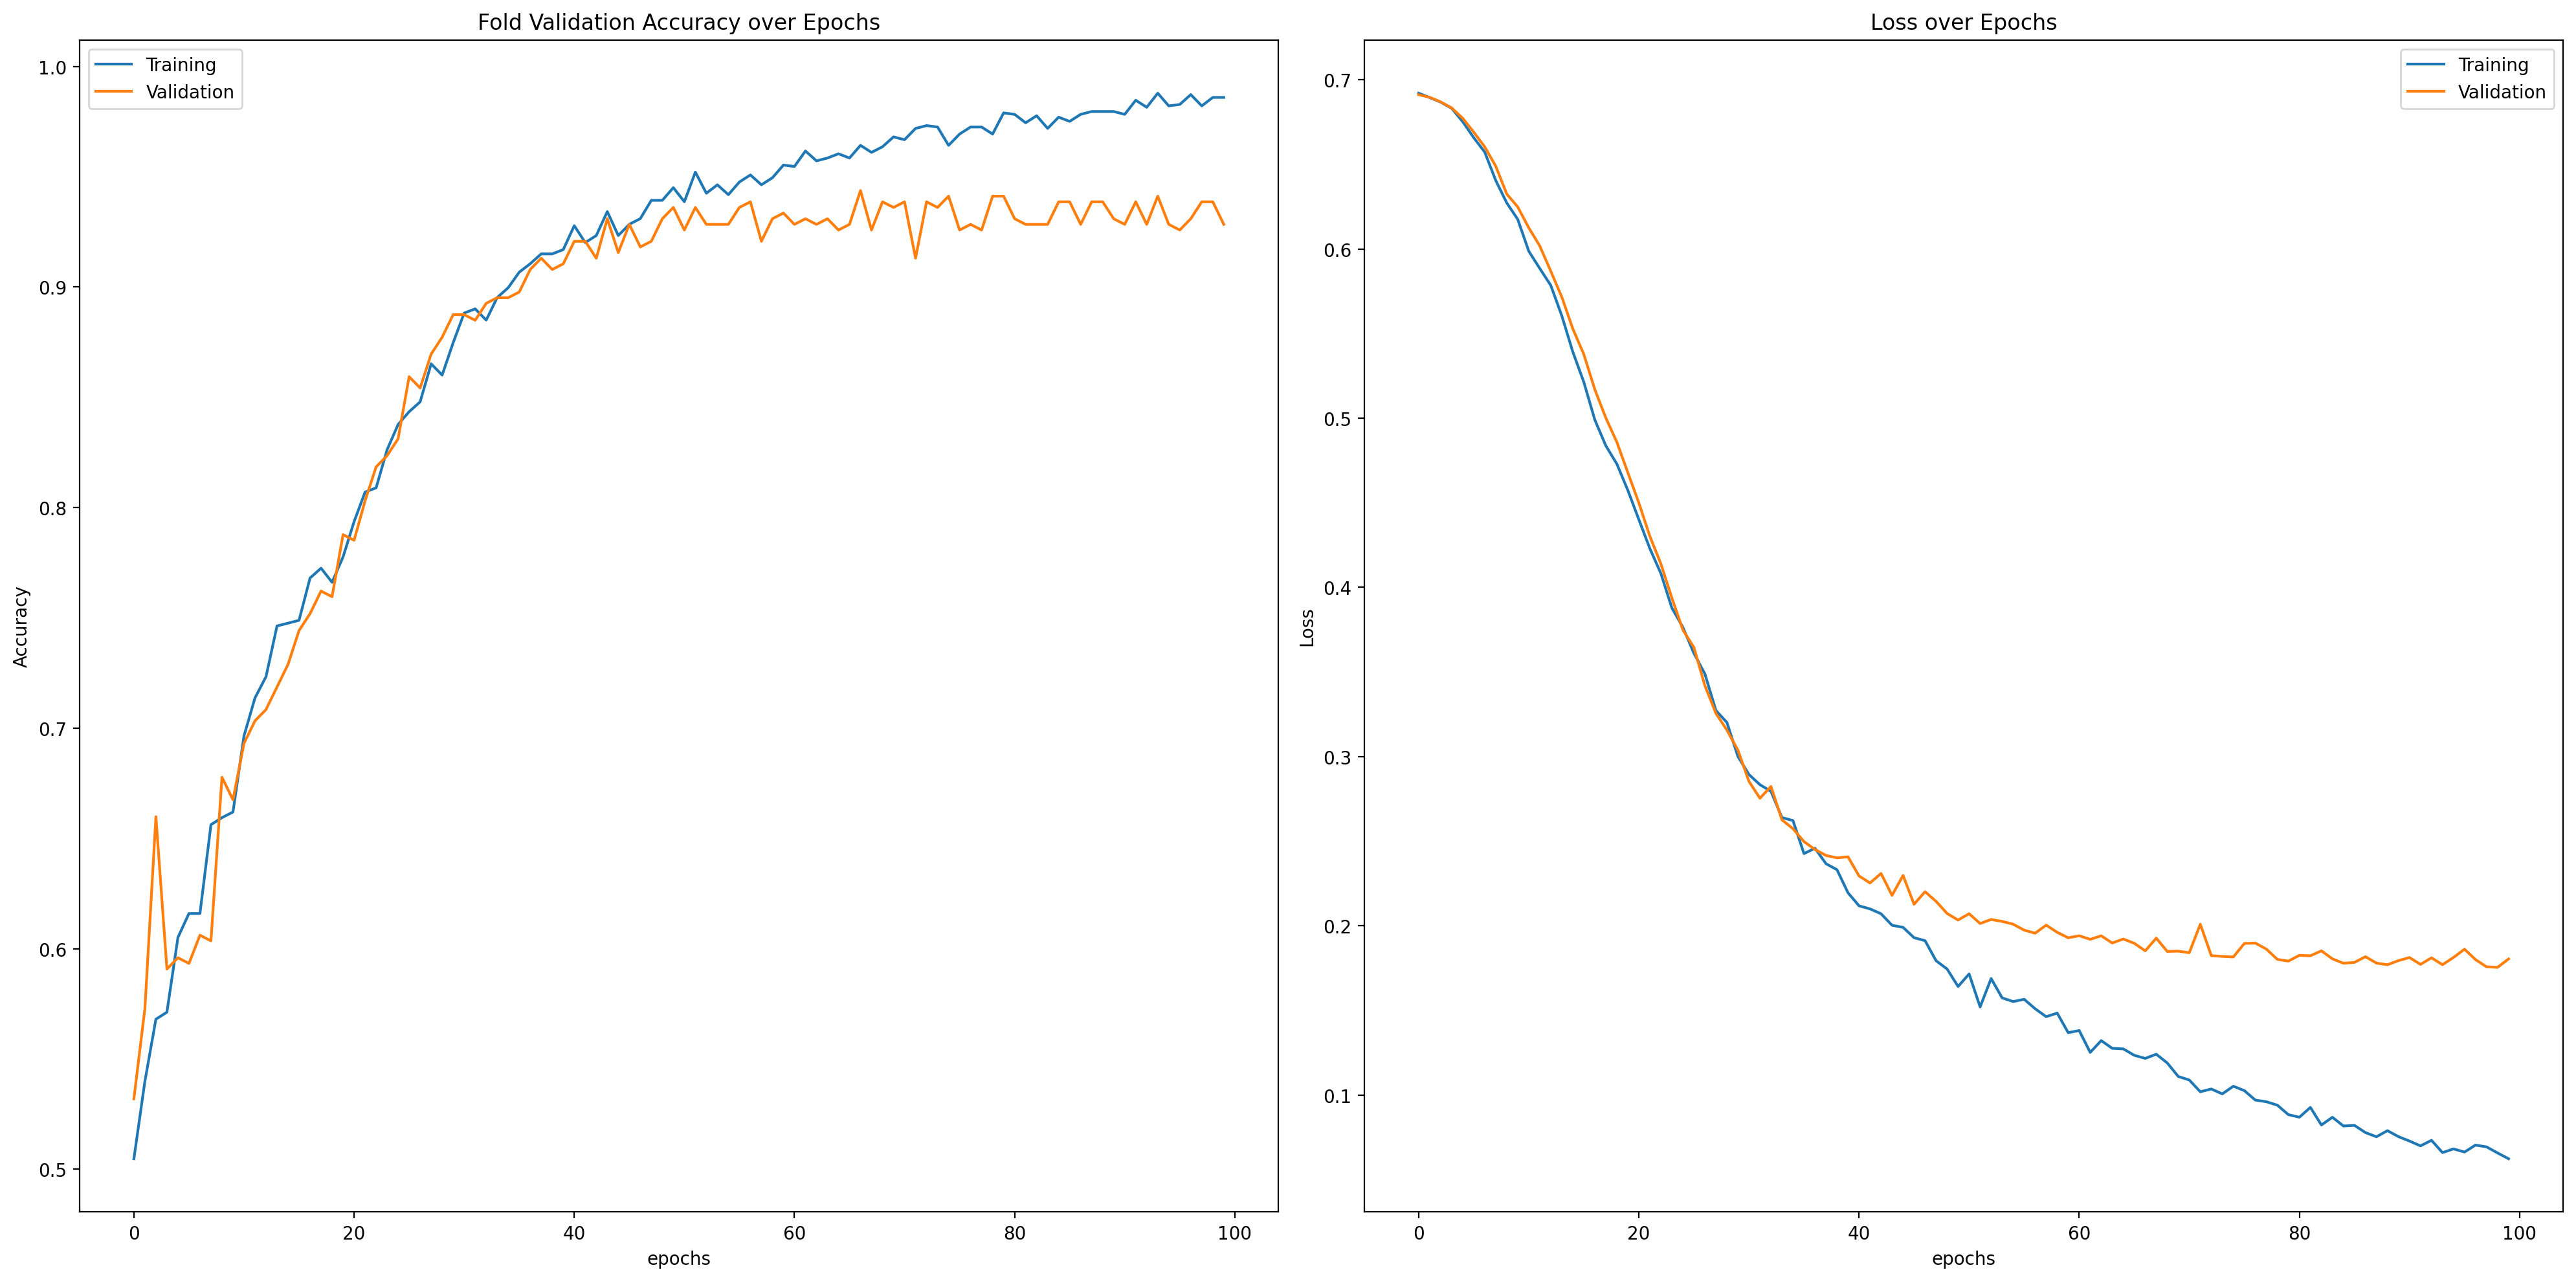

13/13 [==============================] - 0s 10ms/step
Fold validation accuracy: 0.928388774394989
Graph 5:


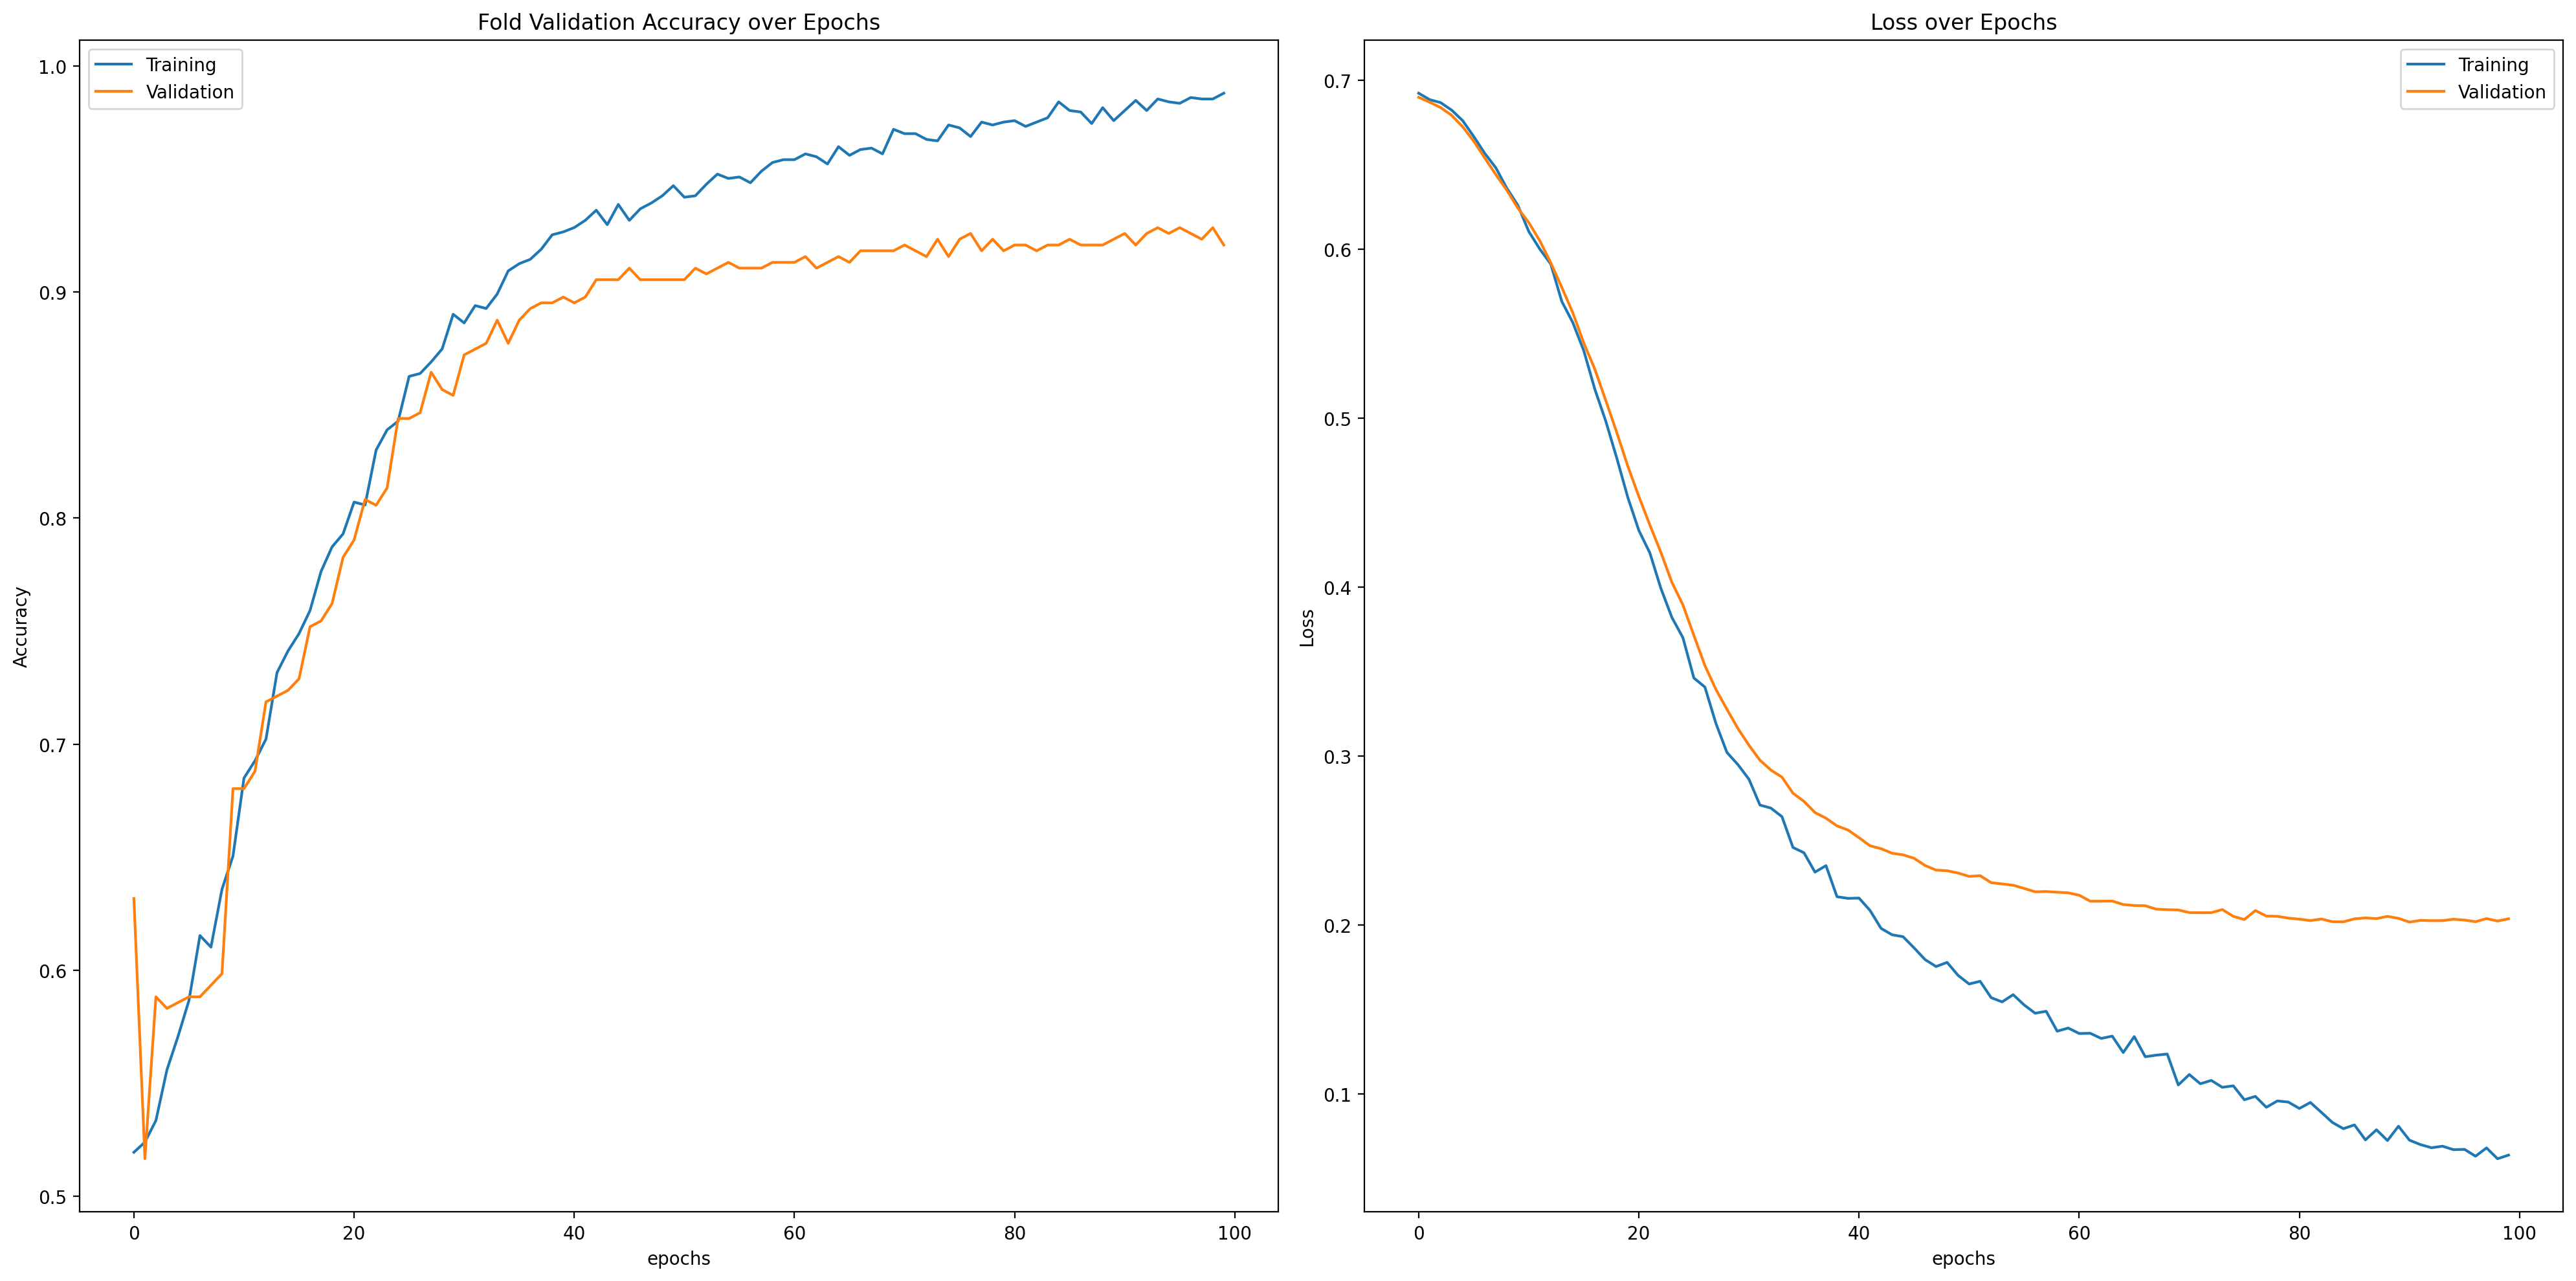

13/13 [==============================] - 0s 10ms/step
Fold validation accuracy: 0.9207161068916321
Average Accuracy: 0.928938090801239


In [38]:
# the input is a list of integers, 500 long
sequence_input = Input(shape=(X.shape[1], ))

embedded_sequences = Embedding(
    len(word_index) + 1, EMBED_SIZE, weights=[embedding_matrix], input_length=max_length, 
    trainable=False)(sequence_input)

x = Conv1D(64, 5, activation='relu',kernel_initializer='he_uniform')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

# Just Mean Pooling but kernel size is the whole thing, leaves 64 results for each of the 64 filters.
x_mean = GlobalAveragePooling1D()(x)

# Both of these steps compute the Variance, results in 64 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])

x = Dense(32, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

cnn1 = Model(sequence_input, preds)
pred_cnn1, acc_cnn1 = test_model(X, labels, kf, cnn1, 1, "cnn1_predictions.csv", ep=100, bs=64, lr=0.0001)

Graph 1:


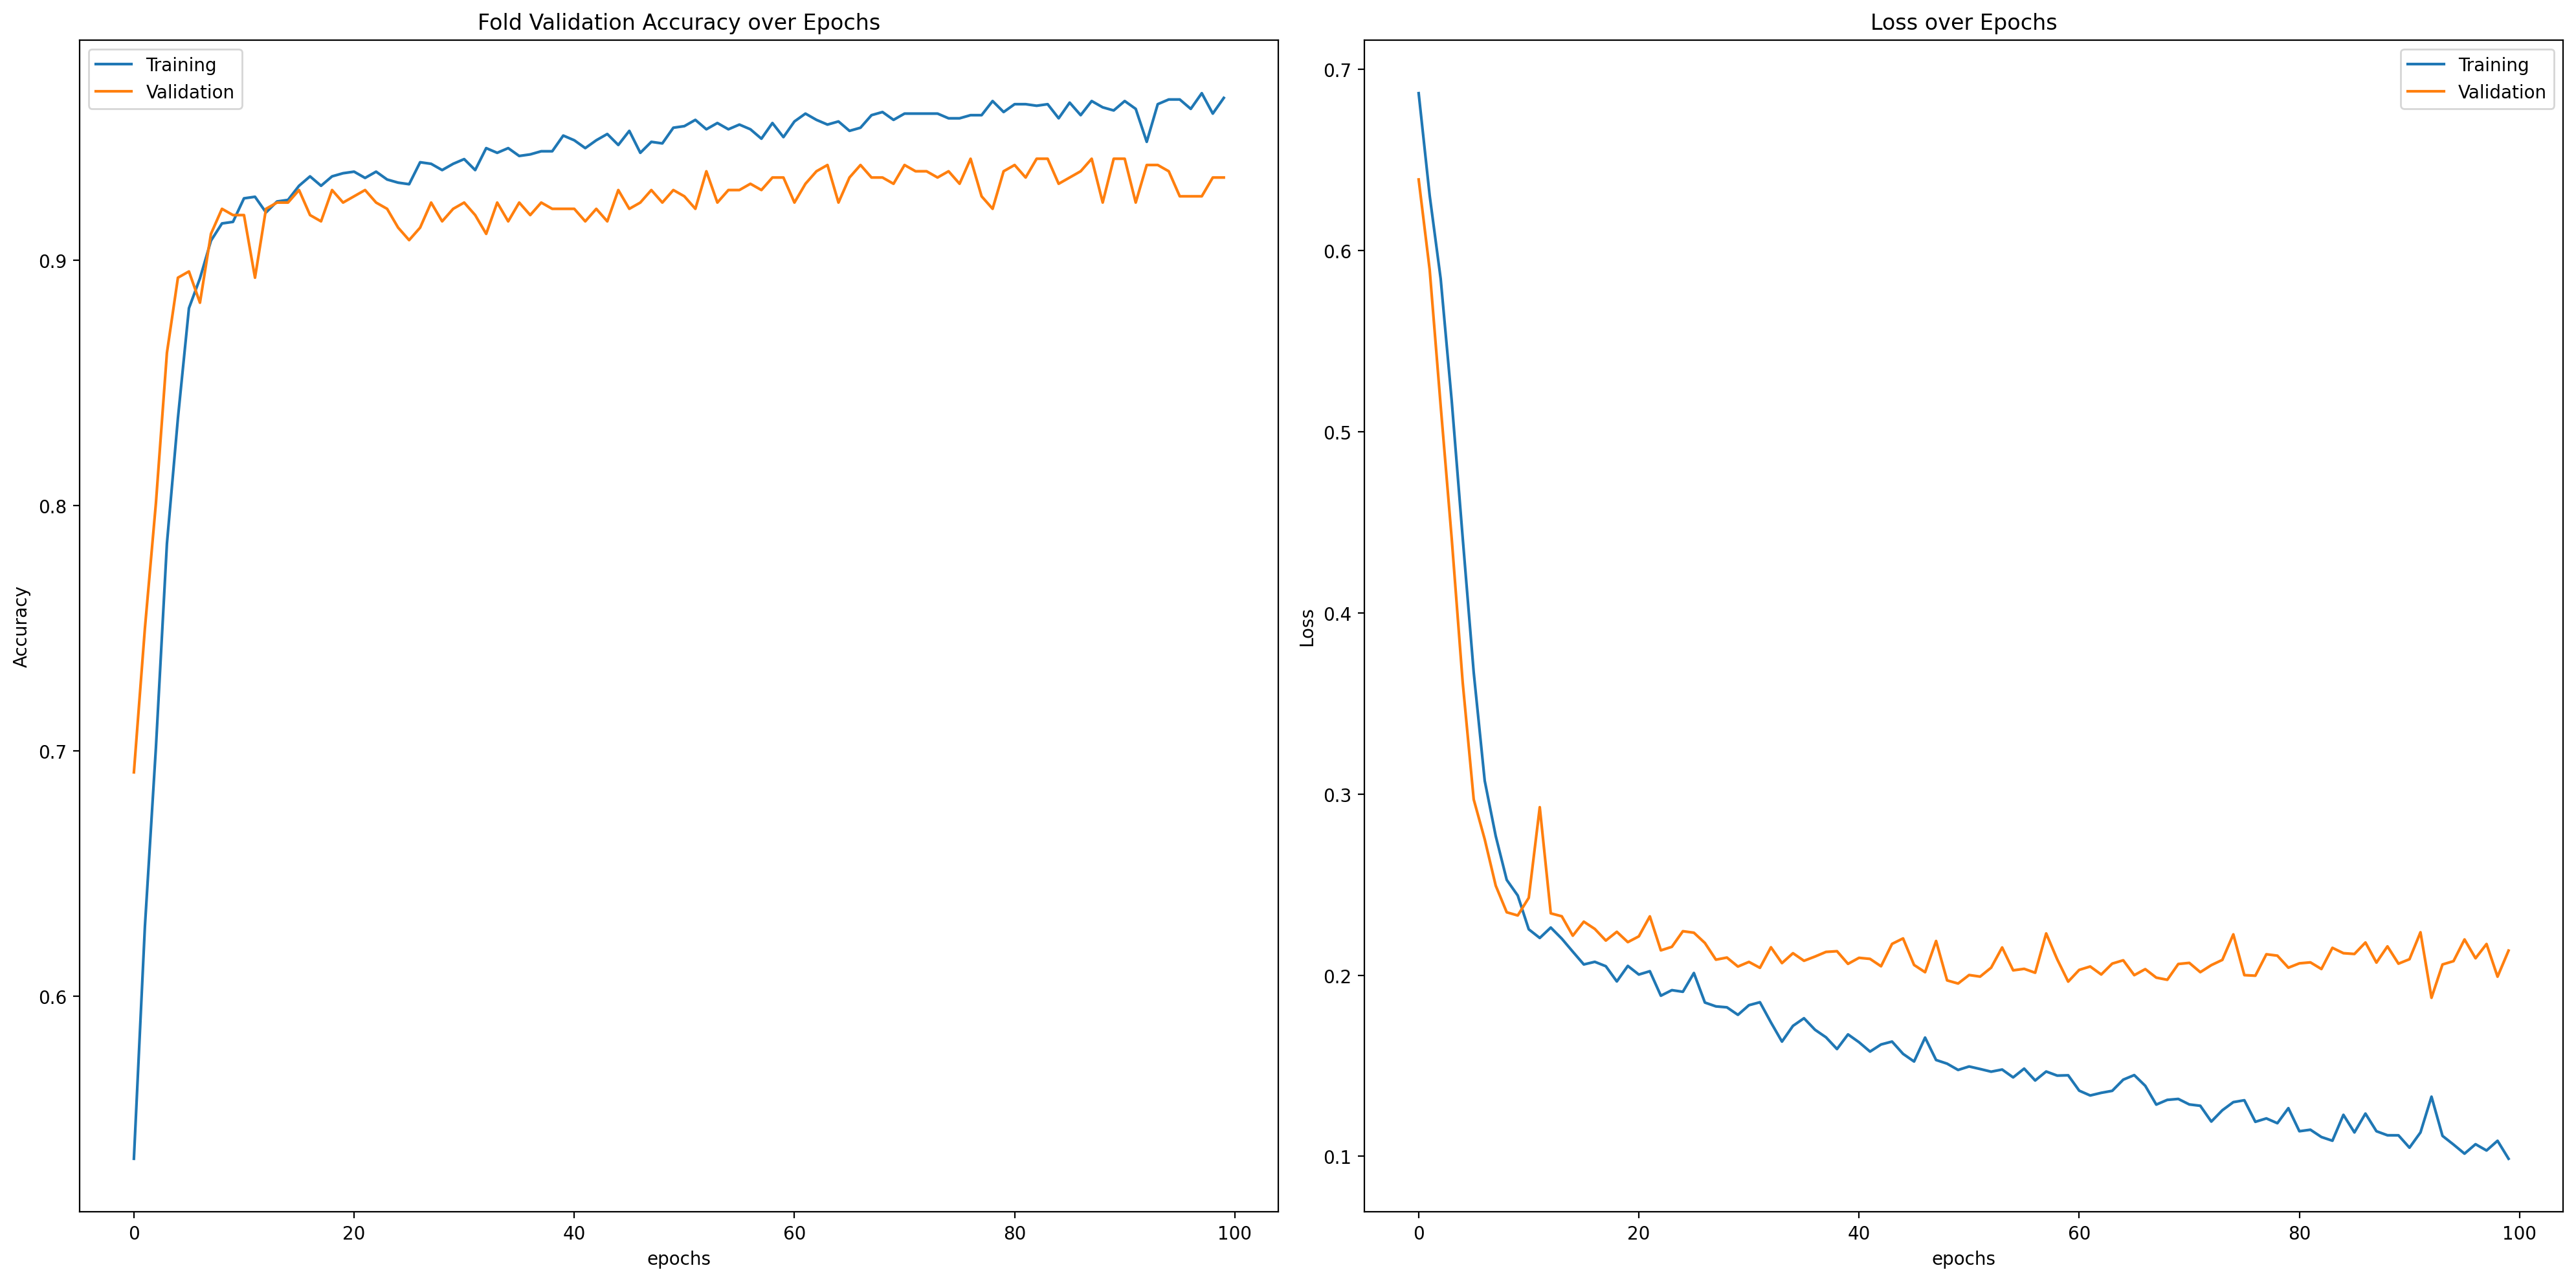

13/13 [==============================] - 1s 44ms/step
Fold validation accuracy: 0.9336734414100647
Graph 2:


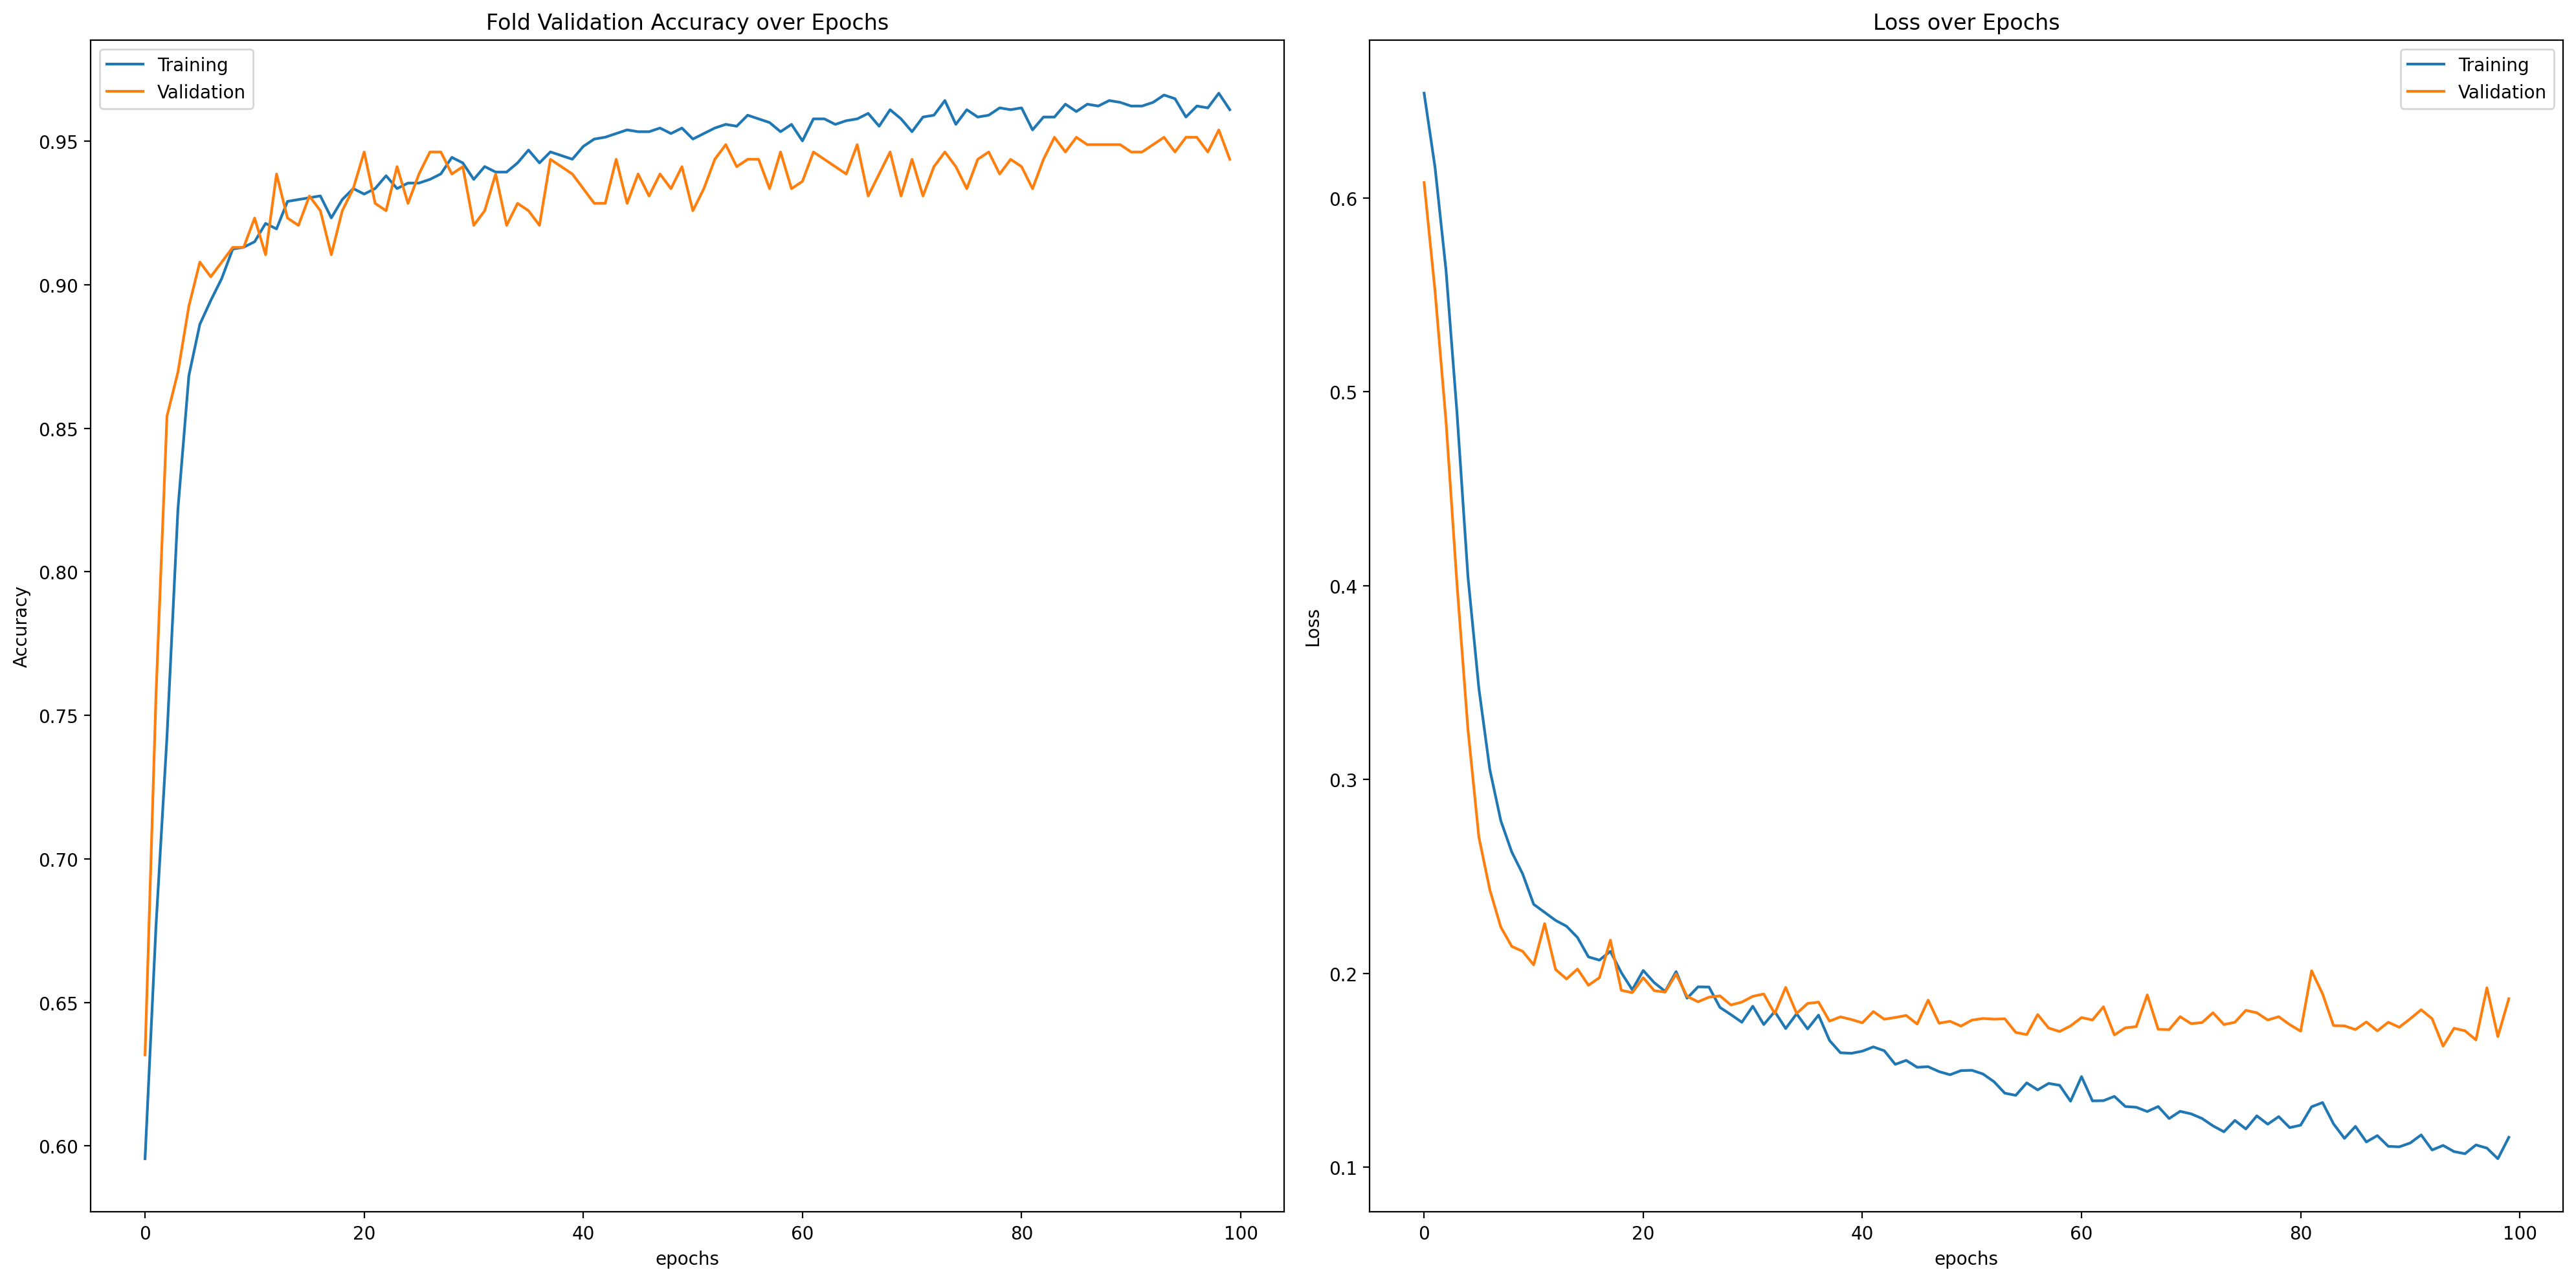

13/13 [==============================] - 1s 40ms/step
Fold validation accuracy: 0.9437339901924133
Graph 3:


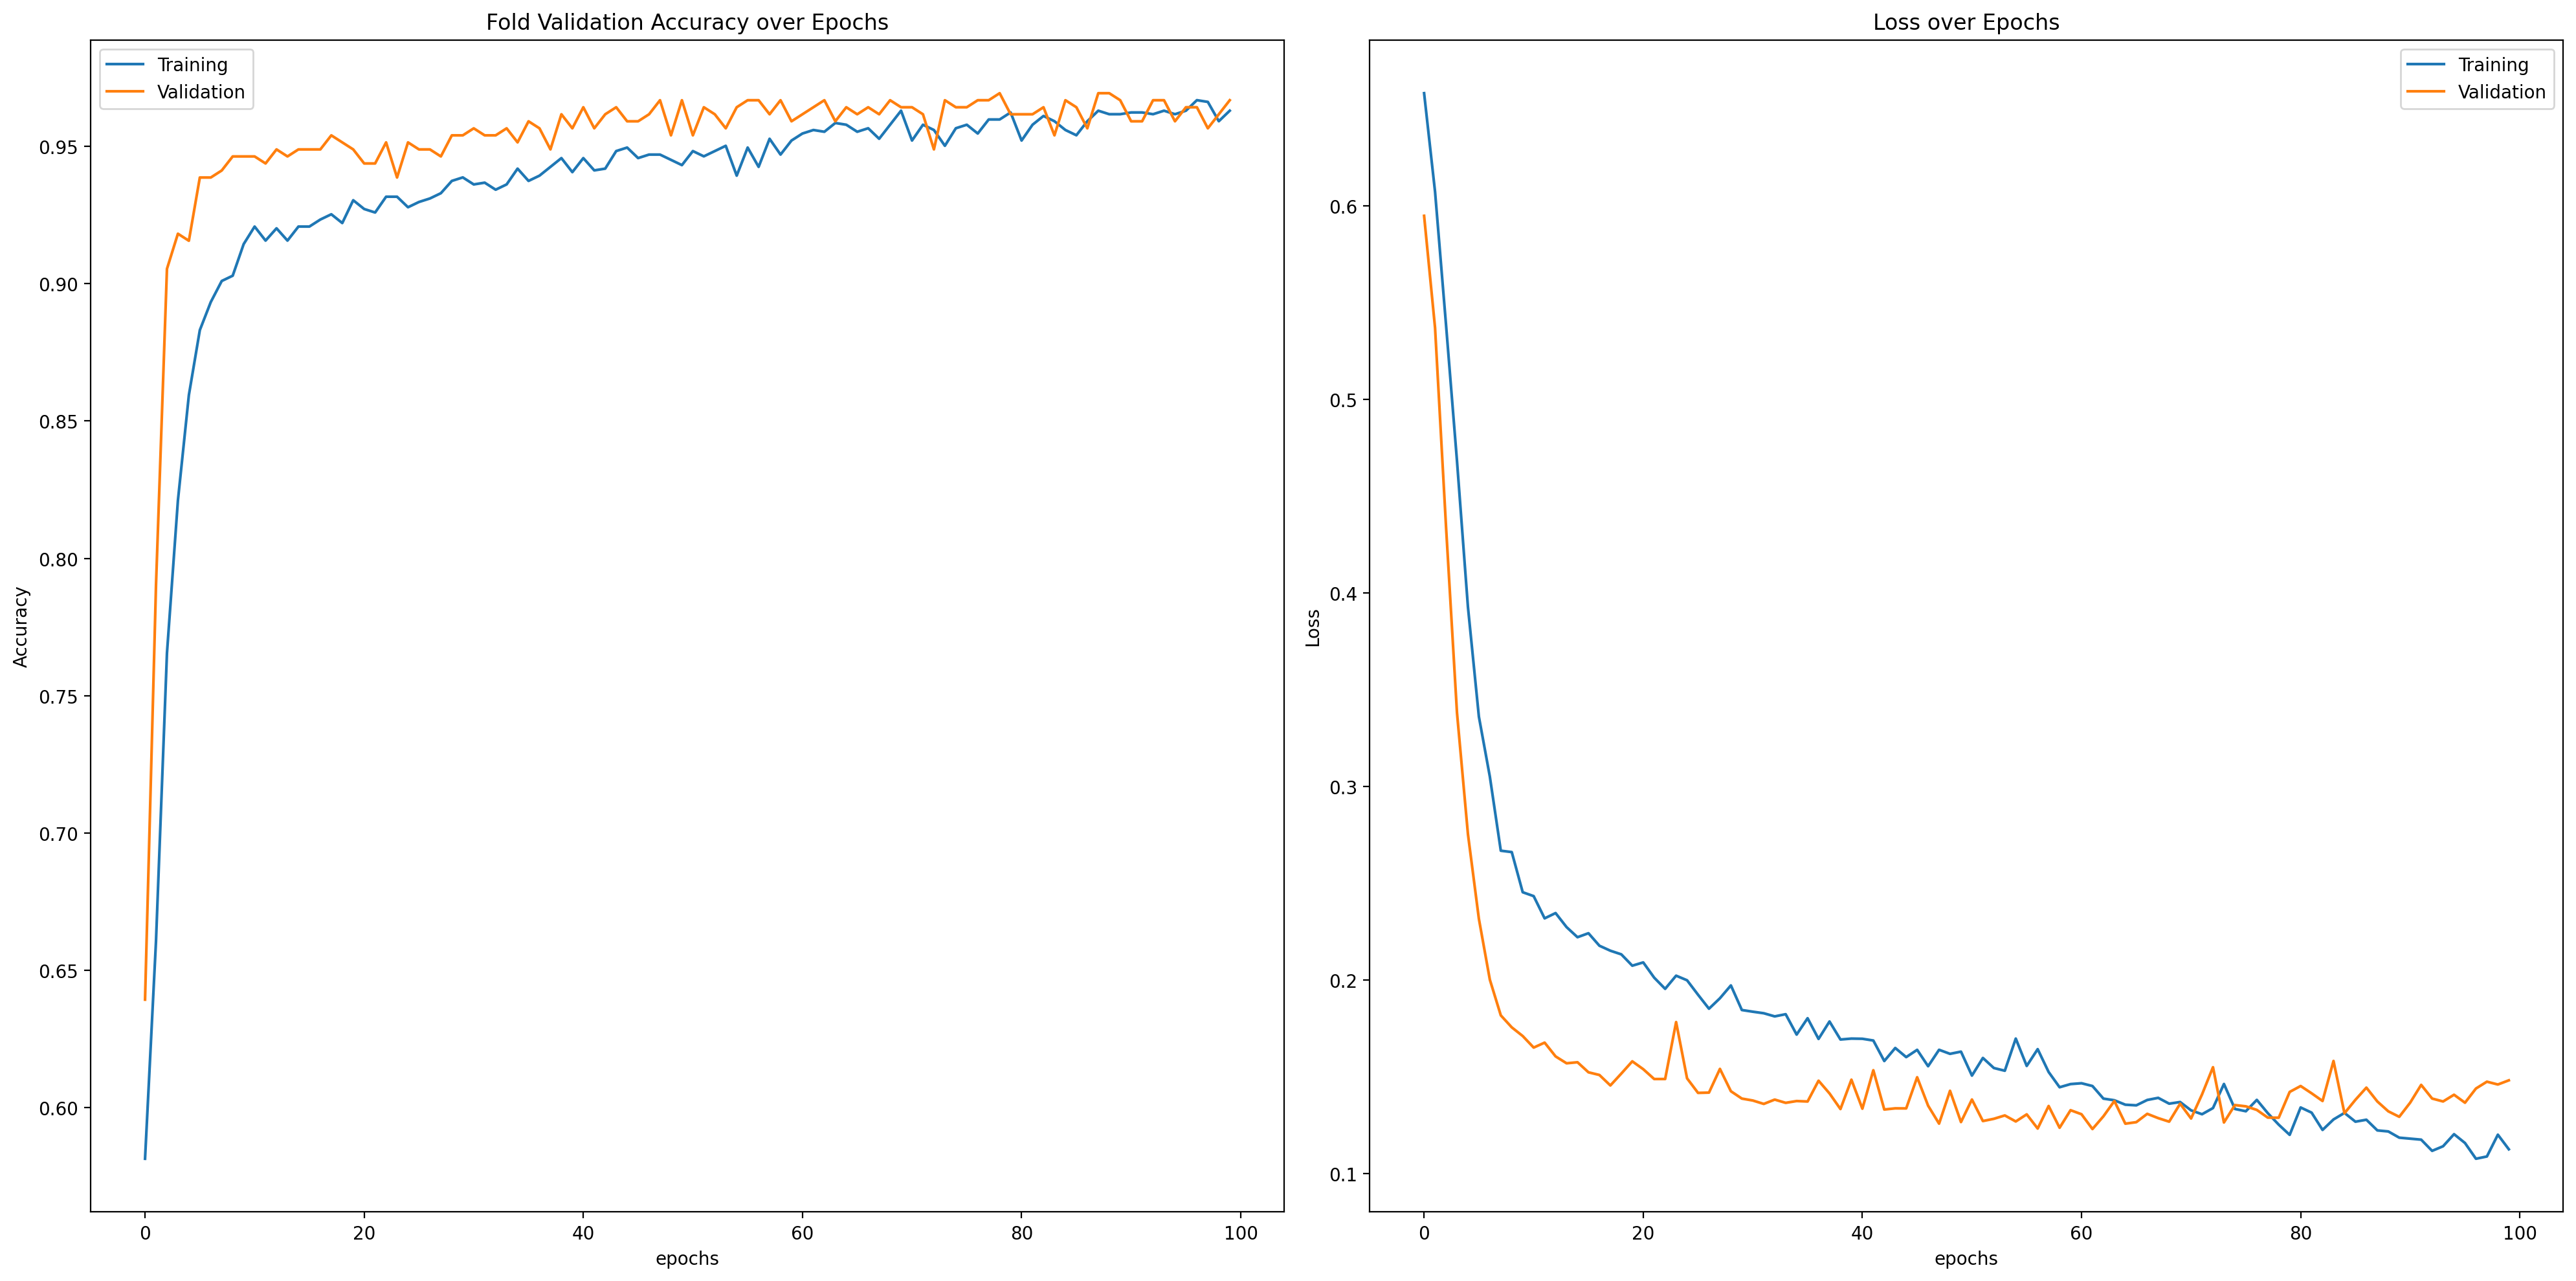

13/13 [==============================] - 1s 40ms/step
Fold validation accuracy: 0.9667519330978394
Graph 4:


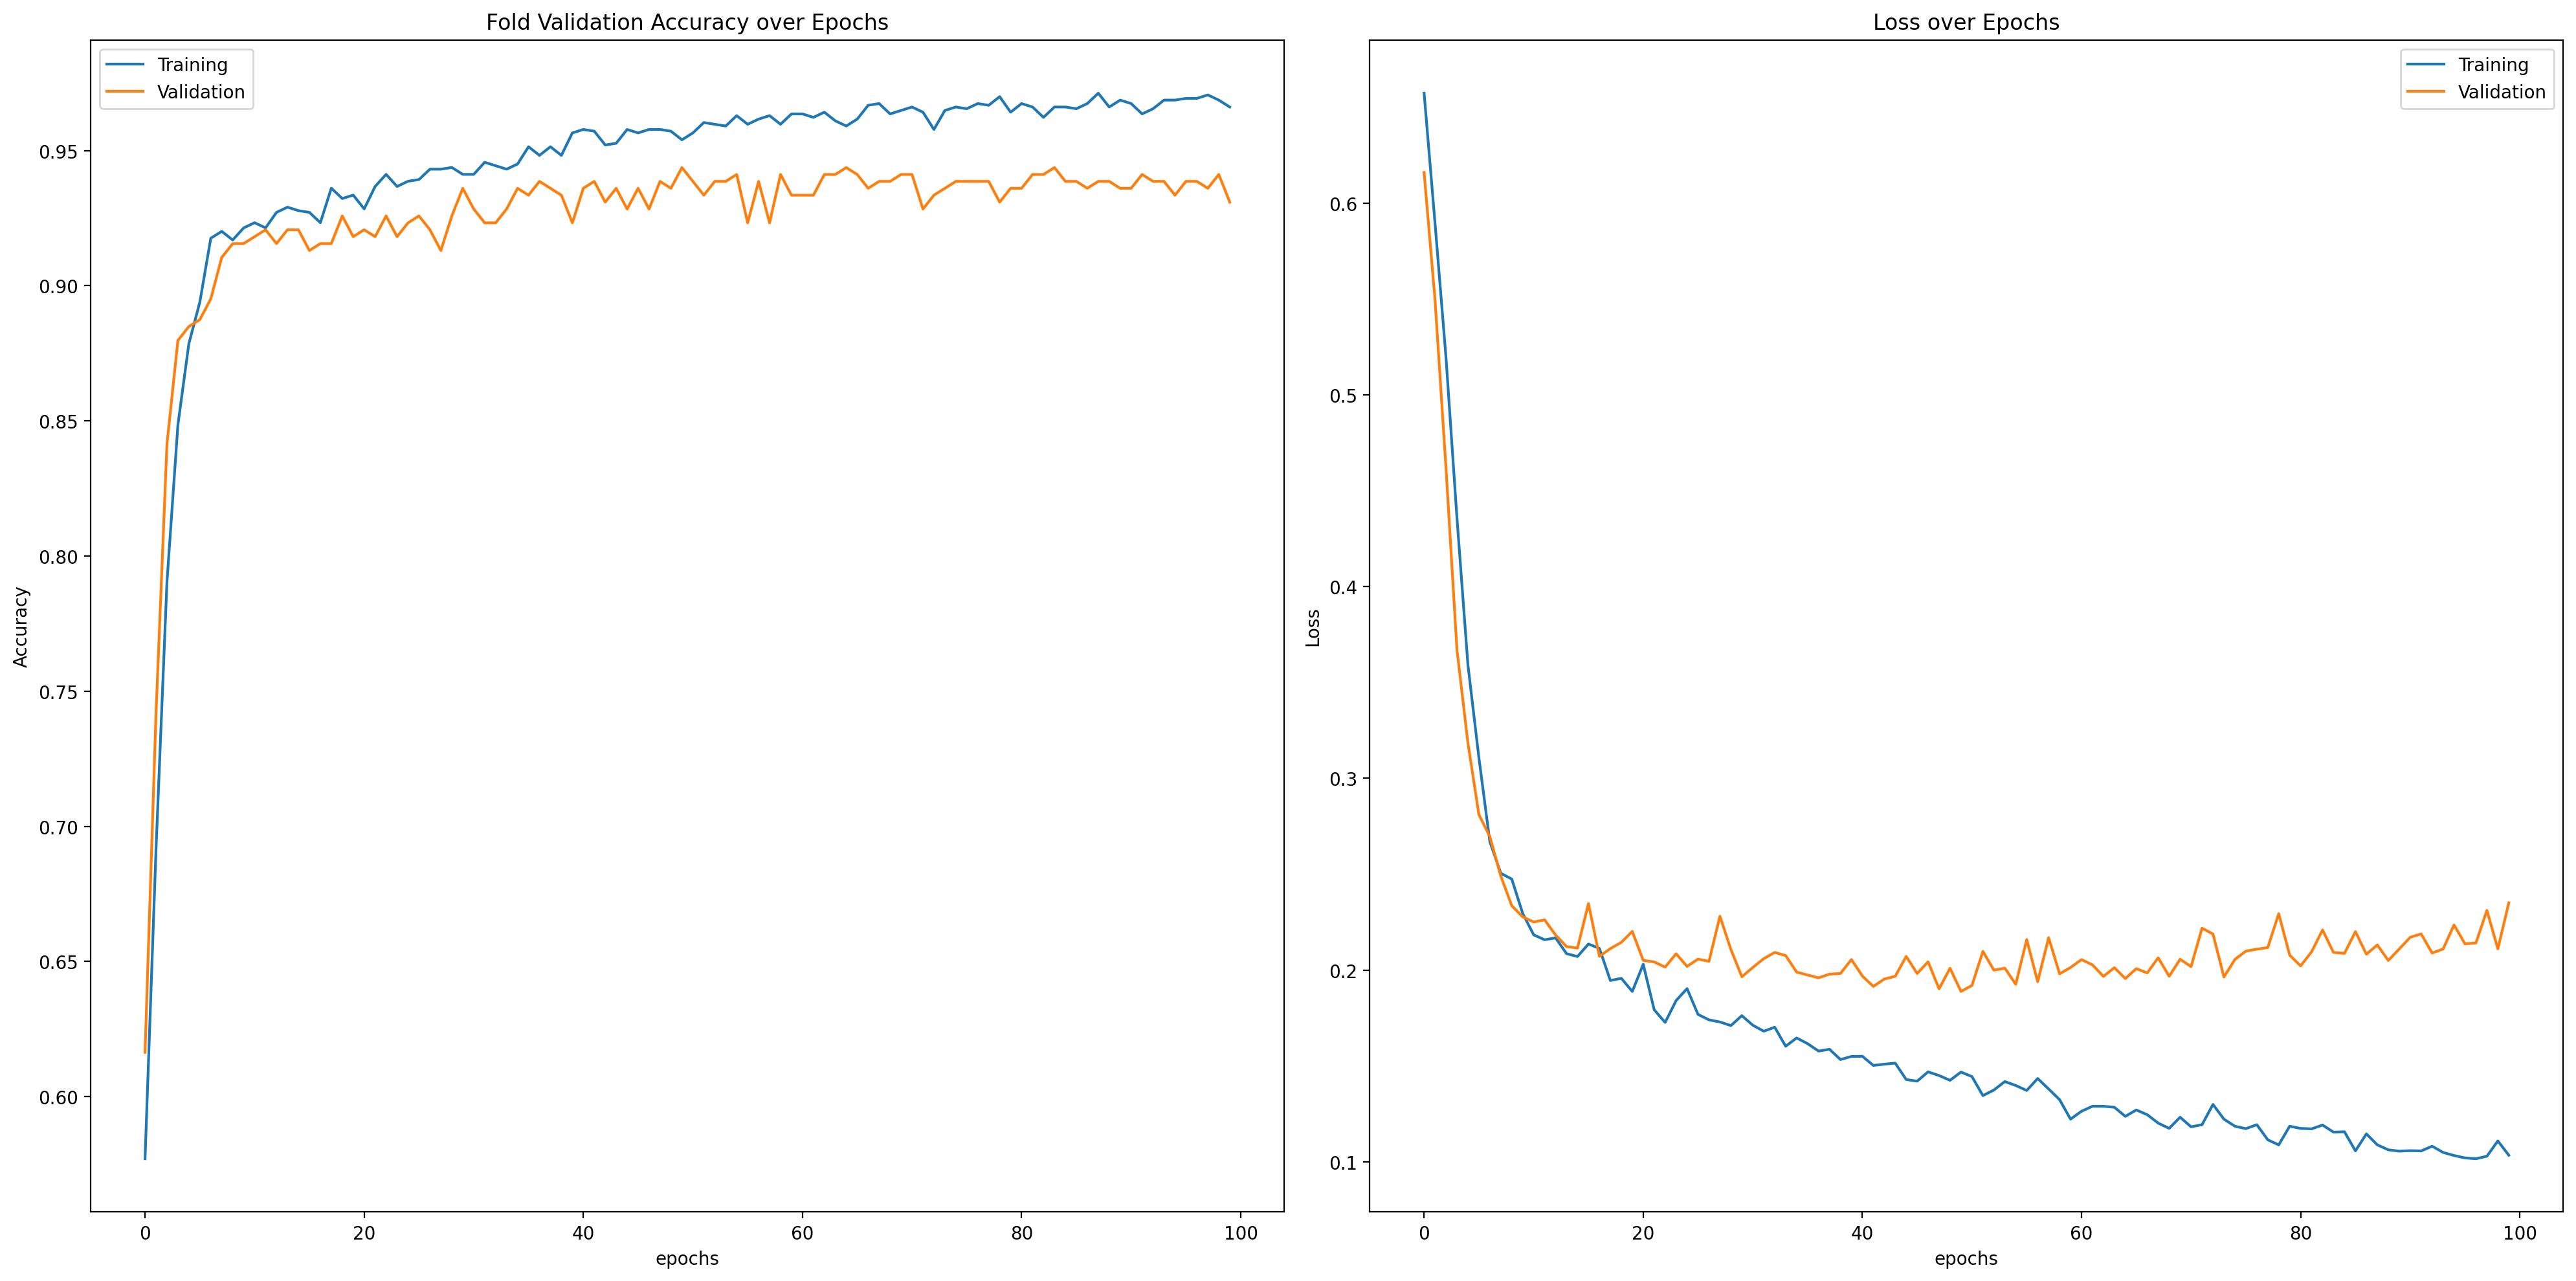

13/13 [==============================] - 1s 44ms/step
Fold validation accuracy: 0.9309462904930115
Graph 5:


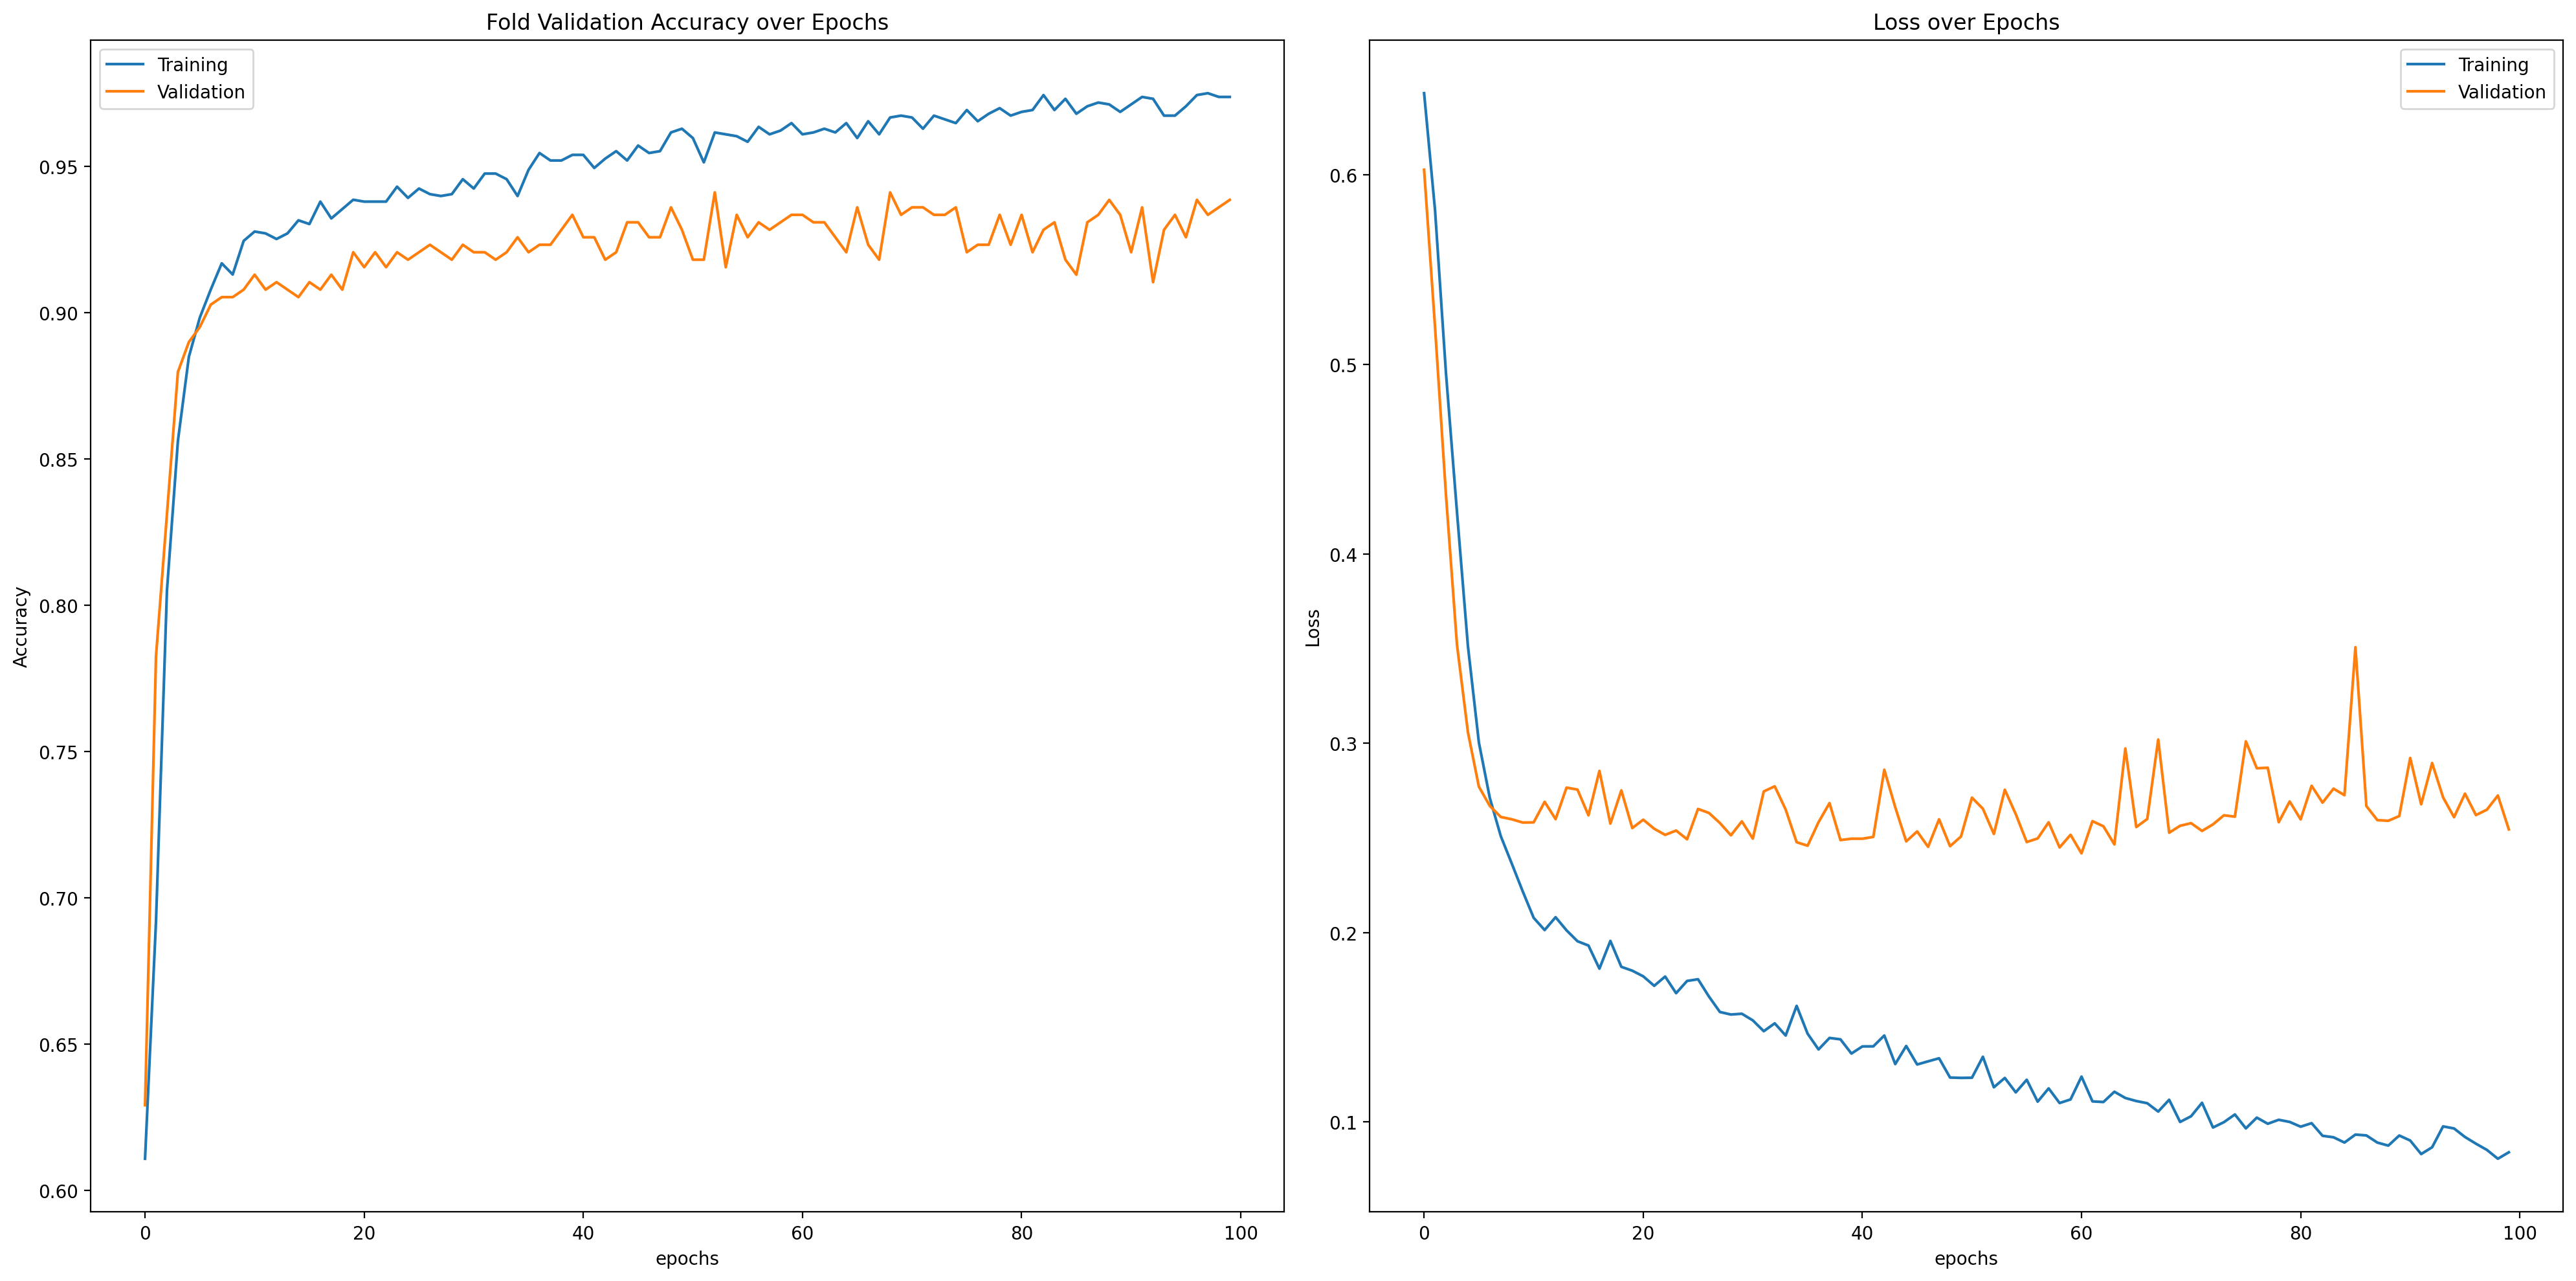

13/13 [==============================] - 1s 44ms/step
Fold validation accuracy: 0.9386188983917236
Average Accuracy: 0.9427449107170105


In [77]:
num_words = 4952
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X.shape[1],))
x = TokenAndPositionEmbedding(X.shape[1], num_words, EMBED_SIZE, embedding_matrix)(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

trans1 = Model(inputs=inputs, outputs=outputs)
pred_trans1, acc_trans1 = test_model(X, labels, kf, trans1, 1, "trans1_predictions.csv", ep=100, bs=64, lr=0.0001)